## 1 - Importing Packages

In [ ]:
!pip install keras-tcn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 18.4 MB/s eta 0:00:00


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.5 MB/s eta 0:00:00


In [ ]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:00
time: 251 µs (started: 2023-07-12 20:33:07 +00:00)


In [ ]:
import pandas as pd
import numpy as np
import math
import json
import pickle
import itertools
import time

from scipy.io import arff
import matplotlib.pyplot as plt

import glob
import os

import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Conv1D, TimeDistributed, Flatten, Activation, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import History, TensorBoard, Callback
import tensorflow.keras.initializers as KI

import keras_tuner
from keras_tuner.tuners import Hyperband

from tcn import TCN, tcn_full_summary
from tensorflow.keras import backend as K

import sklearn
import xgboost as xgb
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score

import tensorflow as tf
from datetime import datetime

time: 4.69 s (started: 2023-07-12 20:33:07 +00:00)


## 2 - Data Importing

In [ ]:
video_param = json.load(open('/content/drive/MyDrive/Skripsi/GazeCom_video_parameters.json'))
video_names = video_param['video_names']

path_h5 = '/content/drive/MyDrive/Skripsi/GazeCom_preprocessed_fixed_ppd_720.h5'
loaded_data = pickle.load(open(path_h5, 'rb'))
data_X, data_Y, data_Y_one_hot = loaded_data['data_X'], loaded_data['data_Y'], loaded_data['data_Y_one_hot']

time: 14.3 s (started: 2023-07-03 16:58:48 +00:00)


## 3 - Feature Selection

In [ ]:
keys_to_subtract_start_indices = []
columns_to_keep = [2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40]

time: 320 µs (started: 2023-07-03 16:59:02 +00:00)


In [ ]:
selected_data_X = []

# Iterate over folders
for folder in data_X:
    selected_folder = []

    # Iterate over files in the current folder
    for file_data in folder:
        # Select the desired features using the selected feature indices
        selected_file_data = file_data[:, columns_to_keep]
        selected_folder.append(selected_file_data)

    selected_data_X.append(selected_folder)

# Verify the shape of selected_data_X
print("Shape of selected_data_X:", np.array(selected_data_X).shape)

Shape of selected_data_X: (18,)
time: 725 ms (started: 2023-07-03 16:59:02 +00:00)


<ipython-input-9-37a7aa25115e>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print("Shape of selected_data_X:", np.array(selected_data_X).shape)


In [ ]:
data_X = selected_data_X
selected_data_X = 0

time: 271 µs (started: 2023-07-03 16:59:03 +00:00)


In [ ]:
## Checking the shape of selected features data
np.array(data_X[0][0]).shape

(5008, 28)

time: 2.36 ms (started: 2023-07-03 16:59:03 +00:00)


## 4 - Modelling Prerequsite

### Feature Extraction Process
The extracted data will be in both `windows_x` and `windows_y` variable

Function to Extract Windows

In [ ]:
def zip_equal(*args):
    fallback = object()
    for combination in itertools.zip_longest(*args, fillvalue = fallback):
        yield combination

def extract_windows(x, y, window_length, padding_features, downsample = 1):
    res_x = []
    res_y = []

    for x_item, y_item in zip_equal(x, y):
        padding_size_x = padding_features
        padding_size_y = 0

        padded_x = np.pad(x_item, ((padding_size_x, padding_size_x), (0, 0)), 'reflect')
        padded_y = np.pad(y_item, ((padding_size_y, padding_size_y), (0, 0)), 'constant')

        window_length_x = window_length + 2 * padding_features
        res_x += [padded_x[i:i + window_length_x, :] for i in range(0, padded_x.shape[0] - window_length_x + 1, downsample)]
        res_y += [padded_y[i:i + window_length, :] for i in range(0, padded_y.shape[0] - window_length + 1, downsample)]

    return res_x, res_y

time: 821 µs (started: 2023-07-03 16:59:03 +00:00)


In [ ]:
window_size = 385
overlap = 312
downsample = window_size - overlap
padding_features = 0

windows_x = []
windows_y = []

for subset_index in range(len(data_X)):
    x, y = extract_windows(data_X[subset_index], data_Y_one_hot[subset_index], window_length = window_size, downsample = downsample, padding_features = padding_features)
    windows_x.append(np.array(x))
    windows_y.append(np.array(y))

    ## Subtracting the first value of each feature inside each window
    for col_ind in keys_to_subtract_start_indices:
        windows_x[-1][:, :, col_ind] -= windows_x[-1][:, 0, col_ind].reshape(-1, 1)

time: 2.2 s (started: 2023-07-03 16:59:03 +00:00)


### Function to Evaluate

If using K Fold CV

In [ ]:
def evaluate_test_cv(model, X, y, batch_size):

    batch_size = batch_size
    original_len = X.shape[0]
    target_len = int(np.ceil(float(original_len) / batch_size)) * batch_size
    X = np.pad(X, pad_width = ((0, target_len - X.shape[0]), (0, 0), (0, 0)), mode = 'constant')

    # take only the needed predictions
    res_proba = model.predict(X, batch_size = batch_size)[:original_len]
    results = {}

    unknown_class_mask = y[:, :, 0] == 1
    res_proba[unknown_class_mask] = 0.0
    res_proba[unknown_class_mask, 0] = 1.0
    res = np.argmax(res_proba, axis=-1)

    raw_results = {'true': y, 'pred': res_proba}

    results['accuracy'] = (np.mean(res[np.logical_not(unknown_class_mask)] ==
                                    np.argmax(y[np.logical_not(unknown_class_mask)], axis=-1)))

    #results['F1_Score'] = f1_score(y, res_proba)

    for stat_i, stat_name in zip(range(1, 5), ['FIX', 'SACC', 'SP', 'NOISE']):
        results['F1-{}'.format(stat_name)] = K.eval(categorical_f1_score_for_class(y, res_proba, stat_i,
                                                                                    'float64'))
    return raw_results, results

time: 1.57 ms (started: 2023-07-03 18:26:17 +00:00)


If using LOVO

In [ ]:
def evaluate_test_lovo(
    model, X, y = None,
    keys_to_subtract_start_indices = (),
    correct_for_unknown_class = True,
    padding_features = 0,
    temporal_padding = False,
    split_by_items = True,
):

    res_Y = [] if y is not None else None
    res_X = []
    if y is None:
        y = [None] * len(X)

    window_length = model.output_shape[1]  # output_shape is (batch_size, NUM_SAMPLES, NUM_CLASSES)
    downsample = window_length  # no overlap here

    items_start = []
    items_end = []

    for x_item, y_item in zip_equal(X, y):
        items_start.append(len(res_X))

        # how much padding is needed additionally, for full-window size
        target_length = int(math.ceil(x_item.shape[0] / float(window_length)) * window_length)
        padding_size_x = [0, target_length - x_item.shape[0]]
        padding_size_y = [0, target_length - y_item.shape[0]] if y_item is not None else [0, 0]

        # pad features (@x_item) for all windows
        padding_size_x = [elem + padding_features for elem in padding_size_x]
        # no @y_item-padding required

        if temporal_padding:
            padding_size_x = [elem + window_length / 2 for elem in padding_size_x]
            padding_size_y = [elem + window_length / 2 for elem in padding_size_y]

        padded_x = np.pad(x_item, (padding_size_x, (0, 0)), 'reflect')  # x is padded with reflections to limit artifacts
        if y_item is not None:
            padded_y = np.pad(y_item, (padding_size_y, (0, 0)), 'constant')  # y is zero-padded to ignore those labels
            # set to UNKNOWN class
            has_no_label_mask = padded_y.sum(axis=1) == 0
            padded_y[has_no_label_mask, 0] = 1

        window_length_x = window_length + 2 * padding_features
        res_X += [padded_x[i:i + window_length_x, :] for i in
                  range(0, padded_x.shape[0] - window_length_x + 1, downsample)]
        if y_item is not None:

            res_Y += [padded_y[i:i + window_length, :] for i in
                      range(0, padded_y.shape[0] - window_length + 1, downsample)]

        items_end.append(len(res_X))

    res_X = np.array(res_X)
    if res_Y is not None:
        res_Y = np.array(res_Y)

    # Subtract the first value of each feature (for which it is necessary) inside each window
    for col_ind in keys_to_subtract_start_indices:
        res_X[:, :, col_ind] -= res_X[:, 0, col_ind].reshape(-1, 1)

    batch_size = 128
    original_len = res_X.shape[0]
    target_len = int(np.ceil(float(original_len) / batch_size)) * batch_size
    res_X = np.pad(res_X,
                   pad_width=((0, target_len - res_X.shape[0]), (0, 0), (0, 0)),
                   mode='constant')
    # take only the needed predictions
    res_proba = model.predict(res_X, batch_size=batch_size)[:original_len]

    results = {}

    if correct_for_unknown_class and res_Y is not None:
        unknown_class_mask = res_Y[:, :, 0] == 1
        res_proba[unknown_class_mask] = 0.0
        res_proba[unknown_class_mask, 0] = 1.0
    res = np.argmax(res_proba, axis=-1)

    raw_results = {'true': res_Y, 'pred': res_proba}

    # cannot evaluate unless the labels @y were provided
    if res_Y is not None:
        results['accuracy'] = (np.mean(res[np.logical_not(unknown_class_mask)] ==
                                       np.argmax(res_Y[np.logical_not(unknown_class_mask)], axis=-1)))

        for stat_i, stat_name in zip(range(1, 5), ['FIX', 'SACC', 'SP', 'NOISE']):
            results['f1-{}'.format(stat_name)] = K.eval(categorical_f1_score_for_class(res_Y, res_proba, stat_i,
                                                                                       'float64'))
        results['f1_score'] = float(str(f1_score(res_Y, res_proba))[10:19])

    if split_by_items:
        # split into individual sequences
        split_res_true = [] if res_Y is not None else None
        split_res_pred = []
        for individual_start, individual_end in zip_equal(items_start, items_end):
            if res_Y is not None:
                split_res_true.append(raw_results['true'][individual_start:individual_end])
            split_res_pred.append(raw_results['pred'][individual_start:individual_end])
        raw_results = {'true': split_res_true, 'pred': split_res_pred}

    return raw_results, results

time: 2.21 ms (started: 2023-07-03 20:32:53 +00:00)


General scoring method function

In [ ]:
def categorical_f1_score_for_class(y_true, y_pred, class_i, dtype=None):
    pred_labels = K.argmax(y_pred, axis=-1)
    tp = K.sum(y_true[:, :, class_i] * K.cast(K.equal(pred_labels, class_i), 'float32' if not dtype else dtype))
    all_p_detections = K.sum(K.cast(K.equal(pred_labels, class_i), 'float32' if not dtype else dtype))
    all_p_true = K.sum(y_true[:, :, class_i])

    precision = tp / (all_p_detections + K.epsilon())
    recall = tp / (all_p_true + K.epsilon())
    f_score = 2 * precision * recall / (precision + recall + K.epsilon())

    return f_score

def f1_score(y_true, y_pred, dtype=None):
    num_classes = y_pred.shape[-1]
    f1_scores = []
    for class_i in range(num_classes):
        pred_labels = K.argmax(y_pred, axis=-1)
        tp = K.sum(y_true[:, :, class_i] * K.cast(K.equal(pred_labels, class_i), 'float64' if not dtype else dtype))
        all_p_detections = K.sum(K.cast(K.equal(pred_labels, class_i), 'float64' if not dtype else dtype))
        all_p_true = K.sum(y_true[:, :, class_i])

        precision = tp / (all_p_detections + K.epsilon())
        recall = tp / (all_p_true + K.epsilon())
        f_score = 2 * precision * recall / (precision + recall + K.epsilon())

        f1_scores.append(f_score)

    overall_f1_score = K.mean(K.stack(f1_scores), axis=0)
    return overall_f1_score

def f1_FIX(y_true, y_pred, dtype=None):
    return categorical_f1_score_for_class(y_true, y_pred, 1, dtype)

def f1_SACC(y_true, y_pred, dtype=None):
    return categorical_f1_score_for_class(y_true, y_pred, 2, dtype)

def f1_SP(y_true, y_pred, dtype=None):
    return categorical_f1_score_for_class(y_true, y_pred, 3, dtype)

def f1_NOISE(y_true, y_pred, dtype=None):
    return categorical_f1_score_for_class(y_true, y_pred, 4, dtype)

time: 2.98 ms (started: 2023-07-03 20:32:44 +00:00)


## 5 - Modelling Process

In [ ]:
num_classes = 5

## Get train and val set
train_df = np.concatenate(windows_x)
label = np.concatenate(windows_y)

time: 2.46 s (started: 2023-07-03 16:48:20 +00:00)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_df, label, test_size=0.2, random_state = 42)

time: 1.6 s (started: 2023-07-03 08:21:34 +00:00)


In [ ]:
X_train = X_train[:30000]
y_train = y_train[:30000]

time: 334 µs (started: 2023-06-30 16:14:01 +00:00)


In [ ]:
## Free some memories if needed
data_X = 0
data_Y = 0
data_Y_one_hot = 0
windows_x = 0
windows_y = 0

### Tuning

In [ ]:
def build_model(hp):
    in_model = Input(batch_shape = (None, 385, 28))
    dilation_count = hp.Int('dilation_count', 5, 8, step = 1)

    model = TCN(return_sequences = True,
                dropout_rate = hp.Choice('dropout_rate', values = [0.1, 0.2, 0.3]),
                nb_filters = hp.Choice('nb_filters', values = [64, 96, 128]),
                nb_stacks = hp.Int('nb_stacks', 1, 5, step = 1),
                kernel_size = hp.Int('kernel_size', 3, 8, step = 1),
                dilations = [2**i for i in range(dilation_count)],
                padding = 'same',
                activation = hp.Choice('activation', values = ['tanh', 'relu']),
                kernel_initializer = 'random_uniform',
                )(in_model)

    out_model = TimeDistributed(Dense(num_classes, activation = 'softmax'))(model)
    model = Model(in_model, out_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy',
                        metrics = [f1_score, f1_SP, f1_FIX, f1_SACC, f1_NOISE])

    return model

time: 770 µs (started: 2023-07-02 15:52:05 +00:00)


In [ ]:
from kerastuner import Objective

objective = Objective("val_f1_score", direction = "max")

tuner = Hyperband(
    build_model,
    objective = objective,
    max_epochs = 20,
    hyperband_iterations = 1
)

<ipython-input-21-a89d691161ce>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import Objective


time: 4.15 s (started: 2023-07-02 15:52:05 +00:00)


In [ ]:
tuner.search(X_train, y_train,
             epochs = 20,
             validation_data = (X_test, y_test))

Trial 30 Complete [00h 17m 47s]
val_f1_score: 0.6748567223548889

Best val_f1_score So Far: 0.7045413255691528
Total elapsed time: 03h 06m 01s
time: 3h 6min 1s (started: 2023-07-02 15:52:09 +00:00)


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_f1_score", direction="max")

Trial 0024 summary
Hyperparameters:
dilation_count: 8
dropout_rate: 0.1
nb_filters: 64
nb_stacks: 5
kernel_size: 4
activation: relu
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Score: 0.7045413255691528

Trial 0025 summary
Hyperparameters:
dilation_count: 6
dropout_rate: 0.2
nb_filters: 96
nb_stacks: 3
kernel_size: 5
activation: relu
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018
Score: 0.700064480304718

Trial 0016 summary
Hyperparameters:
dilation_count: 7
dropout_rate: 0.1
nb_filters: 64
nb_stacks: 3
kernel_size: 5
activation: relu
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.6991726756095886

Trial 0027 summary
Hyperparameters:
dilation_count: 5
dropout_rate: 0.1
nb_filters: 128
nb_stacks: 3
kernel_size: 4
activation:

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'dilation_count': 8, 'dropout_rate': 0.1, 'nb_filters': 64, 'nb_stacks': 5, 'kernel_size': 4, 'activation': 'relu', 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0019'}
time: 636 µs (started: 2023-07-02 18:58:10 +00:00)


### Training with LOVO-CV

In [ ]:
def create_model(num_classes, train_data_shape, dropout_rate, nb_filters, nb_stacks, kernel_size, dilation_count, padding_mode):

    in_model = Input(batch_shape = (None, train_data_shape[1], train_data_shape[2]))

    model = TCN(return_sequences = True,
                dropout_rate = dropout_rate,
                nb_filters = nb_filters,
                nb_stacks = nb_stacks,
                kernel_size = kernel_size,
                dilations = [2**i for i in range(dilation_count)],
                padding = padding_mode,
                activation = 'tanh',
                kernel_initializer = 'random_uniform',
                use_batch_norm = False
                )(in_model)

    out_model = TimeDistributed(Dense(num_classes, activation = 'softmax'))(model)
    model = Model(in_model, out_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy',
                        metrics = ['accuracy', f1_score, f1_SP, f1_FIX, f1_SACC, f1_NOISE])
    model.summary()

    return model

time: 570 µs (started: 2023-07-03 16:59:05 +00:00)


#### Training Number 1 (LOVO Untuned)

Testing with video: beach
Total amount of windows:  52103
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_2 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_2 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Total amount of windows:  50000
Epoch 1/20
352/352 [==============================] - 35s 45ms/step - loss: 0.5179 - accuracy: 0.8362 - f1_score: 0.5449 - f1_SP: 0.4784 - f1_FIX: 0.9020 - f

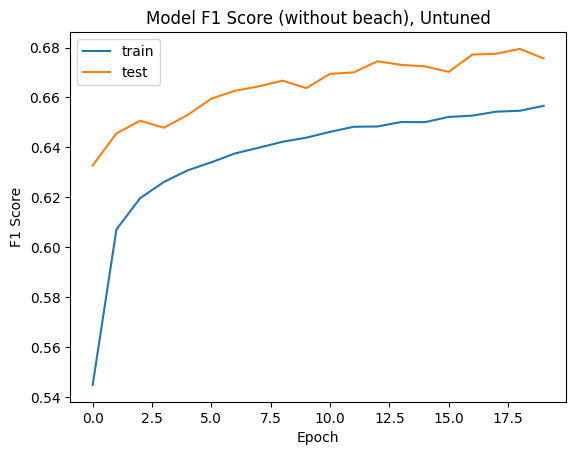

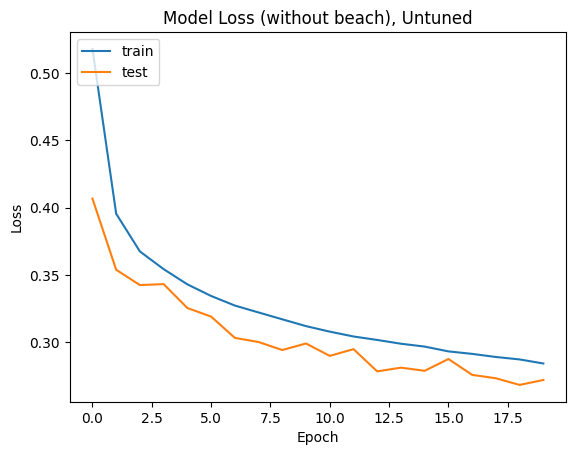

6/6 [==============================] - 0s 10ms/step
Evaluation report (no beach):
{'accuracy': 0.9212567053585364, 'f1-FIX': 0.9542717065683931, 'f1-SACC': 0.8962210559776265, 'f1-SP': 0.5568552387156396, 'f1-NOISE': 0.7818582126595243}
Testing with video: breite_strasse
Total amount of windows:  51829
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_3 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_3 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________

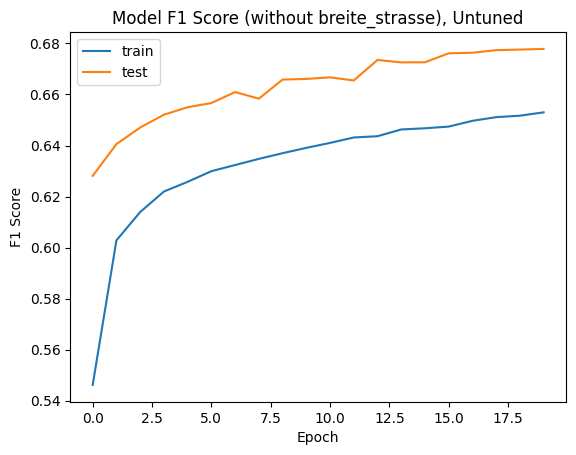

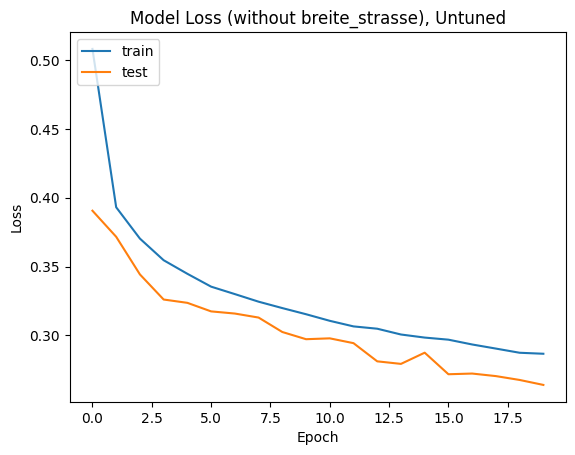

6/6 [==============================] - 0s 10ms/step
Evaluation report (no breite_strasse):
{'accuracy': 0.9236063136395039, 'f1-FIX': 0.9524641433688403, 'f1-SACC': 0.899627270287563, 'f1-SP': 0.8262845811703617, 'f1-NOISE': 0.7877029084627887}
Testing with video: bridge_1
Total amount of windows:  51949
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_4 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_4 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_______

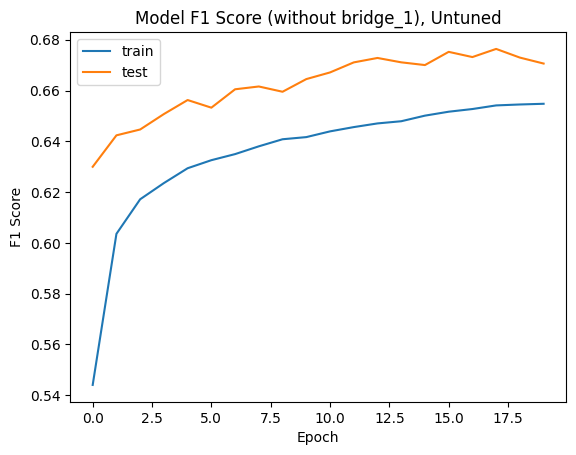

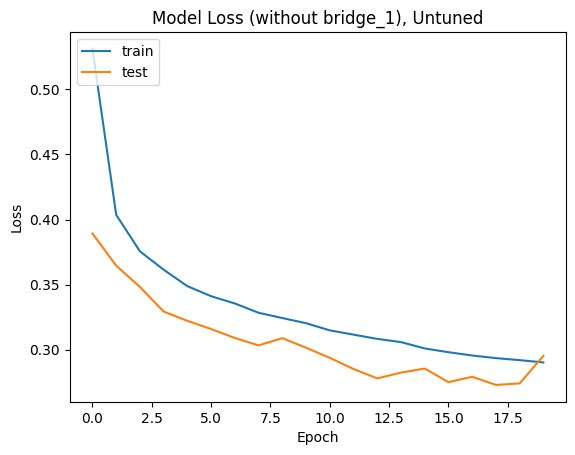

6/6 [==============================] - 0s 10ms/step
Evaluation report (no bridge_1):
{'accuracy': 0.9499631422319816, 'f1-FIX': 0.9740054466588597, 'f1-SACC': 0.8886762219768097, 'f1-SP': 0.0, 'f1-NOISE': 0.7093416124651424}
Testing with video: bridge_2
Total amount of windows:  51817
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_5 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_5 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
___________________________

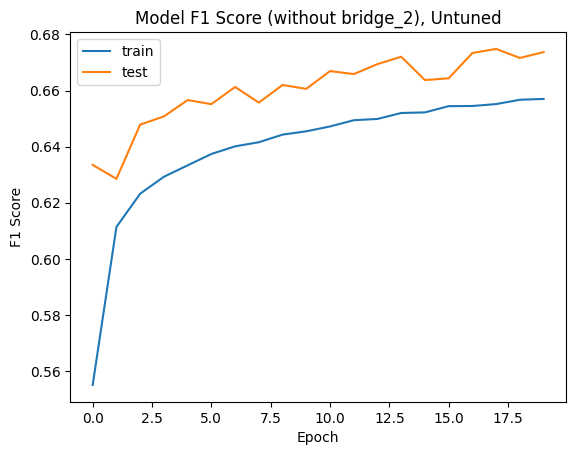

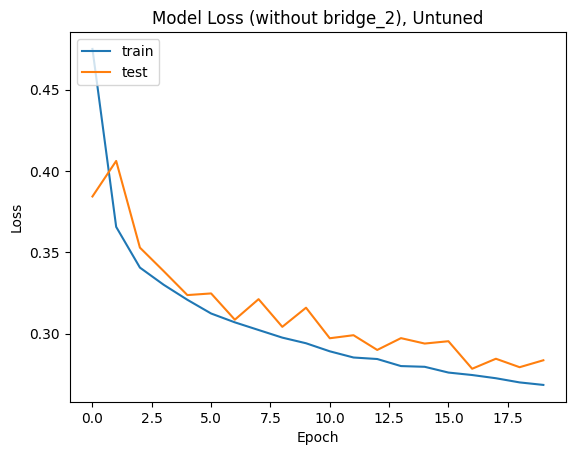

6/6 [==============================] - 0s 10ms/step
Evaluation report (no bridge_2):
{'accuracy': 0.8285813890721526, 'f1-FIX': 0.8781064458343337, 'f1-SACC': 0.8721759183524171, 'f1-SP': 0.6558092789062556, 'f1-NOISE': 0.7627800818443212}
Testing with video: bumblebee
Total amount of windows:  52382
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_6 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_6 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
___________

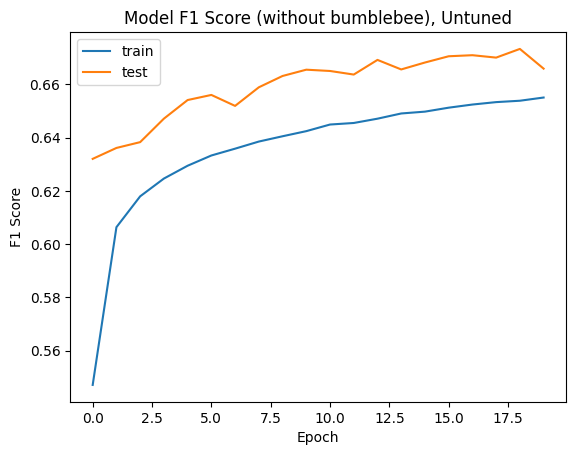

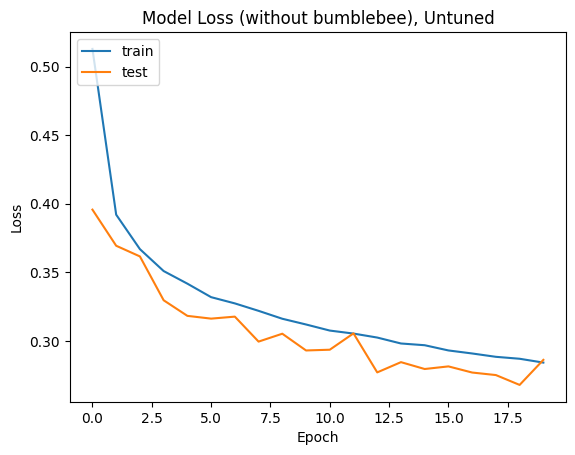

5/5 [==============================] - 0s 10ms/step
Evaluation report (no bumblebee):
{'accuracy': 0.9235000921360738, 'f1-FIX': 0.9574512323977689, 'f1-SACC': 0.8850710687598139, 'f1-SP': 0.7372703526815615, 'f1-NOISE': 0.6961071349801149}
Testing with video: doves
Total amount of windows:  52212
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_7 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_7 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
______________

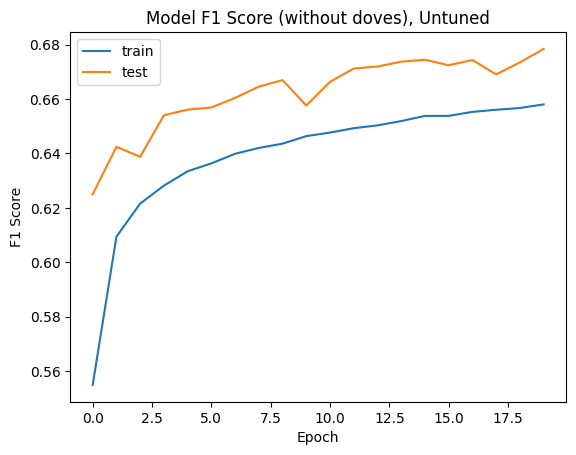

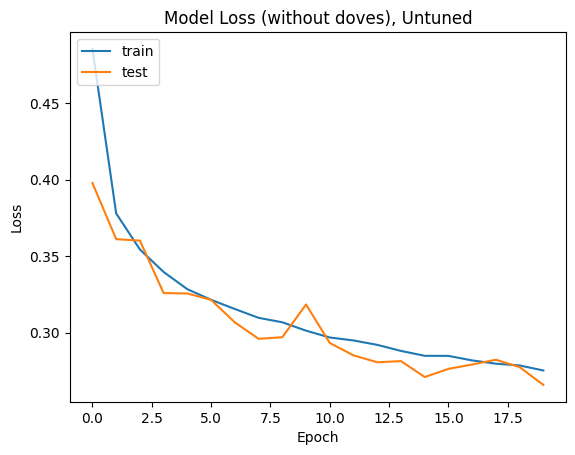

5/5 [==============================] - 0s 10ms/step
Evaluation report (no doves):
{'accuracy': 0.8661416988039407, 'f1-FIX': 0.9153902358571436, 'f1-SACC': 0.88363616140966, 'f1-SP': 0.700707122918146, 'f1-NOISE': 0.6293652695705286}
Testing with video: ducks_boat
Total amount of windows:  52201
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_8 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_8 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
________________

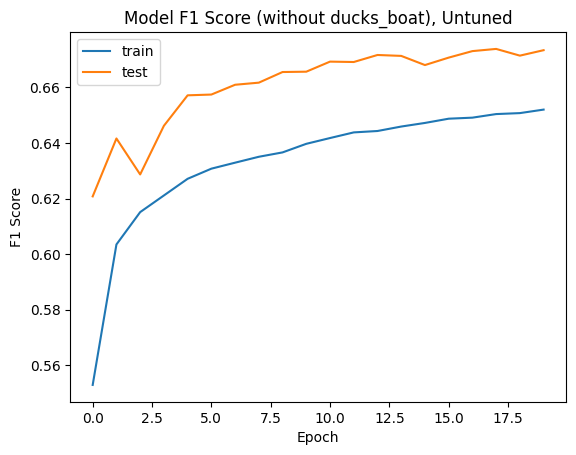

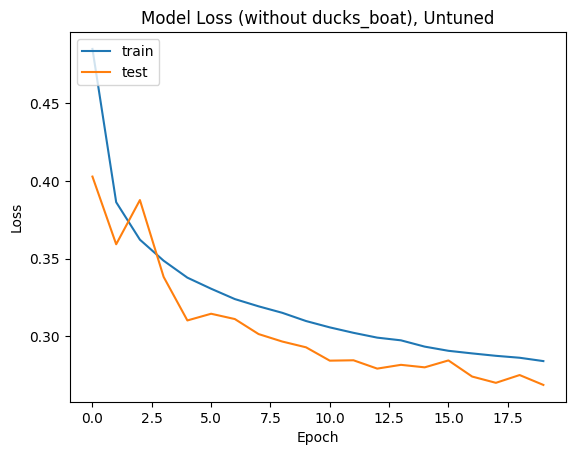

5/5 [==============================] - 0s 10ms/step
Evaluation report (no ducks_boat):
{'accuracy': 0.910357271743053, 'f1-FIX': 0.9417644030459057, 'f1-SACC': 0.8938796500641362, 'f1-SP': 0.8562975520129726, 'f1-NOISE': 0.6762610816697712}
Testing with video: ducks_children
Total amount of windows:  51947
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_9 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_9 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_____

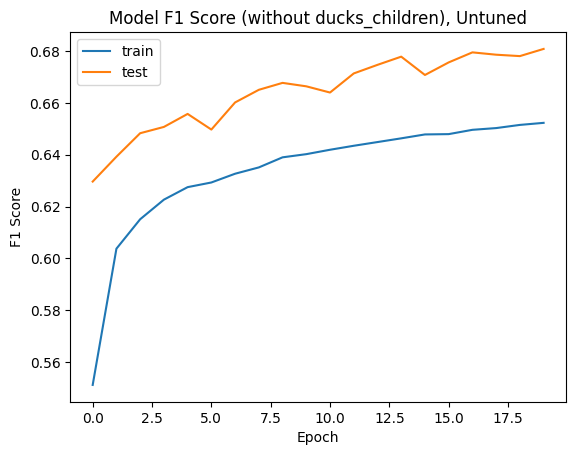

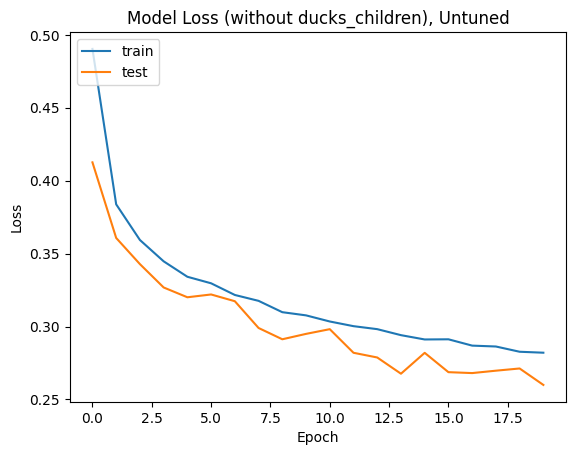

6/6 [==============================] - 0s 10ms/step
Evaluation report (no ducks_children):
{'accuracy': 0.9016891562030112, 'f1-FIX': 0.9356164484060084, 'f1-SACC': 0.8819612206293805, 'f1-SP': 0.8248125769326079, 'f1-NOISE': 0.7492301943079265}
Testing with video: golf
Total amount of windows:  52265
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_10 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_10 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________

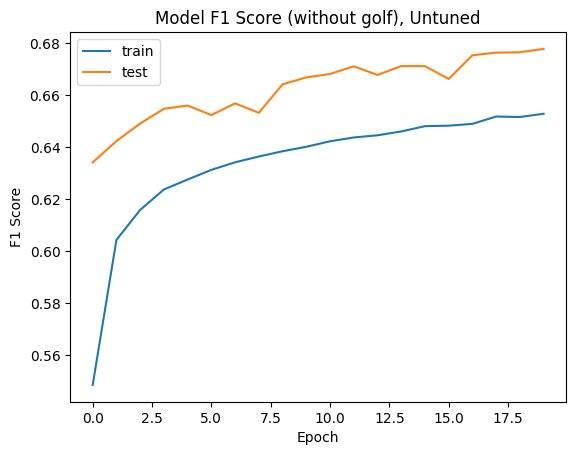

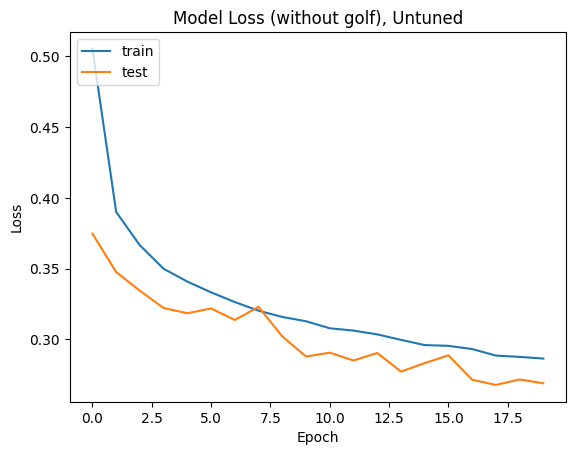

5/5 [==============================] - 0s 10ms/step
Evaluation report (no golf):
{'accuracy': 0.9209856743460263, 'f1-FIX': 0.9503113653663495, 'f1-SACC': 0.9056240979745527, 'f1-SP': 0.795247375133753, 'f1-NOISE': 0.821834447114648}
Testing with video: holsten_gate
Total amount of windows:  52204
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_11 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_11 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_____________

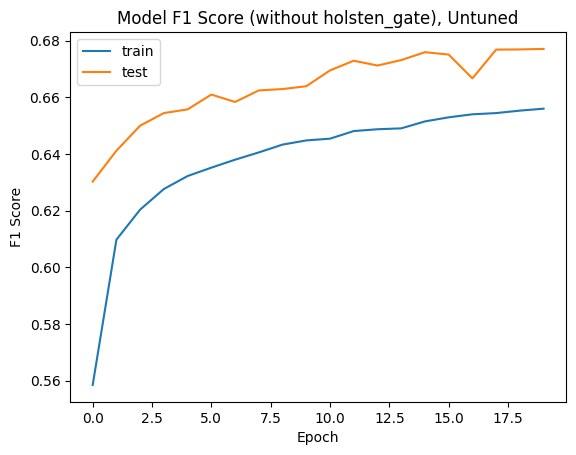

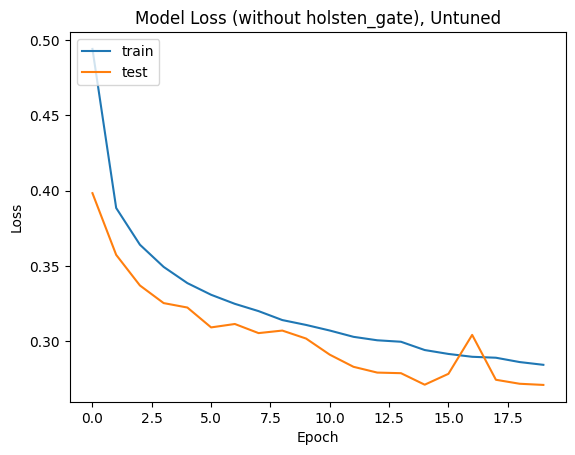

5/5 [==============================] - 0s 10ms/step
Evaluation report (no holsten_gate):
{'accuracy': 0.9270958973923384, 'f1-FIX': 0.95942992178808, 'f1-SACC': 0.9005172676398913, 'f1-SP': 0.589442073080513, 'f1-NOISE': 0.6756273974884446}
Testing with video: koenigstrasse
Total amount of windows:  52164
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_12 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_12 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_____

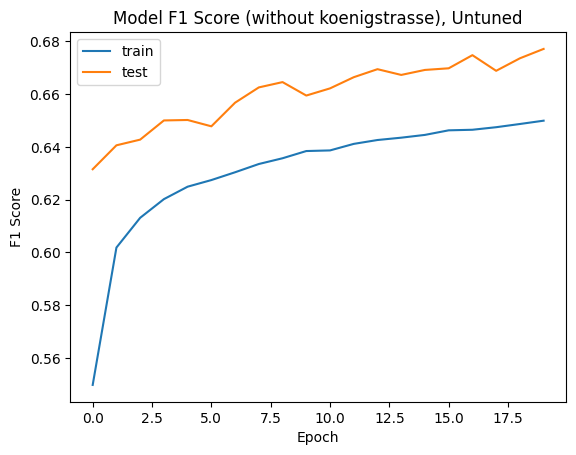

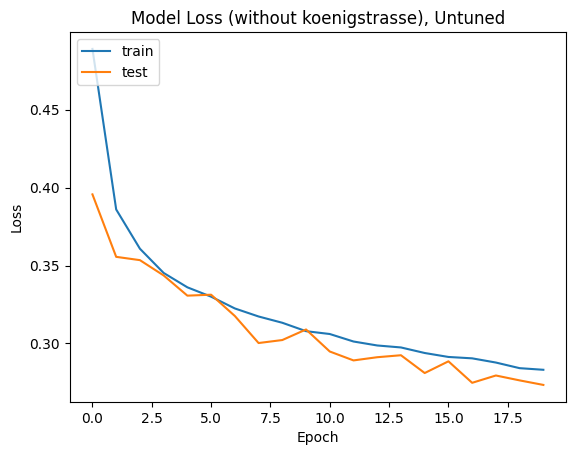

6/6 [==============================] - 0s 10ms/step
Evaluation report (no koenigstrasse):
{'accuracy': 0.9094524575218611, 'f1-FIX': 0.9359648927879367, 'f1-SACC': 0.9053736102524882, 'f1-SP': 0.8736927431027135, 'f1-NOISE': 0.7655608261824945}
Testing with video: puppies
Total amount of windows:  52270
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_13 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_13 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_______

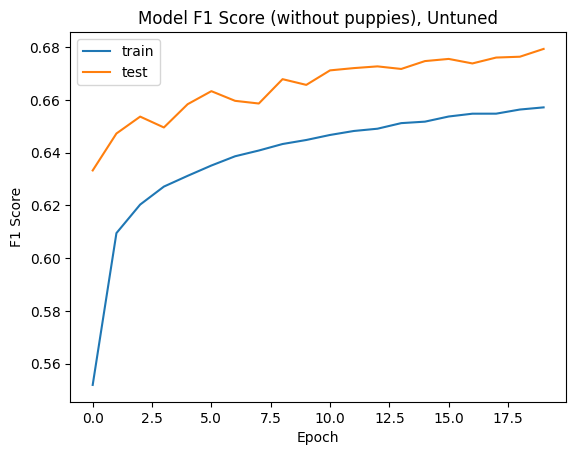

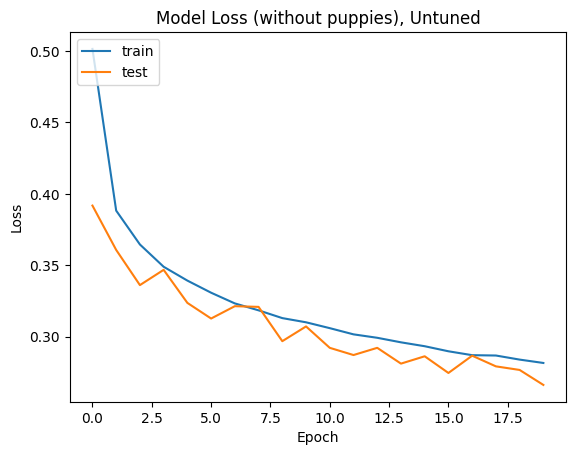

5/5 [==============================] - 0s 10ms/step
Evaluation report (no puppies):
{'accuracy': 0.8890415872563129, 'f1-FIX': 0.9335020475813133, 'f1-SACC': 0.900381449420677, 'f1-SP': 0.4907606381769338, 'f1-NOISE': 0.7253457901944084}
Testing with video: roundabout
Total amount of windows:  52013
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_14 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_14 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
___________

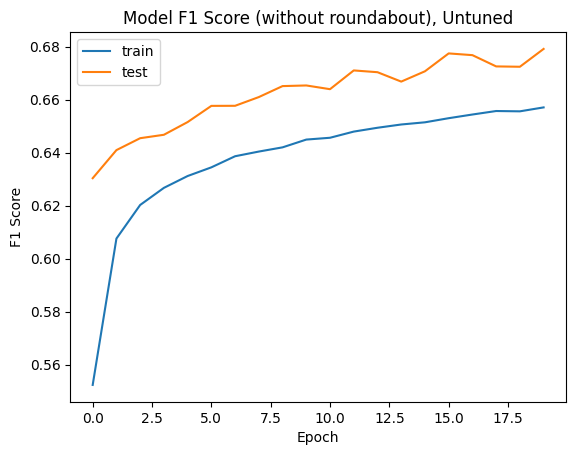

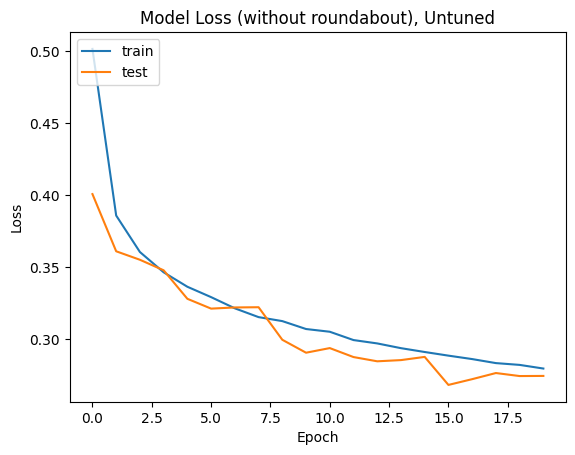

6/6 [==============================] - 0s 10ms/step
Evaluation report (no roundabout):
{'accuracy': 0.8983835564955601, 'f1-FIX': 0.9370990925196255, 'f1-SACC': 0.9174959809996186, 'f1-SP': 0.5846833859755669, 'f1-NOISE': 0.7443865308946559}
Testing with video: sea
Total amount of windows:  52752
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_15 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_15 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
______________

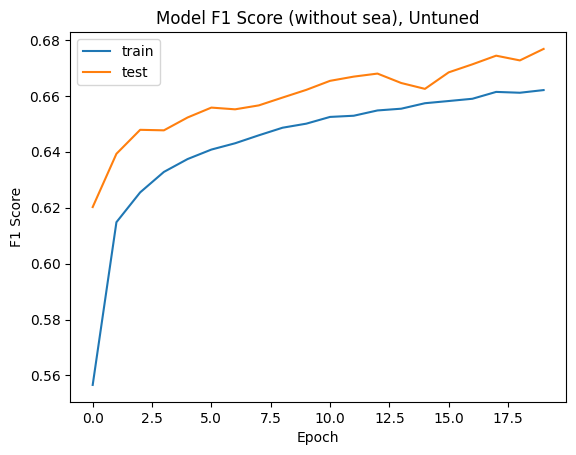

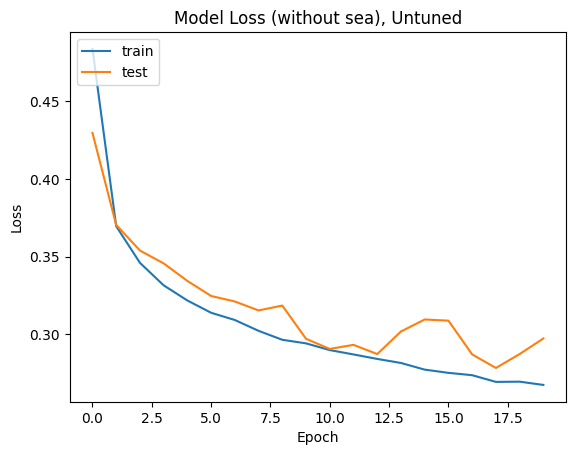

5/5 [==============================] - 0s 10ms/step
Evaluation report (no sea):
{'accuracy': 0.8605276493644834, 'f1-FIX': 0.9229158766512405, 'f1-SACC': 0.8607224390522772, 'f1-SP': 0.29256757783731996, 'f1-NOISE': 0.4621305817140973}
Testing with video: st_petri_gate
Total amount of windows:  51946
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_16 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_16 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
__________

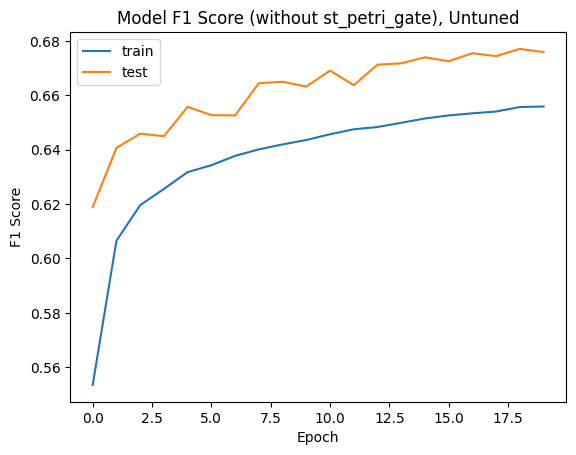

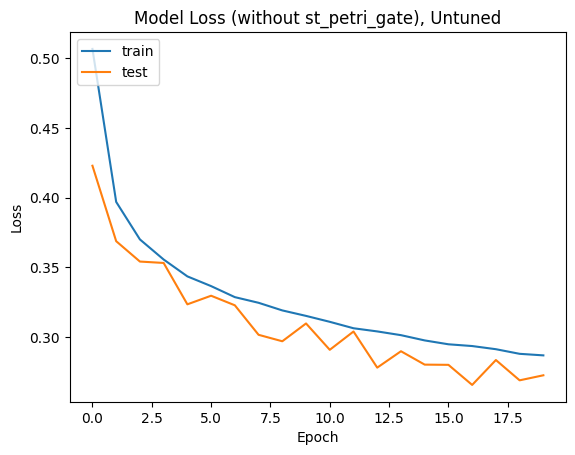

6/6 [==============================] - 0s 10ms/step
Evaluation report (no st_petri_gate):
{'accuracy': 0.9368861929520509, 'f1-FIX': 0.9658473790694001, 'f1-SACC': 0.9012559049806191, 'f1-SP': 0.41201210402809096, 'f1-NOISE': 0.6893056688912872}
Testing with video: st_petri_market
Total amount of windows:  52266
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_17 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_17 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 

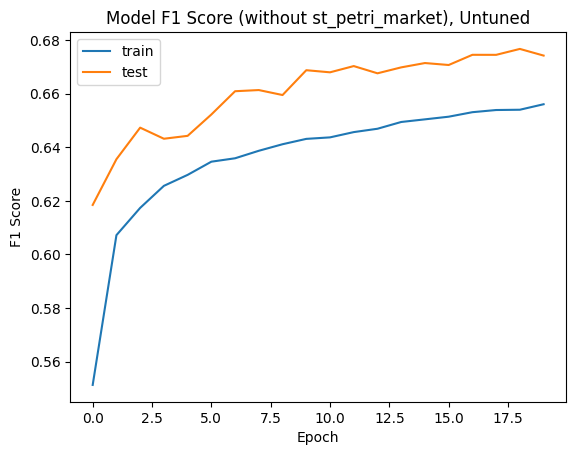

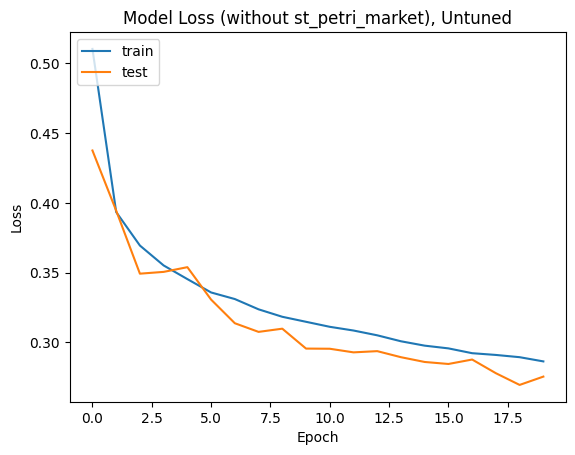

5/5 [==============================] - 0s 10ms/step
Evaluation report (no st_petri_market):
{'accuracy': 0.9336094007458157, 'f1-FIX': 0.964372070956277, 'f1-SACC': 0.8882134918864413, 'f1-SP': 0.4499043487639207, 'f1-NOISE': 0.7104175304990236}
Testing with video: st_petri_mcdonalds
Total amount of windows:  52527
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_18 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_18 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable param

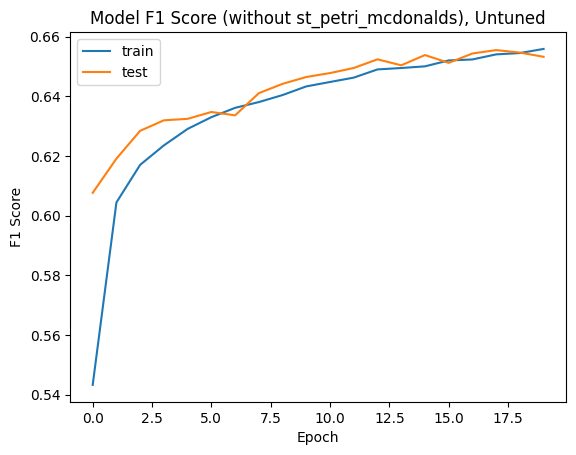

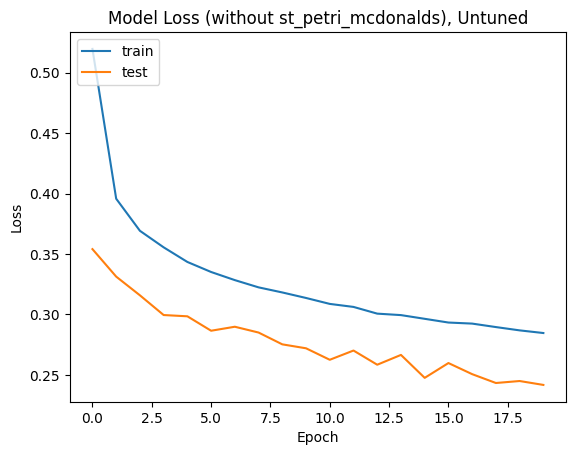

5/5 [==============================] - 0s 10ms/step
Evaluation report (no st_petri_mcdonalds):
{'accuracy': 0.8999000856408792, 'f1-FIX': 0.9377903727253776, 'f1-SACC': 0.9019036949178446, 'f1-SP': 0.682408342321547, 'f1-NOISE': 0.7284961872377004}
Testing with video: street
Total amount of windows:  51910
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_19 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_19 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
____

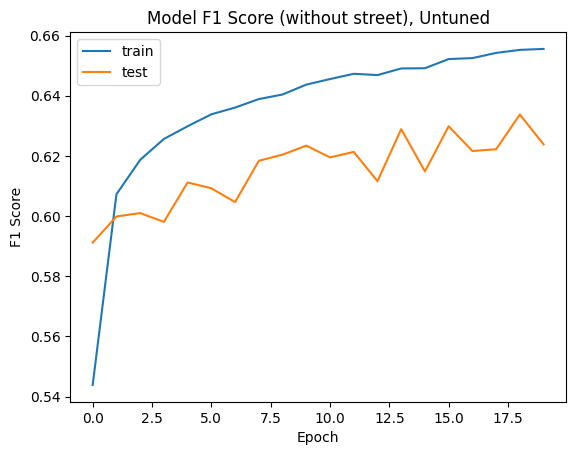

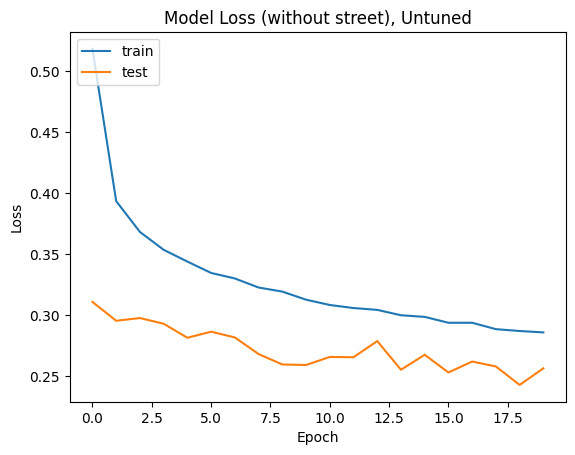

6/6 [==============================] - 1s 11ms/step
Evaluation report (no street):
{'accuracy': 0.905332627110453, 'f1-FIX': 0.9399635064813137, 'f1-SACC': 0.8706854448955192, 'f1-SP': 0.857537546133308, 'f1-NOISE': 0.7525574007937708}
time: 1h 23min 4s (started: 2023-07-03 17:02:27 +00:00)


In [ ]:
for i, video_name in enumerate(video_names):
    print("Testing with video: " + video_name)
    r = np.random.RandomState(0)
    train_set_len = sum([len(windows_x[j]) for j in range(len(windows_x)) if j != i])
    print('Total amount of windows: ', train_set_len)

    perm = r.permutation(train_set_len)[:50000]
    train_x = []
    train_y = []

    indices_range_low = 0
    for j in range(len(windows_x)):
        if j == i:
            continue
        indices_range_high = indices_range_low + len(windows_x[j])
        local_indices = perm[(perm >= indices_range_low) * (perm < indices_range_high)]
        local_indices -= indices_range_low

        train_x.append(windows_x[j][local_indices])
        train_y.append(windows_y[j][local_indices])

        indices_range_low = indices_range_high

    train_x = np.concatenate(train_x)
    train_y = np.concatenate(train_y)

    model = create_model(
        num_classes = 5,
        train_data_shape = train_x.shape,
        dropout_rate = 0.3,
        nb_filters = 128,
        nb_stacks = 1,
        kernel_size = 8,
        dilation_count = 8,
        padding_mode = 'same',
    )
    print('Total amount of windows: ', len(train_x))
    assert train_x.shape[0] == train_y.shape[0]
    assert train_x.shape[0] == 50000

    history = model.fit(
        train_x, train_y,
        epochs = 20,
        batch_size = 128,
        shuffle = True,
        validation_split = 0.1,
        verbose = 1,
        initial_epoch = 0
    )

    print('Saving model..')
    model.save('/content/drive/MyDrive/Skripsi/gazecom_sdsd7_window_385_no_{}_untuned_final.h5'.format(video_name))

    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model F1 Score (without {}), Untuned'.format(video_name))
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss (without {}), Untuned'.format(video_name))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    raw, preprocessed = evaluate_test_lovo(
        model,
        data_X[i],
        data_Y_one_hot[i],
        keys_to_subtract_start_indices = [],
        padding_features = padding_features,
    )
    print('Evaluation report (no {}):'.format(video_name))
    print(preprocessed)

6/6 [==============================] - 9s 26ms/step
Evaluating for video beach
f1-FIX 0.9511187644382545
f1-SACC 0.8965601566343672
f1-SP 0.5595602585119381
f1-NOISE 0.7579488219437913
f1 score: 0.8330375
6/6 [==============================] - 1s 29ms/step
Evaluating for video breite_strasse
f1-FIX 0.9520833864647926
f1-SACC 0.8951765003914053
f1-SP 0.8280464217882112
f1-NOISE 0.7814364610472405
f1 score: 0.8913485
6/6 [==============================] - 1s 27ms/step
Evaluating for video bridge_1
f1-FIX 0.9721132559008899
f1-SACC 0.8875829462603173
f1-SP 0.0
f1-NOISE 0.7109557499190334
f1 score: 0.7141303
6/6 [==============================] - 1s 28ms/step
Evaluating for video bridge_2
f1-FIX 0.8839228638108141
f1-SACC 0.8719380767056084
f1-SP 0.7163657045887702
f1-NOISE 0.7459861299967898
f1 score: 0.8436425
5/5 [==============================] - 1s 28ms/step
Evaluating for video bumblebee
f1-FIX 0.957120986945504
f1-SACC 0.8796773299503379
f1-SP 0.7525391928673962
f1-NOISE 0.678201460

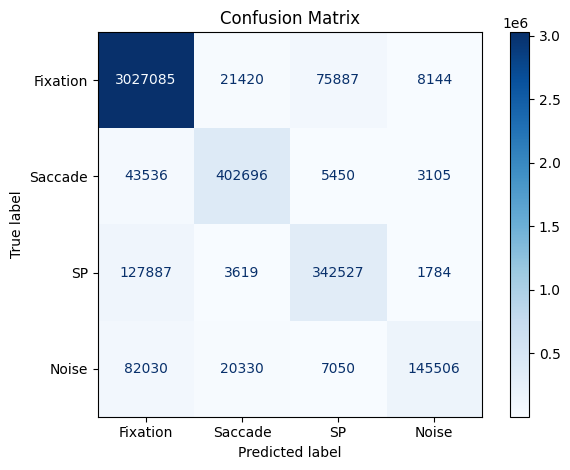

time: 1min 4s (started: 2023-07-03 15:55:39 +00:00)


In [ ]:
results = {
    'accuracy': [],
    'f1-SP': [],
    'f1-FIX': [],
    'f1-SACC': [],
    'f1-NOISE': [],
    'f1_score': [],
}
raw_results = {'true': [], 'pred': []}

for i, video_name in enumerate(video_names):
  model = tf.keras.models.load_model('/content/drive/MyDrive/Skripsi/gazecom_sdsd7_window_385_no_{}_untuned.h5'.format(video_name),
                                   custom_objects= {'f1_score': f1_score, 'f1_SP': f1_SP, 'f1_SACC': f1_SACC, 'f1_FIX': f1_FIX, 'f1_NOISE': f1_NOISE, 'TCN':TCN})
  raw, preprocessed = evaluate_test_lovo(
      model,
      data_X[i],
      data_Y_one_hot[i],
      keys_to_subtract_start_indices = [],
      padding_features = padding_features,
  )

  for k in raw_results.keys():
      raw_results[k].append(np.concatenate(raw[k], axis=0))
  for k in results.keys():
      results[k].append(preprocessed[k])

  print ('Evaluating for video', video_name)
  for stat_name in ['FIX', 'SACC', 'SP', 'NOISE']:
      print ('f1-{}'.format(stat_name), results['f1-{}'.format(stat_name)][-1])
  print('f1 score: {}'.format(results['f1_score'][-1]))

raw_results['true'] = np.concatenate(raw_results['true'])
raw_results['pred'] = np.concatenate(raw_results['pred'])

mask = np.argmax(raw_results['true'], axis=-1) != 0
print ('Found', np.logical_not(mask).sum(), 'UNKNOWN samples in the raw ``true\'\' predictions ' \
                                            '(including the artificially padded parts of the last windows ' \
                                            'in each sequence, in order to match window width)')

print (raw_results['true'].shape, raw_results['pred'].shape)

unknown_class_mask = raw_results['true'][:, :, 0] == 1  # count "unknown"s in the one-hot-encoded true labels

print ('Overall classification scores per class:')
for stat_i, stat_name in zip(range(1, 5), ['FIX', 'SACC', 'SP', 'NOISE']):
    results['overall-F1-{}'.format(stat_name)] = K.eval(categorical_f1_score_for_class(raw_results['true'],
                                                                                        raw_results['pred'],
                                                                                        stat_i,
                                                                                        'float64'))
    print ('F1-{}'.format(stat_name), results['overall-F1-{}'.format(stat_name)])

results['overall-F1_score'] = float(str(f1_score(raw_results['true'], raw_results['pred']))[10:19])

results['overall-acc'] = np.mean(np.argmax(raw_results['true'][np.logical_not(unknown_class_mask)], axis=-1) ==
                                  np.argmax(raw_results['pred'][np.logical_not(unknown_class_mask)], axis=-1))

print('overall-F1_score', results['overall-F1_score'])
print('overall-Accuracy', results['overall-acc'])

plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(np.argmax(raw_results['true'][np.logical_not(unknown_class_mask)], axis=-1), np.argmax(raw_results['pred'][np.logical_not(unknown_class_mask)], axis=-1)), display_labels=['Fixation', 'Saccade', 'SP', 'Noise'])
disp.plot(cmap='Blues', values_format='')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

[Text(0.5, 1.0, 'Confusion Matrix for Untuned TCN Model')]

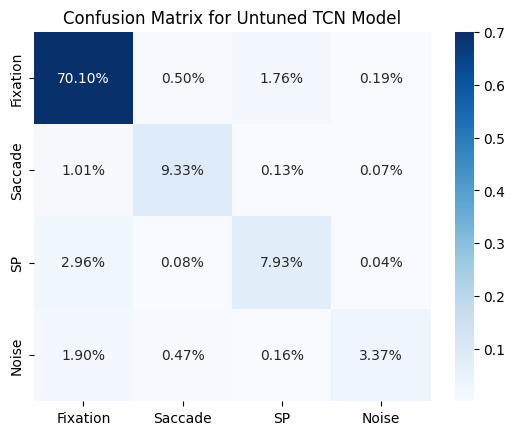

time: 3.02 s (started: 2023-07-03 15:56:43 +00:00)


In [ ]:
import seaborn as sns
labels = ['Fixation', 'Saccade', 'SP', 'Noise']
conf_matrix = confusion_matrix(np.argmax(raw_results['true'][np.logical_not(unknown_class_mask)], axis=-1), np.argmax(raw_results['pred'][np.logical_not(unknown_class_mask)], axis=-1))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot = True, fmt = '.2%', cmap = 'Blues', xticklabels = labels, yticklabels = labels).set(title = 'Confusion Matrix for Untuned TCN Model')

6/6 [==============================] - 1s 11ms/step
Evaluating for video beach
f1-FIX 0.9542717065683931
f1-SACC 0.8962210559776265
f1-SP 0.5568552387156396
f1-NOISE 0.7818582126595243
f1 score: 0.8378412
6/6 [==============================] - 1s 11ms/step
Evaluating for video breite_strasse
f1-FIX 0.9524641433688403
f1-SACC 0.899627270287563
f1-SP 0.8262845811703617
f1-NOISE 0.7877029084627887
f1 score: 0.8932157
6/6 [==============================] - 1s 12ms/step
Evaluating for video bridge_1
f1-FIX 0.9740054466588597
f1-SACC 0.8886762219768097
f1-SP 0.0
f1-NOISE 0.7093416124651424
f1 score: 0.7144046
6/6 [==============================] - 1s 11ms/step
Evaluating for video bridge_2
f1-FIX 0.8781064458343337
f1-SACC 0.8721759183524171
f1-SP 0.6558092789062556
f1-NOISE 0.7627800818443212
f1 score: 0.8337743
5/5 [==============================] - 1s 11ms/step
Evaluating for video bumblebee
f1-FIX 0.9574512323977689
f1-SACC 0.8850710687598139
f1-SP 0.7372703526815615
f1-NOISE 0.696107134

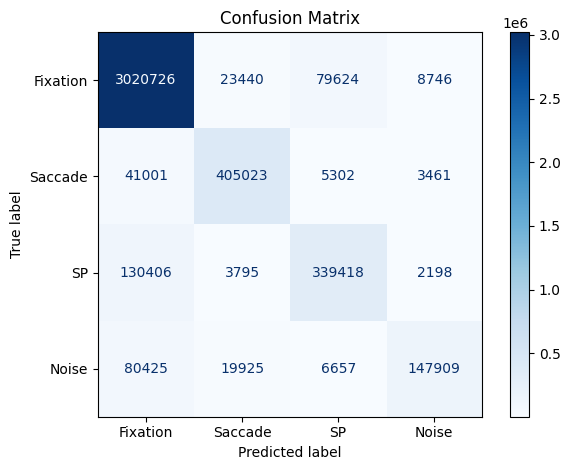

time: 1min 1s (started: 2023-07-03 18:27:15 +00:00)


In [ ]:
results = {
    'accuracy': [],
    'f1-SP': [],
    'f1-FIX': [],
    'f1-SACC': [],
    'f1-NOISE': [],
    'f1_score': [],
}
raw_results = {'true': [], 'pred': []}

for i, video_name in enumerate(video_names):
  model = tf.keras.models.load_model('/content/drive/MyDrive/Skripsi/gazecom_sdsd7_window_385_no_{}_untuned_final.h5'.format(video_name),
                                   custom_objects= {'f1_score': f1_score, 'f1_SP': f1_SP, 'f1_SACC': f1_SACC, 'f1_FIX': f1_FIX, 'f1_NOISE': f1_NOISE, 'TCN':TCN})
  raw, preprocessed = evaluate_test_lovo(
      model,
      data_X[i],
      data_Y_one_hot[i],
      keys_to_subtract_start_indices = [],
      padding_features = padding_features,
  )

  for k in raw_results.keys():
      raw_results[k].append(np.concatenate(raw[k], axis=0))
  for k in results.keys():
      results[k].append(preprocessed[k])

  print ('Evaluating for video', video_name)
  for stat_name in ['FIX', 'SACC', 'SP', 'NOISE']:
      print ('f1-{}'.format(stat_name), results['f1-{}'.format(stat_name)][-1])
  print('f1 score: {}'.format(results['f1_score'][-1]))

raw_results['true'] = np.concatenate(raw_results['true'])
raw_results['pred'] = np.concatenate(raw_results['pred'])

mask = np.argmax(raw_results['true'], axis=-1) != 0
print ('Found', np.logical_not(mask).sum(), 'UNKNOWN samples in the raw ``true\'\' predictions ' \
                                            '(including the artificially padded parts of the last windows ' \
                                            'in each sequence, in order to match window width)')

print (raw_results['true'].shape, raw_results['pred'].shape)

unknown_class_mask = raw_results['true'][:, :, 0] == 1  # count "unknown"s in the one-hot-encoded true labels

print ('Overall classification scores per class:')
for stat_i, stat_name in zip(range(1, 5), ['FIX', 'SACC', 'SP', 'NOISE']):
    results['overall-F1-{}'.format(stat_name)] = K.eval(categorical_f1_score_for_class(raw_results['true'],
                                                                                        raw_results['pred'],
                                                                                        stat_i,
                                                                                        'float64'))
    print ('F1-{}'.format(stat_name), results['overall-F1-{}'.format(stat_name)])

results['overall-F1_score'] = float(str(f1_score(raw_results['true'], raw_results['pred']))[10:19])

results['overall-acc'] = np.mean(np.argmax(raw_results['true'][np.logical_not(unknown_class_mask)], axis=-1) ==
                                  np.argmax(raw_results['pred'][np.logical_not(unknown_class_mask)], axis=-1))

print('overall-F1_score', results['overall-F1_score'])
print('overall-Accuracy', results['overall-acc'])

plt.style.use('default')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(np.argmax(raw_results['true'][np.logical_not(unknown_class_mask)], axis=-1), np.argmax(raw_results['pred'][np.logical_not(unknown_class_mask)], axis=-1)), display_labels=['Fixation', 'Saccade', 'SP', 'Noise'])
disp.plot(cmap='Blues', values_format='')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

[Text(0.5, 1.0, 'Confusion Matrix for Untuned TCN Model')]

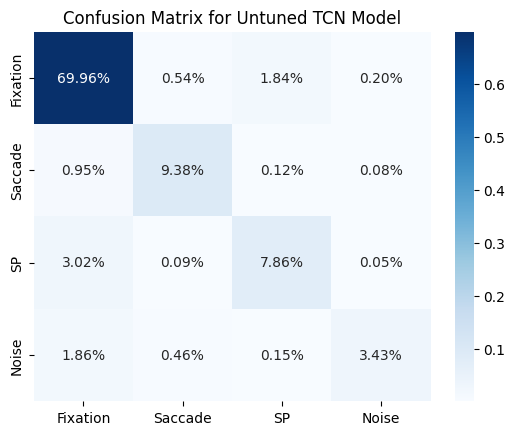

time: 2.95 s (started: 2023-07-03 18:29:36 +00:00)


In [ ]:
import seaborn as sns
labels = ['Fixation', 'Saccade', 'SP', 'Noise']
conf_matrix = confusion_matrix(np.argmax(raw_results['true'][np.logical_not(unknown_class_mask)], axis=-1), np.argmax(raw_results['pred'][np.logical_not(unknown_class_mask)], axis=-1))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot = True, fmt = '.2%', cmap = 'Blues', xticklabels = labels, yticklabels = labels).set(title = 'Confusion Matrix for Untuned TCN Model')

In [ ]:
from google.colab import runtime
runtime.unassign()

#### Training Number 2 (LOVO Tuned)

Testing with video: beach
Total amount of windows:  52103
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn (TCN)                   (None, 385, 128)          1922432   
                                                                 
 time_distributed (TimeDistr  (None, 385, 5)           645       
 ibuted)                                                         
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
_________________________________________________________________
Total amount of windows:  50000
Epoch 1/20
352/352 [==============================] - 45s 59ms/step - loss: 0.4242 - accuracy: 0.8616 - f1_score: 0.5812 - f1_SP: 0.5554 - f1_FIX: 0.9171 - f1_

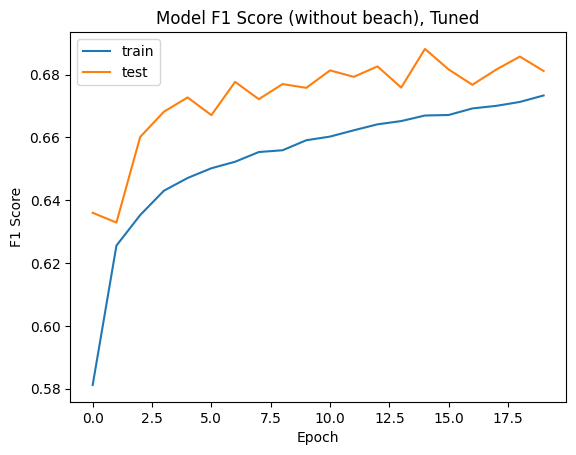

6/6 [==============================] - 1s 13ms/step
Evaluation report (no beach):
{'accuracy': 0.9264484806663874, 'f1-FIX': 0.9578319338362072, 'f1-SACC': 0.9065977486847263, 'f1-SP': 0.5862734715183182, 'f1-NOISE': 0.7701697012594192}
Testing with video: breite_strasse
Total amount of windows:  51829
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_1 (TCN)                 (None, 385, 128)          1922432   
                                                                 
 time_distributed_1 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
_________

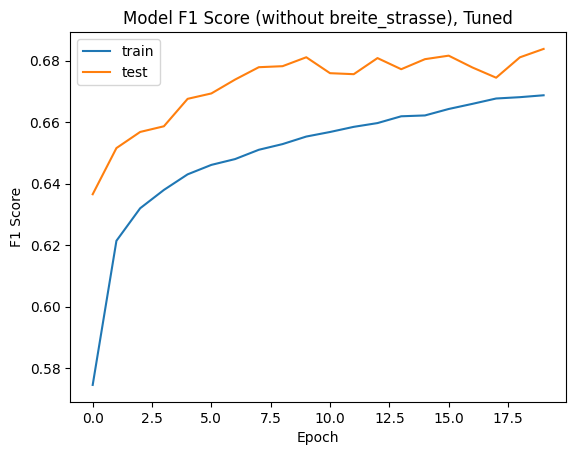

6/6 [==============================] - 1s 13ms/step
Evaluation report (no breite_strasse):
{'accuracy': 0.9301091821103535, 'f1-FIX': 0.9567794804173804, 'f1-SACC': 0.9095395396527798, 'f1-SP': 0.8433434848717969, 'f1-NOISE': 0.7948575817263378}
Testing with video: bridge_1
Total amount of windows:  51949
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_2 (TCN)                 (None, 385, 128)          1922432   
                                                                 
 time_distributed_2 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
______

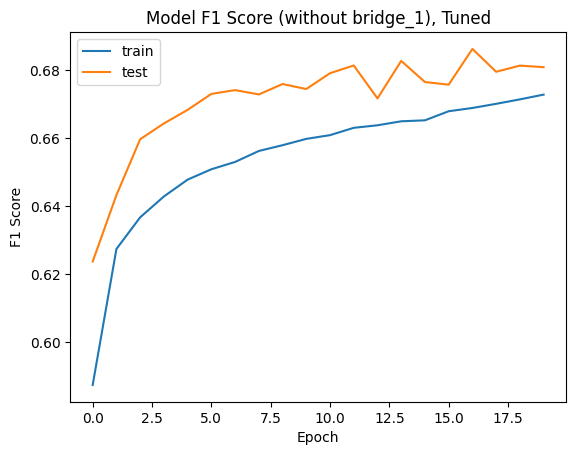

6/6 [==============================] - 1s 13ms/step
Evaluation report (no bridge_1):
{'accuracy': 0.9520966024548444, 'f1-FIX': 0.975091088438947, 'f1-SACC': 0.9019871122366521, 'f1-SP': 0.0, 'f1-NOISE': 0.710801861671971}
Testing with video: bridge_2
Total amount of windows:  51817
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_3 (TCN)                 (None, 385, 128)          1922432   
                                                                 
 time_distributed_3 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
_____________________________

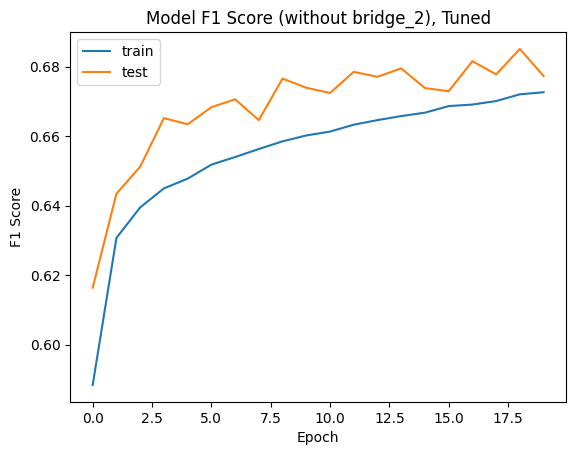

6/6 [==============================] - 1s 13ms/step
Evaluation report (no bridge_2):
{'accuracy': 0.8331171654771187, 'f1-FIX': 0.8801562095849849, 'f1-SACC': 0.882288778341877, 'f1-SP': 0.6815805025339435, 'f1-NOISE': 0.7498678960588809}
Testing with video: bumblebee
Total amount of windows:  52382
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_4 (TCN)                 (None, 385, 128)          1922432   
                                                                 
 time_distributed_4 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
____________

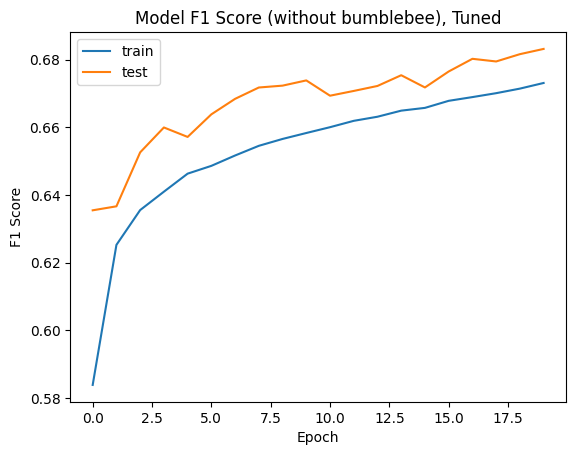

5/5 [==============================] - 1s 14ms/step
Evaluation report (no bumblebee):
{'accuracy': 0.903284089223675, 'f1-FIX': 0.9442226227929998, 'f1-SACC': 0.8935311414669694, 'f1-SP': 0.628473772648607, 'f1-NOISE': 0.6999287540337141}
Testing with video: doves
Total amount of windows:  52212
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_5 (TCN)                 (None, 385, 128)          1922432   
                                                                 
 time_distributed_5 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
________________

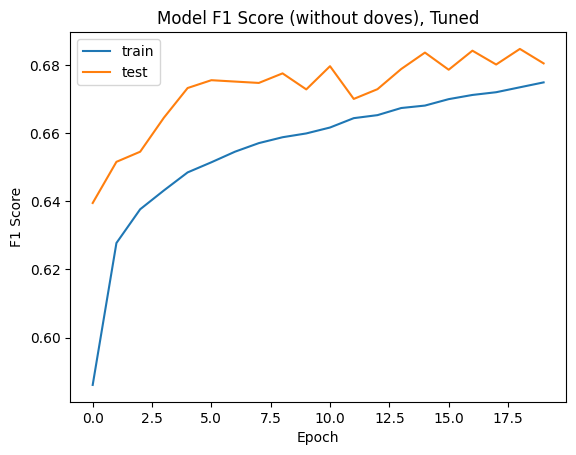

5/5 [==============================] - 1s 14ms/step
Evaluation report (no doves):
{'accuracy': 0.8649426631347554, 'f1-FIX': 0.9134427352958419, 'f1-SACC': 0.8919895919615244, 'f1-SP': 0.6922650468762909, 'f1-NOISE': 0.6347632006243126}
Testing with video: ducks_boat
Total amount of windows:  52201
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_6 (TCN)                 (None, 385, 128)          1922432   
                                                                 
 time_distributed_6 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
_____________

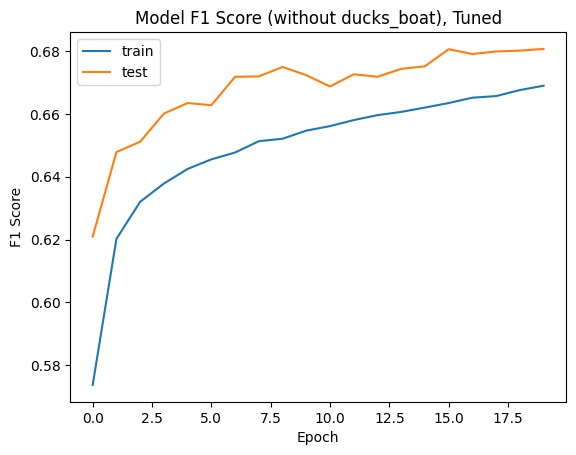

5/5 [==============================] - 1s 13ms/step
Evaluation report (no ducks_boat):
{'accuracy': 0.9126329420256013, 'f1-FIX': 0.9431105922980206, 'f1-SACC': 0.9072566441577704, 'f1-SP': 0.8511015896445139, 'f1-NOISE': 0.694055144497234}
Testing with video: ducks_children
Total amount of windows:  51947
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_7 (TCN)                 (None, 385, 128)          1922432   
                                                                 
 time_distributed_7 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
_____

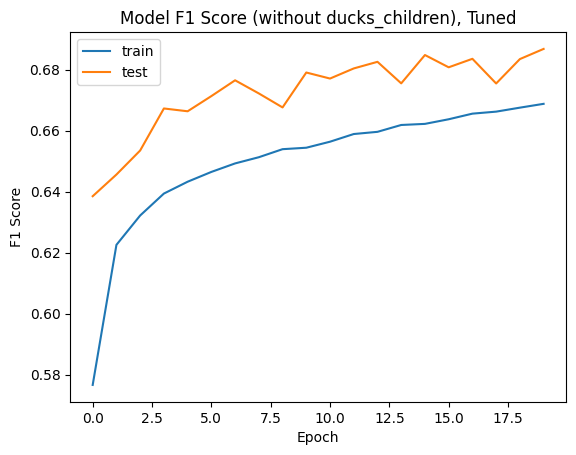

6/6 [==============================] - 1s 13ms/step
Evaluation report (no ducks_children):
{'accuracy': 0.906750766466832, 'f1-FIX': 0.9397398551410546, 'f1-SACC': 0.8910381147135902, 'f1-SP': 0.8373653332237753, 'f1-NOISE': 0.7388660735790984}
Testing with video: golf
Total amount of windows:  52265
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_8 (TCN)                 (None, 385, 128)          1922432   
                                                                 
 time_distributed_8 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
___________

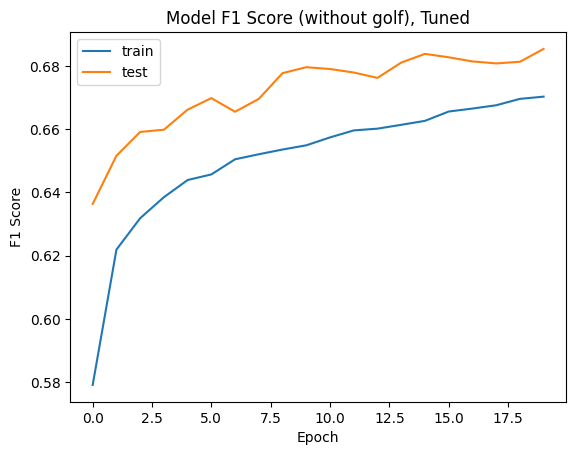

5/5 [==============================] - 1s 14ms/step
Evaluation report (no golf):
{'accuracy': 0.9220996510695477, 'f1-FIX': 0.9509464873090854, 'f1-SACC': 0.9184191311717159, 'f1-SP': 0.7953103417685067, 'f1-NOISE': 0.8345673884624826}
Testing with video: holsten_gate
Total amount of windows:  52204
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_9 (TCN)                 (None, 385, 128)          1922432   
                                                                 
 time_distributed_9 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
____________

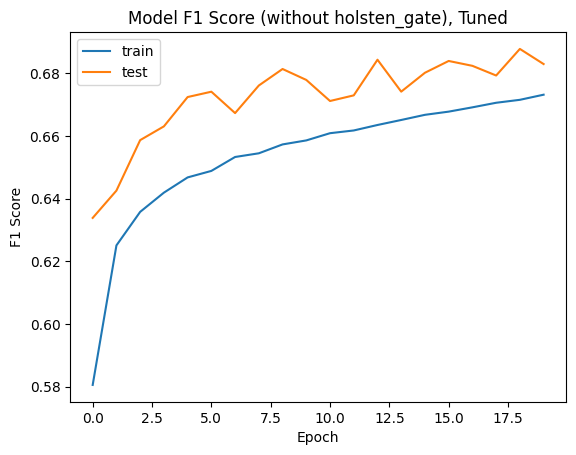

5/5 [==============================] - 1s 14ms/step
Evaluation report (no holsten_gate):
{'accuracy': 0.9264503525014864, 'f1-FIX': 0.9593246139259506, 'f1-SACC': 0.9069582754803325, 'f1-SP': 0.610504003843603, 'f1-NOISE': 0.6616517803949588}
Testing with video: koenigstrasse
Total amount of windows:  52164
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_10 (TCN)                (None, 385, 128)          1922432   
                                                                 
 time_distributed_10 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
___

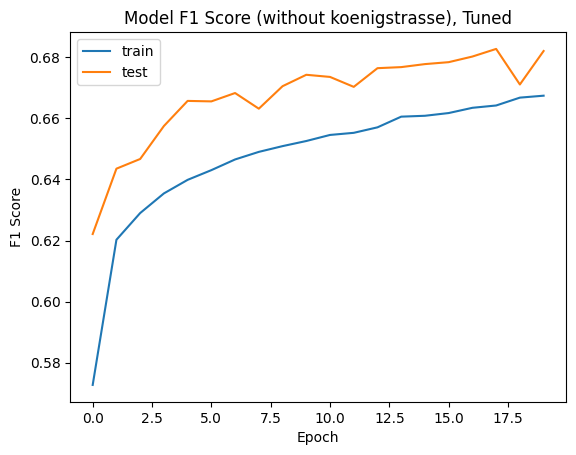

6/6 [==============================] - 1s 13ms/step
Evaluation report (no koenigstrasse):
{'accuracy': 0.9173563396243775, 'f1-FIX': 0.9435704399741823, 'f1-SACC': 0.9108286833741714, 'f1-SP': 0.8835743718678002, 'f1-NOISE': 0.7659919846442161}
Testing with video: puppies
Total amount of windows:  52270
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_11 (TCN)                (None, 385, 128)          1922432   
                                                                 
 time_distributed_11 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
_______

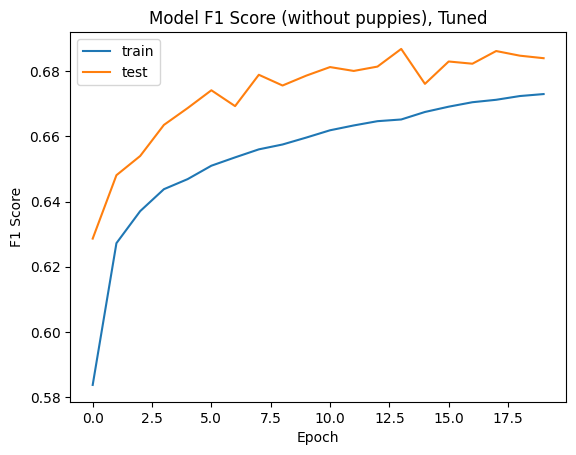

5/5 [==============================] - 1s 13ms/step
Evaluation report (no puppies):
{'accuracy': 0.9068554364220179, 'f1-FIX': 0.9453422149320296, 'f1-SACC': 0.9128850979538254, 'f1-SP': 0.5287347618685111, 'f1-NOISE': 0.7333363137009317}
Testing with video: roundabout
Total amount of windows:  52013
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_12 (TCN)                (None, 385, 128)          1922432   
                                                                 
 time_distributed_12 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
__________

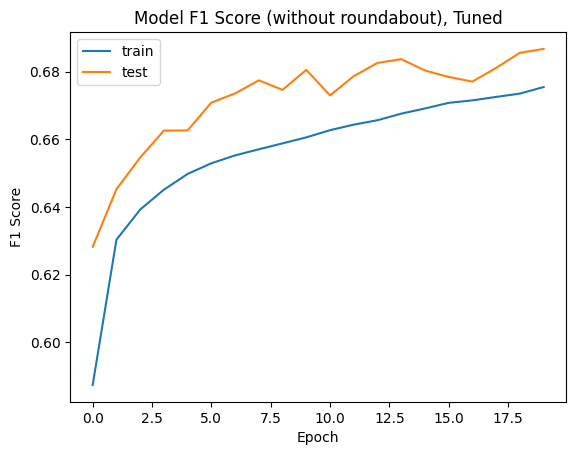

6/6 [==============================] - 1s 13ms/step
Evaluation report (no roundabout):
{'accuracy': 0.8955848662825797, 'f1-FIX': 0.9351368855401184, 'f1-SACC': 0.9241398209831287, 'f1-SP': 0.5461991234733057, 'f1-NOISE': 0.7516428526407506}
Testing with video: sea
Total amount of windows:  52752
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_13 (TCN)                (None, 385, 128)          1922432   
                                                                 
 time_distributed_13 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
______________

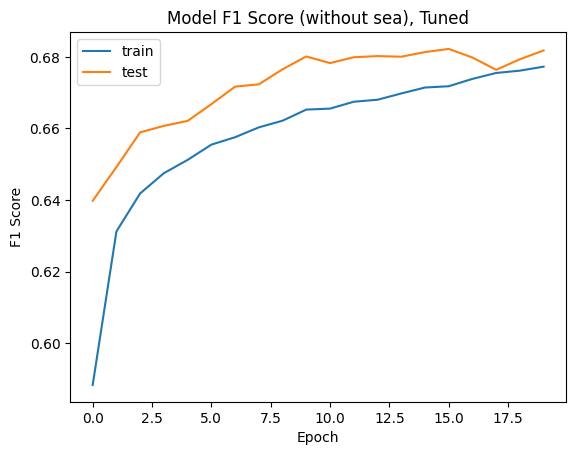

5/5 [==============================] - 2s 16ms/step
Evaluation report (no sea):
{'accuracy': 0.8694786592617874, 'f1-FIX': 0.9275138156334378, 'f1-SACC': 0.8685956336362773, 'f1-SP': 0.3583686207639694, 'f1-NOISE': 0.469385827675138}
Testing with video: st_petri_gate
Total amount of windows:  51946
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_14 (TCN)                (None, 385, 128)          1922432   
                                                                 
 time_distributed_14 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
____________

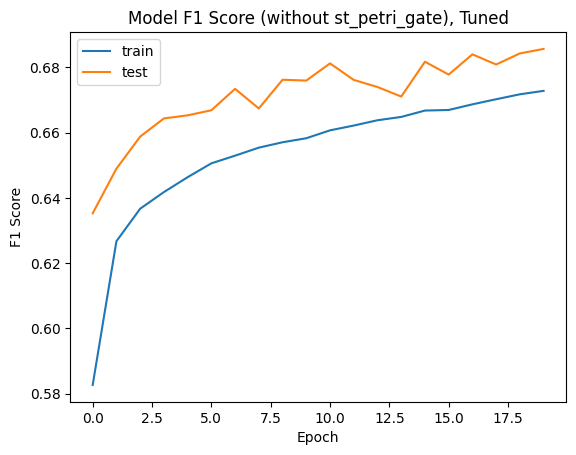

6/6 [==============================] - 1s 13ms/step
Evaluation report (no st_petri_gate):
{'accuracy': 0.9413165331709525, 'f1-FIX': 0.9690477435479914, 'f1-SACC': 0.8955569849468474, 'f1-SP': 0.5001422784808442, 'f1-NOISE': 0.6908569981229136}
Testing with video: st_petri_market
Total amount of windows:  52266
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_15 (TCN)                (None, 385, 128)          1922432   
                                                                 
 time_distributed_15 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0

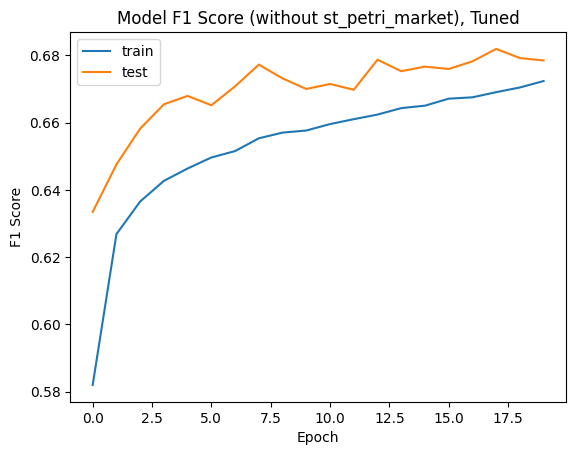

5/5 [==============================] - 1s 14ms/step
Evaluation report (no st_petri_market):
{'accuracy': 0.9362457722660654, 'f1-FIX': 0.965232049242342, 'f1-SACC': 0.9003153801748994, 'f1-SP': 0.4538228123627378, 'f1-NOISE': 0.732067263773743}
Testing with video: st_petri_mcdonalds
Total amount of windows:  52527
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_16 (TCN)                (None, 385, 128)          1922432   
                                                                 
 time_distributed_16 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params

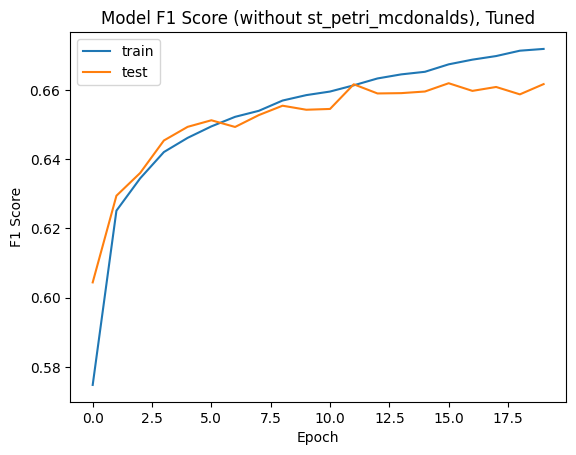

5/5 [==============================] - 1s 14ms/step
Evaluation report (no st_petri_mcdonalds):
{'accuracy': 0.9082643448472738, 'f1-FIX': 0.9429856160089987, 'f1-SACC': 0.9094554319969395, 'f1-SP': 0.7269819763173346, 'f1-NOISE': 0.7184833643342732}
Testing with video: street
Total amount of windows:  51910
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_17 (TCN)                (None, 385, 128)          1922432   
                                                                 
 time_distributed_17 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 1,923,077
Trainable params: 1,923,077
Non-trainable params: 0
___

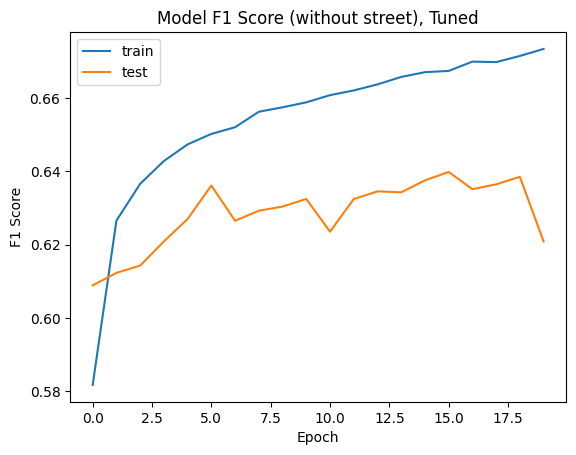

6/6 [==============================] - 1s 13ms/step
Evaluation report (no street):
{'accuracy': 0.9100068431450631, 'f1-FIX': 0.9420478777769132, 'f1-SACC': 0.8783880730702168, 'f1-SP': 0.862462351470505, 'f1-NOISE': 0.7719214962498184}
time: 1h 59min 14s (started: 2023-07-02 22:42:50 +00:00)


In [ ]:
for i, video_name in enumerate(video_names):
    print("Testing with video: " + video_name)
    r = np.random.RandomState(0)
    train_set_len = sum([len(windows_x[j]) for j in range(len(windows_x)) if j != i])
    print('Total amount of windows: ', train_set_len)

    perm = r.permutation(train_set_len)[:50000]
    train_x = []
    train_y = []

    indices_range_low = 0
    for j in range(len(windows_x)):
        if j == i:
            continue
        indices_range_high = indices_range_low + len(windows_x[j])
        local_indices = perm[(perm >= indices_range_low) * (perm < indices_range_high)]
        local_indices -= indices_range_low

        train_x.append(windows_x[j][local_indices])
        train_y.append(windows_y[j][local_indices])

        indices_range_low = indices_range_high

    train_x = np.concatenate(train_x)
    train_y = np.concatenate(train_y)

    model = create_model(
        num_classes = 5,
        train_data_shape = train_x.shape,
        dropout_rate = 0.1,
        nb_filters = 128,
        nb_stacks = 3,
        kernel_size = 4,
        dilation_count = 5,
        padding_mode = 'same',
    )
    print('Total amount of windows: ', len(train_x))
    assert train_x.shape[0] == train_y.shape[0]
    assert train_x.shape[0] == 50000

    history = model.fit(
        train_x, train_y,
        epochs = 20,
        batch_size = 128,
        shuffle = True,
        validation_split = 0.1,
        verbose = 1,
        initial_epoch = 0
    )

    print('Saving model..')
    model.save('/content/drive/MyDrive/Skripsi/gazecom_sdsd7_window_385_no_{}_tuned_3.h5'.format(video_name))

    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model F1 Score (without {}), Tuned'.format(video_name))
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    raw, preprocessed = evaluate_test_lovo(
        model,
        data_X[i],
        data_Y_one_hot[i],
        keys_to_subtract_start_indices = [],
        padding_features = padding_features,
    )
    print('Evaluation report (no {}):'.format(video_name))
    print(preprocessed)

In [ ]:
results = {
    'accuracy': [],
    'f1-SP': [],
    'f1-FIX': [],
    'f1-SACC': [],
    'f1-NOISE': [],
    'f1_score': [],
}
raw_results = {'true': [], 'pred': []}

for i, video_name in enumerate(video_names):
  model = tf.keras.models.load_model('/content/drive/MyDrive/Skripsi/gazecom_sdsd7_window_385_no_{}_tuned_3.h5'.format(video_name),
                                   custom_objects= {'f1_score': f1_score, 'f1_SP': f1_SP, 'f1_SACC': f1_SACC, 'f1_FIX': f1_FIX, 'f1_NOISE': f1_NOISE, 'TCN':TCN})

  raw, preprocessed = evaluate_test_lovo(
      model,
      data_X[i],
      data_Y_one_hot[i],
      keys_to_subtract_start_indices = [],
      padding_features = padding_features,
  )

  for k in raw_results.keys():
      raw_results[k].append(np.concatenate(raw[k], axis=0))
  for k in results.keys():
      results[k].append(preprocessed[k])

  print ('Evaluating for video', video_name)
  for stat_name in ['FIX', 'SACC', 'SP', 'NOISE']:
      print ('f1-{}'.format(stat_name), results['f1-{}'.format(stat_name)][-1])
  print('f1 score: {}'.format(results['f1_score'][-1]))

raw_results['true'] = np.concatenate(raw_results['true'])
raw_results['pred'] = np.concatenate(raw_results['pred'])

mask = np.argmax(raw_results['true'], axis=-1) != 0
print ('Found', np.logical_not(mask).sum(), 'UNKNOWN samples in the raw ``true\'\' predictions ' \
                                            '(including the artificially padded parts of the last windows ' \
                                            'in each sequence, in order to match window width)')

print (raw_results['true'].shape, raw_results['pred'].shape)

unknown_class_mask = raw_results['true'][:, :, 0] == 1  # count "unknown"s in the one-hot-encoded true labels

print ('Overall classification scores per class:')
for stat_i, stat_name in zip(range(1, 5), ['FIX', 'SACC', 'SP', 'NOISE']):
    results['overall-F1-{}'.format(stat_name)] = K.eval(categorical_f1_score_for_class(raw_results['true'],
                                                                                        raw_results['pred'],
                                                                                        stat_i,
                                                                                        'float64'))
    print ('F1-{}'.format(stat_name), results['overall-F1-{}'.format(stat_name)])

results['overall-F1_score'] = float(str(f1_score(raw_results['true'], raw_results['pred']))[10:19])

results['overall-acc'] = np.mean(np.argmax(raw_results['true'][np.logical_not(unknown_class_mask)], axis=-1) ==
                                  np.argmax(raw_results['pred'][np.logical_not(unknown_class_mask)], axis=-1))

print('overall-F1_score', results['overall-F1_score'])
print('overall-Accuracy', results['overall-acc'])

6/6 [==============================] - 1s 36ms/step
Evaluating for video beach
f1-FIX 0.9578370183018935
f1-SACC 0.9066425685162682
f1-SP 0.5862387133500778
f1-NOISE 0.7700743360105168
f1 score: 0.8441585
6/6 [==============================] - 1s 37ms/step
Evaluating for video breite_strasse
f1-FIX 0.9567828825750639
f1-SACC 0.9095908262436828
f1-SP 0.8432917915062695
f1-NOISE 0.7948975002502022
f1 score: 0.9009125
6/6 [==============================] - 1s 36ms/step
Evaluating for video bridge_1
f1-FIX 0.9750977314694602
f1-SACC 0.9020926112698634
f1-SP 0.0
f1-NOISE 0.7108281662362078
f1 score: 0.7176036
6/6 [==============================] - 1s 36ms/step
Evaluating for video bridge_2
f1-FIX 0.8801518545771675
f1-SACC 0.8822234298505989
f1-SP 0.6815502640593951
f1-NOISE 0.7499119178924739
f1 score: 0.8387674
5/5 [==============================] - 1s 37ms/step
Evaluating for video bumblebee
f1-FIX 0.944223263525069
f1-SACC 0.8935311414669694
f1-SP 0.6285248957905419
f1-NOISE 0.699857548

[Text(0.5, 1.0, 'Confusion Matrix for Tuned TCN Model')]

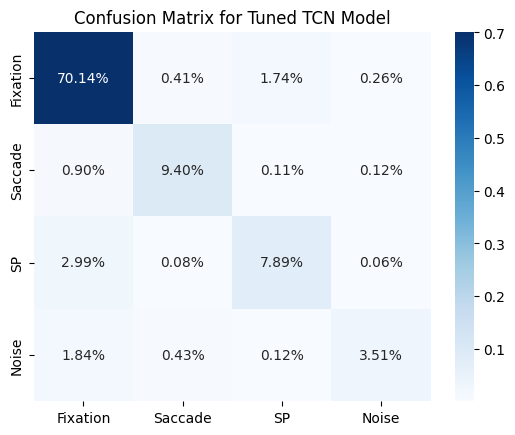

time: 2.86 s (started: 2023-07-03 15:57:50 +00:00)


In [ ]:
import seaborn as sns
labels = ['Fixation', 'Saccade', 'SP', 'Noise']
conf_matrix = confusion_matrix(np.argmax(raw_results['true'][np.logical_not(unknown_class_mask)], axis=-1), np.argmax(raw_results['pred'][np.logical_not(unknown_class_mask)], axis=-1))
sns.heatmap(conf_matrix/np.sum(conf_matrix), annot = True, fmt = '.2%', cmap = 'Blues', xticklabels = labels, yticklabels = labels).set(title = 'Confusion Matrix for Tuned TCN Model')

### Training with CV

In [ ]:
def create_model(num_classes, train_data_shape, dropout_rate, nb_filters, nb_stacks, kernel_size, dilation_count, padding_mode):

    in_model = Input(batch_shape = (None, train_data_shape[1], train_data_shape[2]))

    model = TCN(return_sequences = True,
                dropout_rate = dropout_rate,
                nb_filters = nb_filters,
                nb_stacks = nb_stacks,
                kernel_size = kernel_size,
                dilations = [2**i for i in range(dilation_count)],
                padding = padding_mode,
                activation = 'tanh',
                kernel_initializer = 'random_uniform',
                use_batch_norm = False
                )(in_model)

    out_model = TimeDistributed(Dense(num_classes, activation = 'softmax'))(model)
    model = Model(in_model, out_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy',
                        metrics = ['accuracy', f1_score, f1_SP, f1_FIX, f1_SACC, f1_NOISE])
    model.summary()

    return model

time: 733 µs (started: 2023-07-03 08:21:36 +00:00)


Tuned Model

Tuned Model, 20 Epochs
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn (TCN)                   (None, 385, 128)          5149312   
                                                                 
 time_distributed (TimeDistr  (None, 385, 5)           645       
 ibuted)                                                         
                                                                 
Total params: 5,149,957
Trainable params: 5,149,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
622/622 [==============================] - 56s 43ms/step - loss: 0.4342 - accuracy: 0.8628 - f1_score: 0.5874 - f1_SP: 0.5616 - f1_FIX: 0.9178 - f1_SACC: 0.8385 - f1_NOISE: 0.6192 - val_loss: 0.3166 - val_accuracy: 

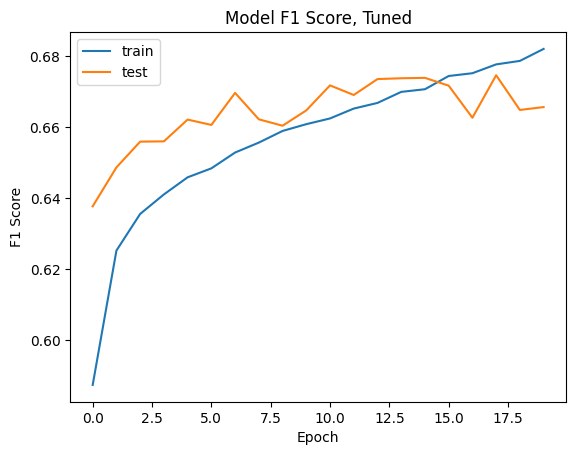

173/173 [==============================] - 3s 10ms/step
{'accuracy': 0.921634164839235, 'F1-FIX': 0.9523679348845987, 'F1-SACC': 0.9108846363662723, 'F1-SP': 0.7970889041944358, 'F1-NOISE': 0.7233328928679726}
Tuned Model, 20 Epochs
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_1 (TCN)                 (None, 385, 128)          5149312   
                                                                 
 time_distributed_1 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 5,149,957
Trainable params: 5,149,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
622

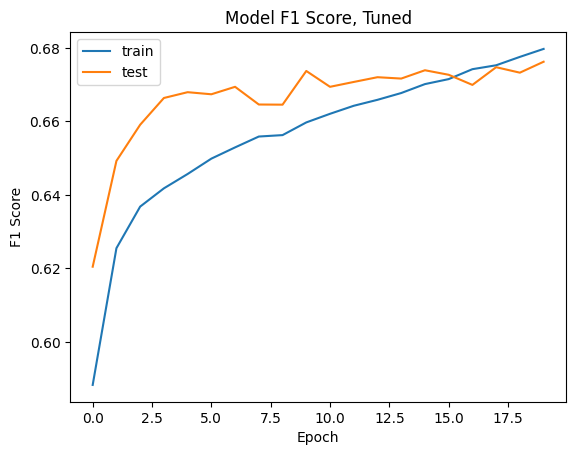

173/173 [==============================] - 3s 10ms/step
{'accuracy': 0.9231945888229843, 'F1-FIX': 0.9532489798316467, 'F1-SACC': 0.907303374531986, 'F1-SP': 0.8292905604081106, 'F1-NOISE': 0.7312417703452071}
Tuned Model, 20 Epochs
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_2 (TCN)                 (None, 385, 128)          5149312   
                                                                 
 time_distributed_2 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 5,149,957
Trainable params: 5,149,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
622

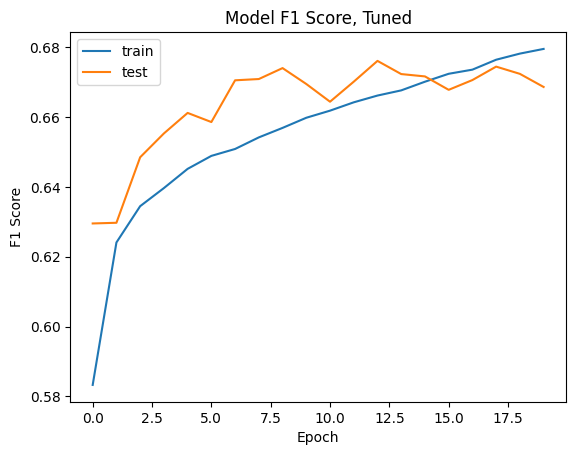

173/173 [==============================] - 3s 10ms/step
{'accuracy': 0.9230904010875036, 'F1-FIX': 0.9536896812990773, 'F1-SACC': 0.9071771212062439, 'F1-SP': 0.8125407240595549, 'F1-NOISE': 0.7215931417019862}
Tuned Model, 20 Epochs
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_3 (TCN)                 (None, 385, 128)          5149312   
                                                                 
 time_distributed_3 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 5,149,957
Trainable params: 5,149,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
62

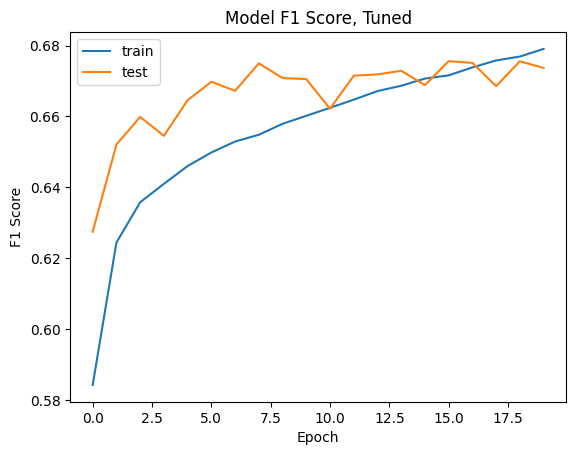

173/173 [==============================] - 3s 10ms/step
{'accuracy': 0.9257811728293438, 'F1-FIX': 0.9553110652624865, 'F1-SACC': 0.9109930908734792, 'F1-SP': 0.8190137901805163, 'F1-NOISE': 0.7335983170289482}
Tuned Model, 20 Epochs
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_4 (TCN)                 (None, 385, 128)          5149312   
                                                                 
 time_distributed_4 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 5,149,957
Trainable params: 5,149,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
62

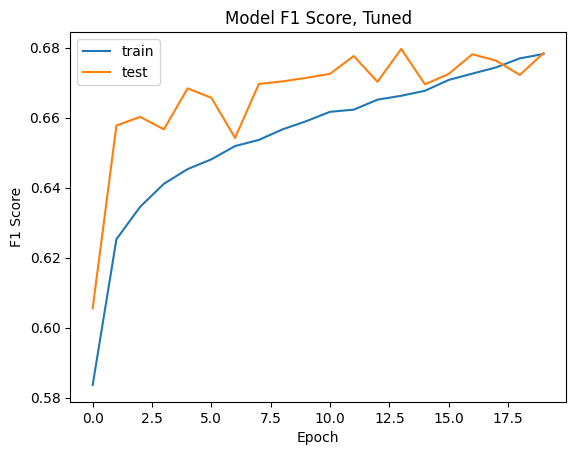

173/173 [==============================] - 3s 10ms/step
{'accuracy': 0.9240038664703641, 'F1-FIX': 0.9540786778101765, 'F1-SACC': 0.9027024927186489, 'F1-SP': 0.8250813157502794, 'F1-NOISE': 0.7399986293144573}
time: 43min 3s (started: 2023-06-27 17:41:28 +00:00)


In [ ]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

fold_var = 1

for train_index, val_index in kf.split(train_df, label):
  training_data = train_df[train_index]
  training_label = label[train_index]
  validation_data = train_df[val_index]
  validation_label = label[val_index]

  # CREATE NEW MODEL
  print("Tuned Model, 20 Epochs")
  model = create_model(
      num_classes = 5,
      train_data_shape = training_data.shape,
      dropout_rate = 0.1,
      nb_filters = 128,
      nb_stacks = 4,
      kernel_size = 8,
      dilation_count = 5,
      padding_mode = 'same',
  )

  batch_size = 64

  history_tuned = model.fit(
      training_data, training_label,
      epochs = 20,
      batch_size = batch_size,
      shuffle = True,
      validation_split = 0.1,
      verbose = 1,
      initial_epoch = 0
  )

  plt.plot(history_tuned.history['f1_score'])
  plt.plot(history_tuned.history['val_f1_score'])
  plt.title('Model F1 Score, Tuned')
  plt.ylabel('F1 Score')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc = 'upper left')
  plt.show()

  fold_var += 1

  raw, preprocessed = evaluate_test_cv(
      model,
      validation_data,
      validation_label,
      batch_size
  )

  print(preprocessed)

Untuned Model

Tuned Model, 20 Epochs
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_5 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_5 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==============================] - 25s 47ms/step - loss: 0.5239 - accuracy: 0.8354 - f1_score: 0.5366 - f1_SP: 0.4586 - f1_FIX: 0.9023 - f1_SACC: 0.8020 - f1_NOISE: 0.5199 - val_loss: 0.3833 - val_accuracy

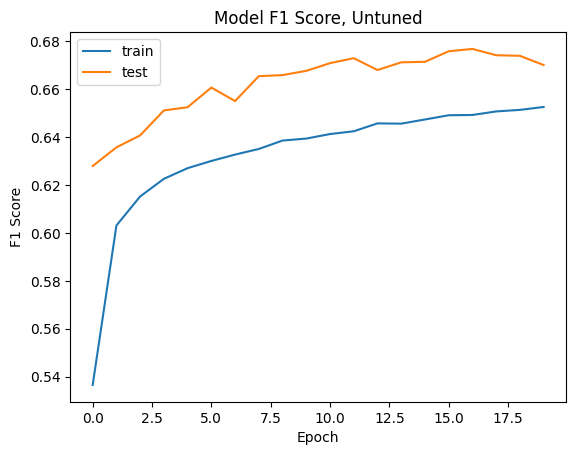

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9103462223607085, 'F1-FIX': 0.9456680213994171, 'F1-SACC': 0.8964958366839716, 'F1-SP': 0.7576263335781603, 'F1-NOISE': 0.7095562238376452}
Tuned Model, 20 Epochs
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_6 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_6 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/

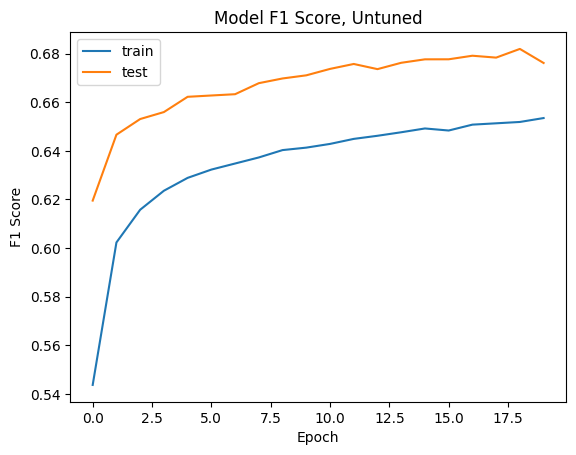

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9083060908667573, 'F1-FIX': 0.9445635192592148, 'F1-SACC': 0.8965265057091759, 'F1-SP': 0.7457763633584629, 'F1-NOISE': 0.7040028683426843}
Tuned Model, 20 Epochs
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_7 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_7 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/

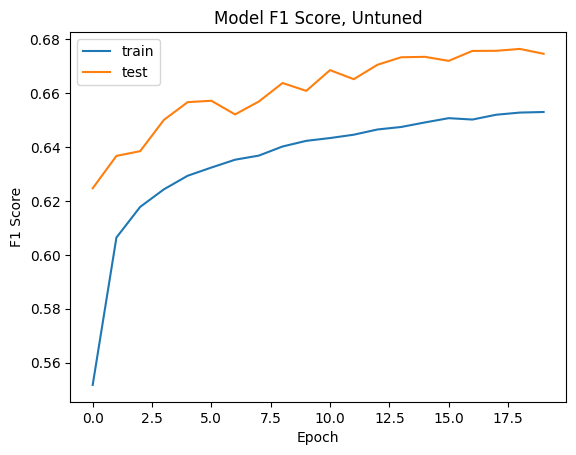

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9064753971128473, 'F1-FIX': 0.9431240514955505, 'F1-SACC': 0.8921889076654194, 'F1-SP': 0.7697469087464792, 'F1-NOISE': 0.6938219798911922}
Tuned Model, 20 Epochs
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_8 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_8 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/

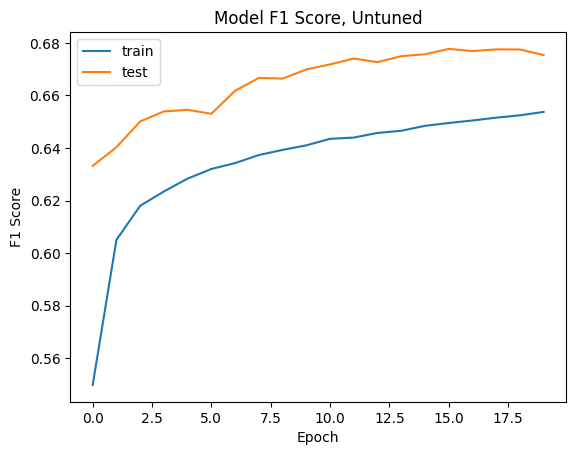

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9103256395903987, 'F1-FIX': 0.9458423234104465, 'F1-SACC': 0.8956611229325963, 'F1-SP': 0.7652636891057295, 'F1-NOISE': 0.6998044933981169}
Tuned Model, 20 Epochs
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_9 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_9 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/

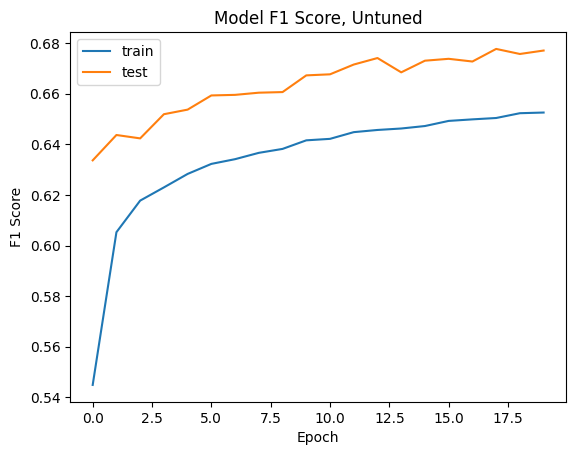

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9116948969176423, 'F1-FIX': 0.9465269307784592, 'F1-SACC': 0.8961707672316092, 'F1-SP': 0.7739189919593678, 'F1-NOISE': 0.7259409698292821}
time: 20min 47s (started: 2023-06-27 15:46:48 +00:00)


In [ ]:
kf = KFold(n_splits = 5, random_state = 42, shuffle = True)

fold_var = 1

for train_index, val_index in kf.split(train_df, label):
  training_data = train_df[train_index]
  training_label = label[train_index]
  validation_data = train_df[val_index]
  validation_label = label[val_index]

  # CREATE NEW MODEL
  print("Untuned Model, 20 Epochs")
  model = create_model(
    num_classes = 5,
    train_data_shape = training_data.shape,
    dropout_rate = 0.3,
    nb_filters = 128,
    nb_stacks = 1,
    kernel_size = 8,
    dilation_count = 8,
    padding_mode = 'same',
)

  batch_size = 128

  history_tuned = model.fit(
      training_data, training_label,
      epochs = 20,
      batch_size = batch_size,
      shuffle = True,
      validation_split = 0.1,
      verbose = 1,
      initial_epoch = 0
  )

  plt.plot(history_tuned.history['f1_score'])
  plt.plot(history_tuned.history['val_f1_score'])
  plt.title('Model F1 Score, Untuned')
  plt.ylabel('F1 Score')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc = 'upper left')
  plt.show()

  fold_var += 1

  raw, preprocessed = evaluate_test_cv(
      model,
      validation_data,
      validation_label,
      batch_size
  )

  print(preprocessed)

## 6 - Hyperparameter Comparations

In [ ]:
def create_model(num_classes, train_data_shape, dropout_rate, nb_filters, nb_stacks, kernel_size, dilation_count, padding_mode):

    in_model = Input(batch_shape = (None, train_data_shape[1], train_data_shape[2]))

    model = TCN(return_sequences = True,
                dropout_rate = dropout_rate,
                nb_filters = nb_filters,
                nb_stacks = nb_stacks,
                kernel_size = kernel_size,
                dilations = [2**i for i in range(dilation_count)],
                padding = padding_mode,
                activation = 'tanh',
                kernel_initializer = 'random_uniform',
                use_batch_norm = False
                )(in_model)

    out_model = TimeDistributed(Dense(num_classes, activation = 'softmax'))(model)
    model = Model(in_model, out_model)
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy',
                        metrics = ['accuracy', f1_score, f1_SP, f1_FIX, f1_SACC, f1_NOISE])

    tcn_full_summary(model, expand_residual_blocks = True)
    model.summary()

    return model

time: 777 µs (started: 2023-07-01 16:57:16 +00:00)


In [ ]:
model = create_model(
      num_classes = 5,
      train_data_shape = train_df.shape,
      dropout_rate = 0.3,
      nb_filters = 128,
      nb_stacks = 1,
      kernel_size = 8,
      dilation_count = 8,
      padding_mode = 'same',
)

Use tensorboard instead. Example in keras-tcn/tasks/tcn_tensorboard.py.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn (TCN)                   (None, 385, 128)          2000512   
                                                                 
 time_distributed (TimeDistr  (None, 385, 5)           645       
 ibuted)                                                         
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
time: 3.73 s (started: 2023-07-01 16:57:17 +00:00)


#### Batch Size

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn (TCN)                   (None, 385, 128)          2000512   
                                                                 
 time_distributed (TimeDistr  (None, 385, 5)           645       
 ibuted)                                                         
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1243/1243 [==============================] - 39s 17ms/step - loss: 0.4542 - accuracy: 0.8563 - f1_score: 0.5725 - f1_SP: 0.5173 - f1_FIX: 0.9142 - f1_SACC: 0.8307 - f1_NOISE: 0.6002 - val_loss: 0.3531 - val_accuracy: 0.8838 - val_f1_score

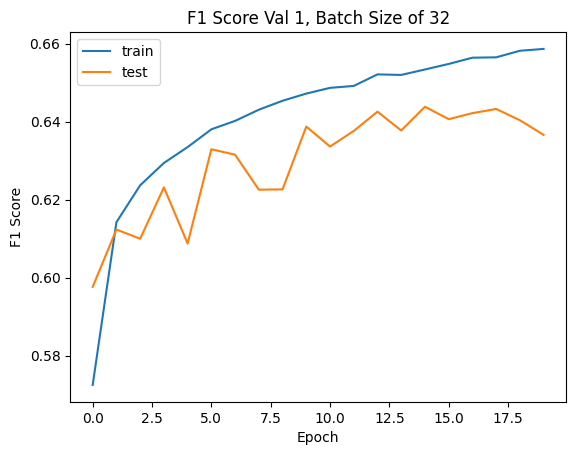

346/346 [==============================] - 2s 3ms/step
{'accuracy': 0.9143847189478697, 'F1-FIX': 0.9480763112616879, 'F1-SACC': 0.9012974816832884, 'F1-SP': 0.7723779309244365, 'F1-NOISE': 0.7175550765513327}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_1 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_1 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1243/1243 [===============

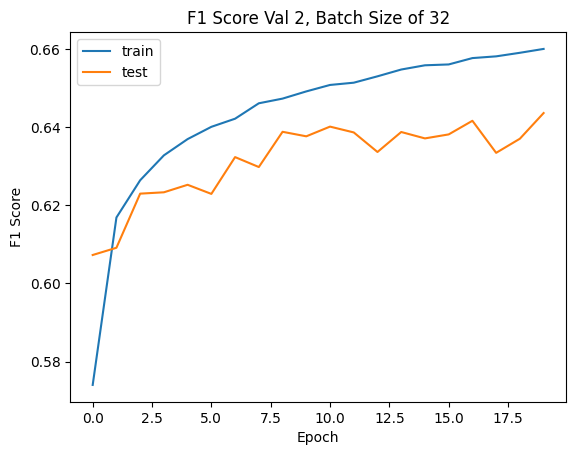

346/346 [==============================] - 2s 3ms/step
{'accuracy': 0.9102649614058523, 'F1-FIX': 0.9450629905782711, 'F1-SACC': 0.8986171331257937, 'F1-SP': 0.7869217780901083, 'F1-NOISE': 0.7125163934924437}
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_2 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_2 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1243/1243 [===============

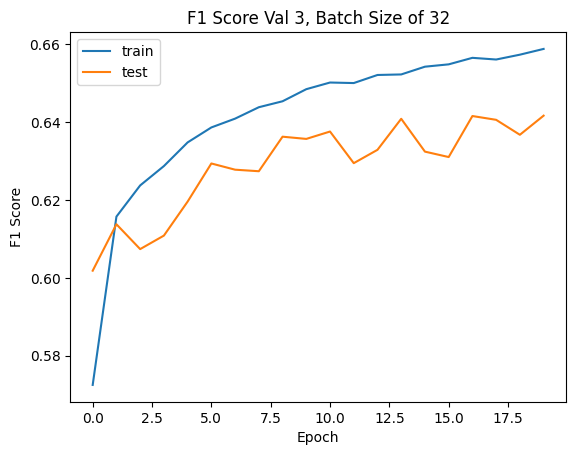

346/346 [==============================] - 2s 3ms/step
{'accuracy': 0.9154588258536104, 'F1-FIX': 0.9489553296804178, 'F1-SACC': 0.9015660287811282, 'F1-SP': 0.787565545686533, 'F1-NOISE': 0.7167587147166711}
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_3 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_3 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1243/1243 [================

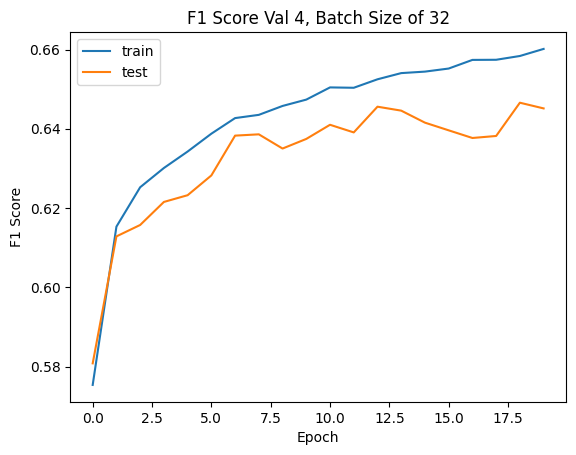

346/346 [==============================] - 2s 3ms/step
{'accuracy': 0.916222947642723, 'F1-FIX': 0.9492264639887155, 'F1-SACC': 0.903691092287563, 'F1-SP': 0.7835857358934074, 'F1-NOISE': 0.7231388923570683}
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_4 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_4 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
1243/1243 [=================

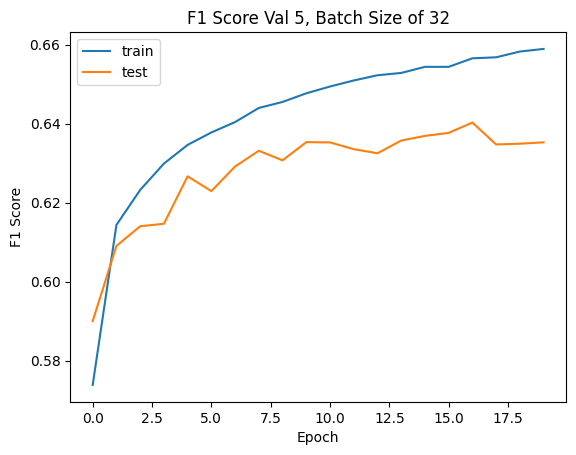

346/346 [==============================] - 2s 3ms/step
{'accuracy': 0.914618503553672, 'F1-FIX': 0.9483327158880533, 'F1-SACC': 0.899971688400265, 'F1-SP': 0.7745642819224516, 'F1-NOISE': 0.7250537756610916}
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_5 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_5 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
622/622 [===================

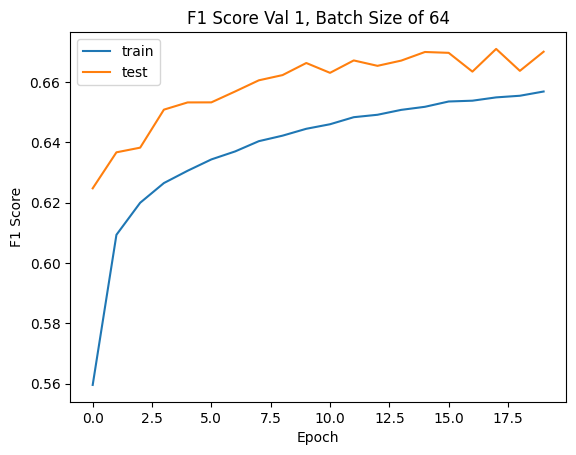

173/173 [==============================] - 1s 5ms/step
{'accuracy': 0.9149060807910966, 'F1-FIX': 0.9485257540803668, 'F1-SACC': 0.9006152026065147, 'F1-SP': 0.7862530293571437, 'F1-NOISE': 0.7120253881665936}
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_6 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_6 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
622/622 [=================

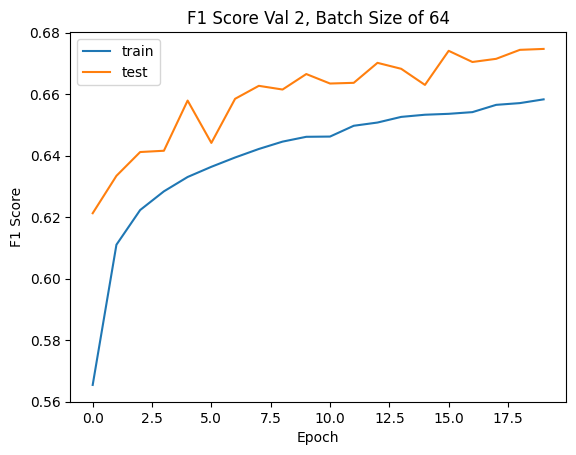

173/173 [==============================] - 1s 5ms/step
{'accuracy': 0.9108755062395048, 'F1-FIX': 0.945813045906622, 'F1-SACC': 0.8970353804158656, 'F1-SP': 0.7837347962997484, 'F1-NOISE': 0.7079778239607157}
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_7 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_7 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
622/622 [==================

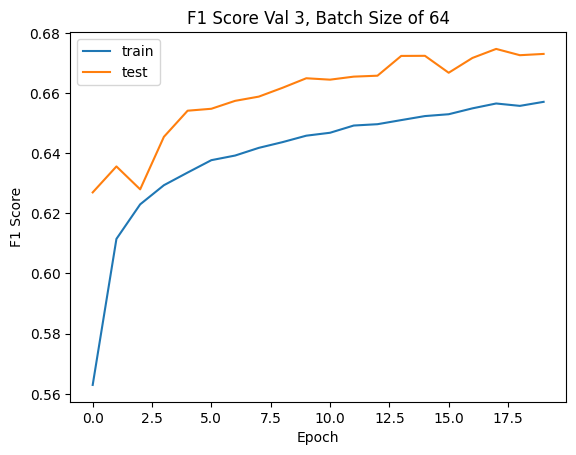

173/173 [==============================] - 1s 5ms/step
{'accuracy': 0.910509790824894, 'F1-FIX': 0.945505668670274, 'F1-SACC': 0.8980402494546438, 'F1-SP': 0.7765227333682305, 'F1-NOISE': 0.7242712447520312}
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_8 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_8 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
622/622 [===================

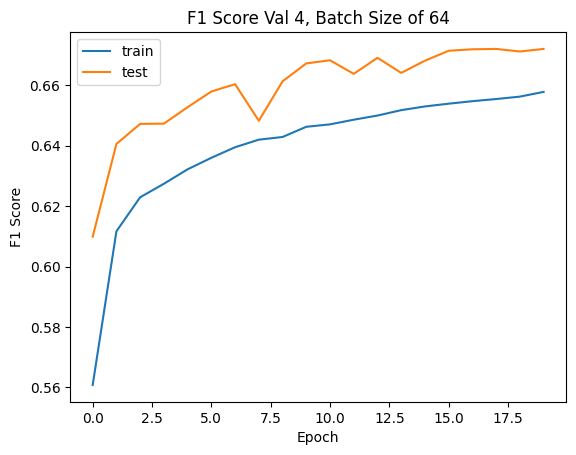

173/173 [==============================] - 1s 5ms/step
{'accuracy': 0.9122200689567586, 'F1-FIX': 0.9464893849905, 'F1-SACC': 0.9009250281440696, 'F1-SP': 0.7785968928718625, 'F1-NOISE': 0.72743267470273}
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_9 (TCN)                 (None, 385, 128)          2000512   
                                                                 
 time_distributed_9 (TimeDis  (None, 385, 5)           645       
 tributed)                                                       
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
622/622 [======================

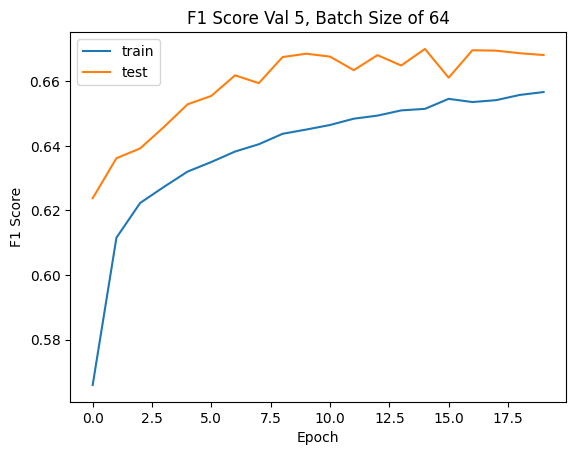

173/173 [==============================] - 1s 5ms/step
{'accuracy': 0.9119155021002178, 'F1-FIX': 0.9467539526875818, 'F1-SACC': 0.8992991649333149, 'F1-SP': 0.7574984559086301, 'F1-NOISE': 0.7229722538060694}
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_10 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_10 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [================

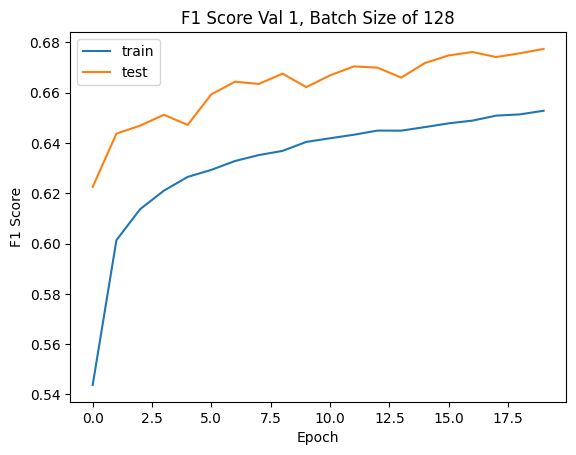

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.912129952437784, 'F1-FIX': 0.946809304013467, 'F1-SACC': 0.896292894570607, 'F1-SP': 0.7799927886802408, 'F1-NOISE': 0.7117960689753261}
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_11 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_11 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [====================

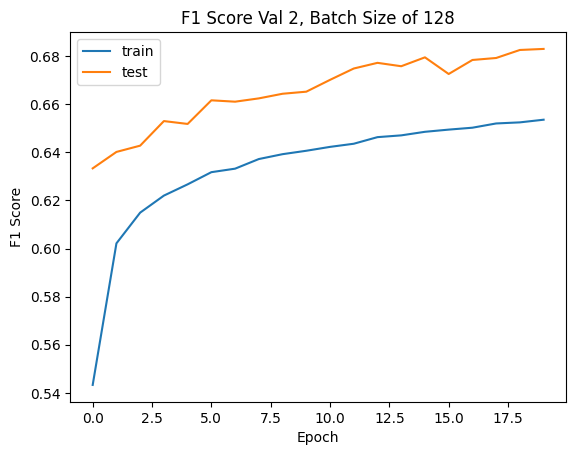

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9087950441445551, 'F1-FIX': 0.9446477690009513, 'F1-SACC': 0.8954677577395848, 'F1-SP': 0.7742372381354411, 'F1-NOISE': 0.7084204458855932}
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_12 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_12 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

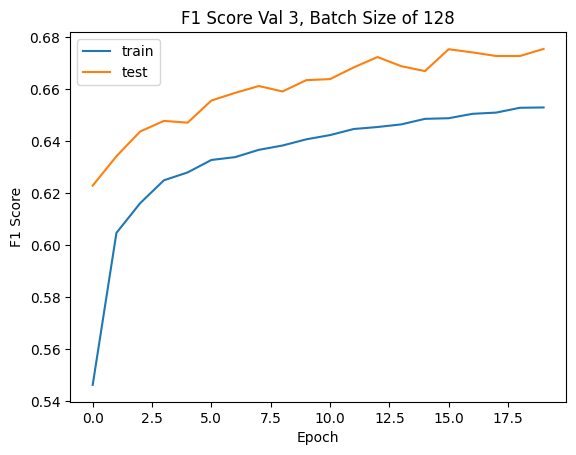

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9093959463209735, 'F1-FIX': 0.9455744294729086, 'F1-SACC': 0.8930527491103297, 'F1-SP': 0.7610751455301845, 'F1-NOISE': 0.7064593704582939}
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_13 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_13 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

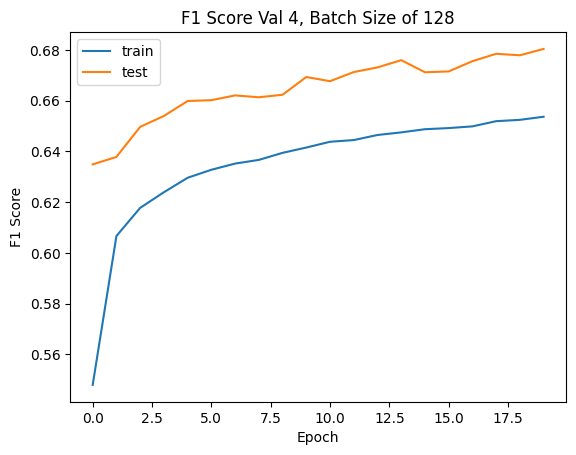

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9068281772555586, 'F1-FIX': 0.9428275998061735, 'F1-SACC': 0.8982068020625891, 'F1-SP': 0.7643380887243003, 'F1-NOISE': 0.7227865200164666}
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_14 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_14 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

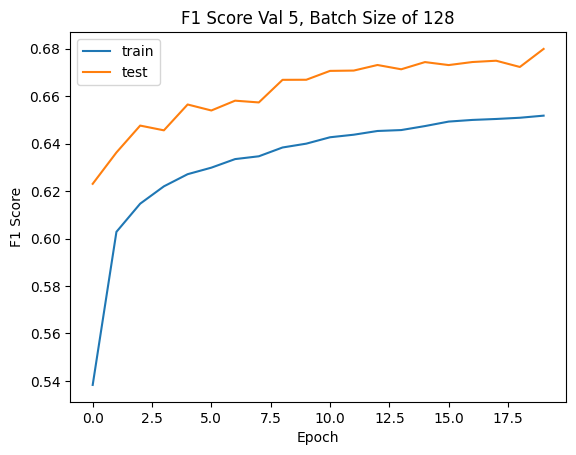

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.910229918578343, 'F1-FIX': 0.9453829420846979, 'F1-SACC': 0.8951841866949096, 'F1-SP': 0.7758544206578151, 'F1-NOISE': 0.7244164007296608}
time: 1h 15min 29s (started: 2023-06-30 16:15:58 +00:00)


In [ ]:
batch_size_space = [32, 64, 128]
for i in batch_size_space:
  kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
  fold_var = 1

  for train_index, val_index in kf.split(train_df, label):
    training_data = train_df[train_index]
    training_label = label[train_index]
    validation_data = train_df[val_index]
    validation_label = label[val_index]

    # CREATE NEW MODEL
    model = create_model(
      num_classes = 5,
      train_data_shape = training_data.shape,
      dropout_rate = 0.3,
      nb_filters = 128,
      nb_stacks = 1,
      kernel_size = 8,
      dilation_count = 8,
      padding_mode = 'same',
  )

    batch_size = i

    history_tuned = model.fit(
        training_data, training_label,
        epochs = 20,
        batch_size = batch_size,
        shuffle = True,
        validation_split = 0.1,
        verbose = 1,
        initial_epoch = 0
    )

    plt.plot(history_tuned.history['f1_score'])
    plt.plot(history_tuned.history['val_f1_score'])
    plt.title('F1 Score Val {}, Batch Size of {}'.format(fold_var, i))
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    fold_var += 1

    raw, preprocessed = evaluate_test_cv(
        model,
        validation_data,
        validation_label,
        batch_size
    )

    print(preprocessed)

#### Dropout Rate

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_15 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_15 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==============================] - 22s 41ms/step - loss: 0.4360 - accuracy: 0.8588 - f1_score: 0.5753 - f1_SP: 0.5459 - f1_FIX: 0.9154 - f1_SACC: 0.8314 - f1_NOISE: 0.5840 - val_loss: 0.3433 - val_accuracy: 0.8806 - val_f1_scor

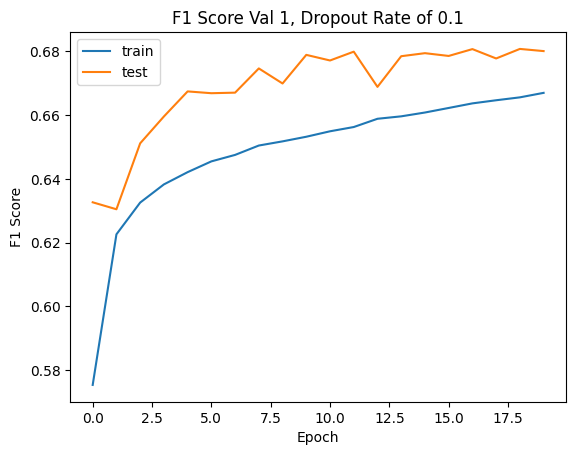

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9180975113614317, 'F1-FIX': 0.9504211918370393, 'F1-SACC': 0.9015624236663646, 'F1-SP': 0.8065988794681214, 'F1-NOISE': 0.7244508905485901}
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_16 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_16 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

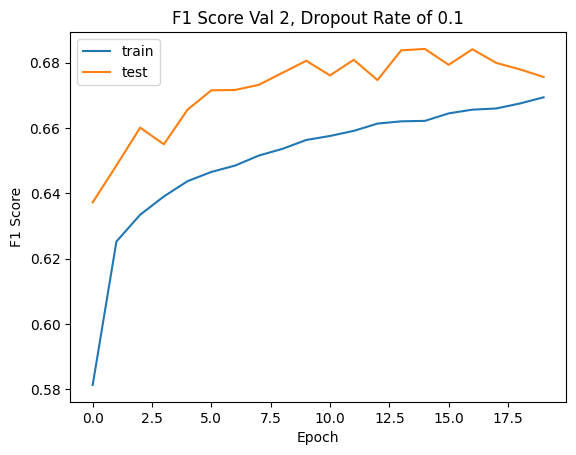

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.913567453915154, 'F1-FIX': 0.947903836212961, 'F1-SACC': 0.8988908853263006, 'F1-SP': 0.7692215124860602, 'F1-NOISE': 0.7106241727091831}
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_17 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_17 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [===================

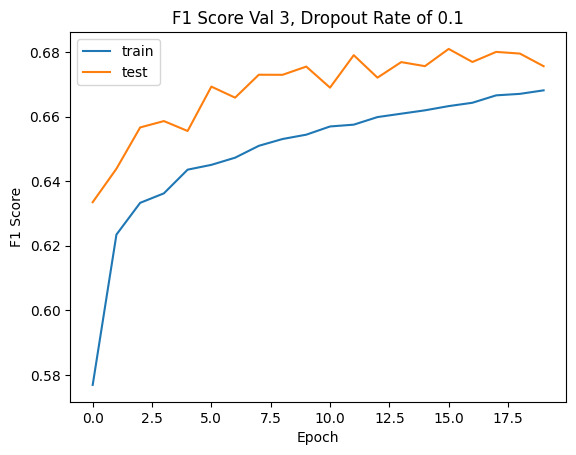

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9151878907040081, 'F1-FIX': 0.9490099896203944, 'F1-SACC': 0.9006483208866408, 'F1-SP': 0.770604538857839, 'F1-NOISE': 0.7309468840439085}
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_18 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_18 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

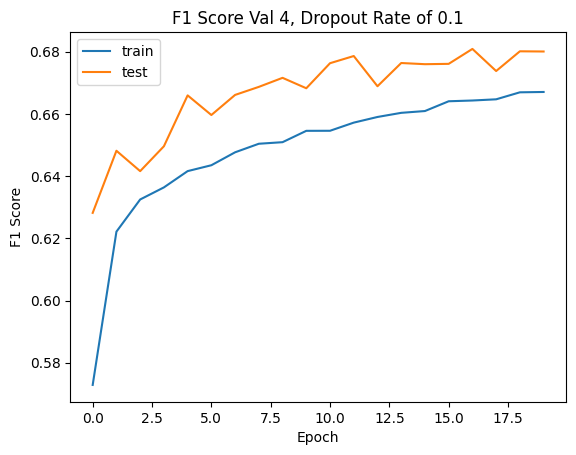

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9171954449027974, 'F1-FIX': 0.9500888374773423, 'F1-SACC': 0.9016352246318299, 'F1-SP': 0.7886473089961623, 'F1-NOISE': 0.7296049154024294}
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_19 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_19 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

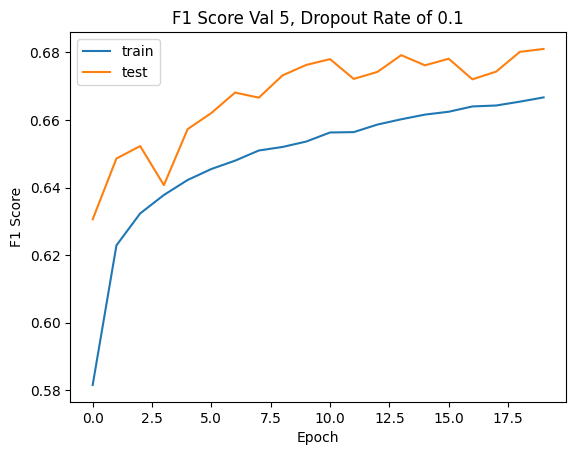

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9159400179682686, 'F1-FIX': 0.9491275770072054, 'F1-SACC': 0.8992161216630079, 'F1-SP': 0.7975163342615791, 'F1-NOISE': 0.7327879606139471}
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_20 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_20 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

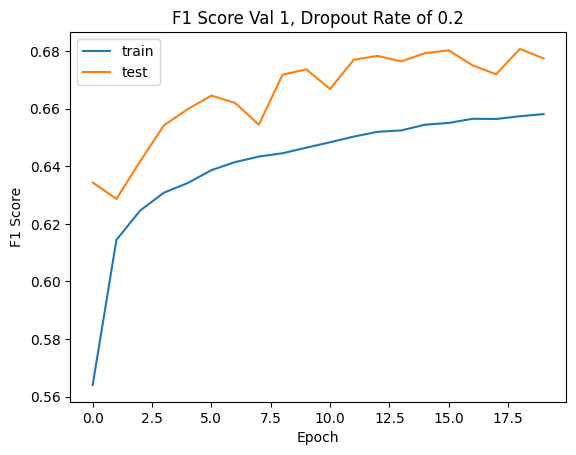

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9140354982274402, 'F1-FIX': 0.948011763024637, 'F1-SACC': 0.8960671802792679, 'F1-SP': 0.7852995775925481, 'F1-NOISE': 0.7030062418067955}
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_21 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_21 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

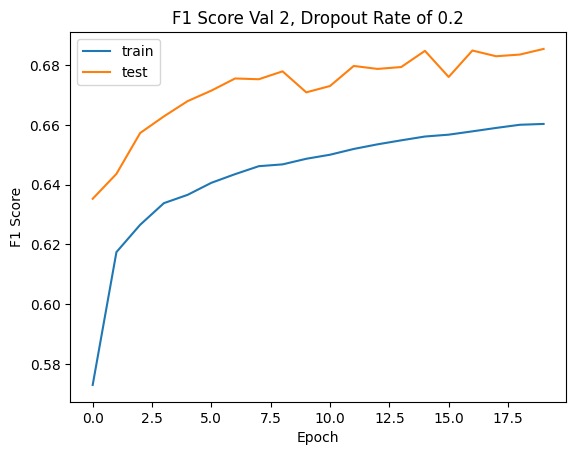

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9033114296062503, 'F1-FIX': 0.9401662529521969, 'F1-SACC': 0.896745591939541, 'F1-SP': 0.768530452698758, 'F1-NOISE': 0.7156774707848493}
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_22 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_22 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [===================

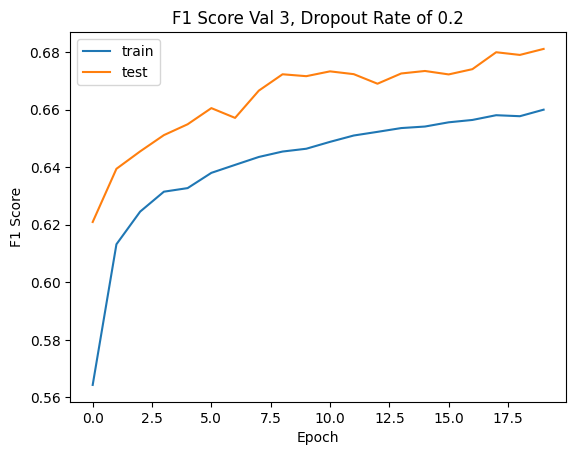

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9111534969919614, 'F1-FIX': 0.9460102856924842, 'F1-SACC': 0.8986007577567615, 'F1-SP': 0.7815609723642197, 'F1-NOISE': 0.7122691882426367}
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_23 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_23 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

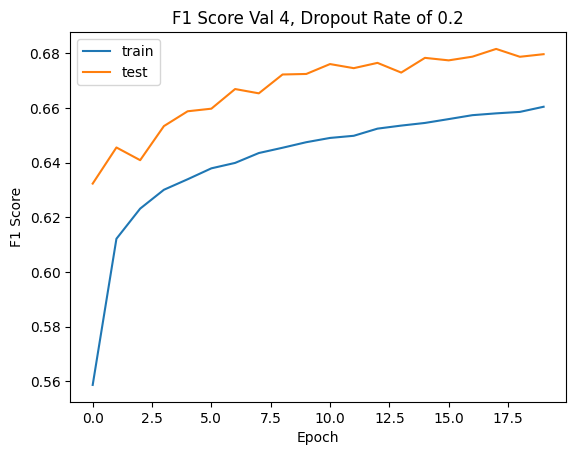

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9140613461149499, 'F1-FIX': 0.9481209092104158, 'F1-SACC': 0.9003059420639359, 'F1-SP': 0.7724995339694924, 'F1-NOISE': 0.729139066097224}
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_24 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_24 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

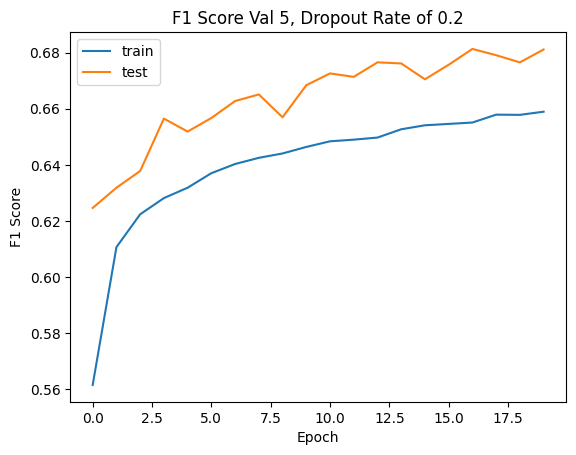

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9131184823868634, 'F1-FIX': 0.9475707949198657, 'F1-SACC': 0.896486618348946, 'F1-SP': 0.7821593345309767, 'F1-NOISE': 0.7200203269700577}
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_25 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_25 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

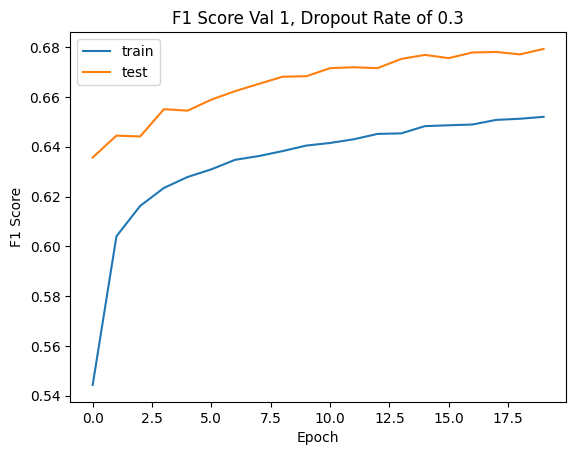

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9117863756885939, 'F1-FIX': 0.946613498631388, 'F1-SACC': 0.89429605398973, 'F1-SP': 0.7832618283066249, 'F1-NOISE': 0.701784011636263}
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_26 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_26 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=====================

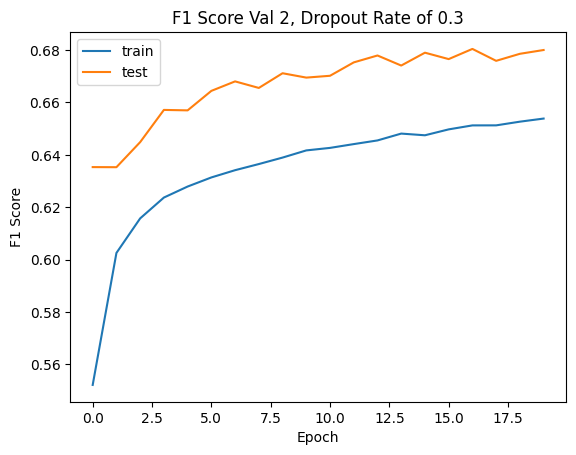

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9099157090645682, 'F1-FIX': 0.9454215468080174, 'F1-SACC': 0.8961245533420402, 'F1-SP': 0.7634500490693195, 'F1-NOISE': 0.7112195309505679}
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_27 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_27 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

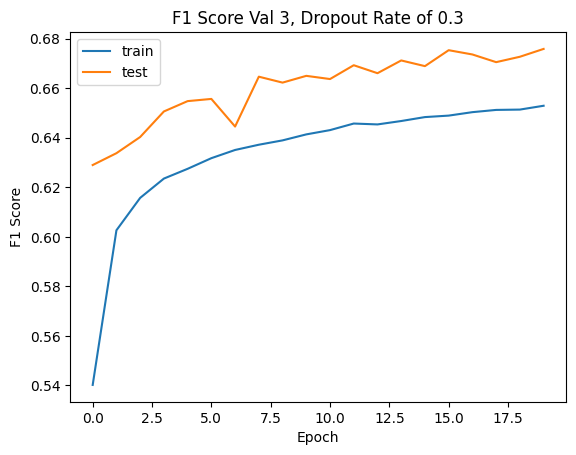

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.908906522669652, 'F1-FIX': 0.9448975805644072, 'F1-SACC': 0.8915206696555898, 'F1-SP': 0.7693739137610622, 'F1-NOISE': 0.7055723161116301}
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_28 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_28 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

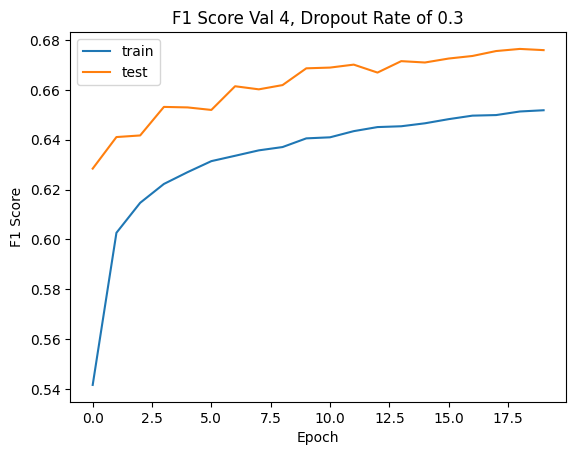

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9098119917026111, 'F1-FIX': 0.9453784373164112, 'F1-SACC': 0.8953666756759214, 'F1-SP': 0.7578206994336886, 'F1-NOISE': 0.7127440786302558}
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_29 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_29 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

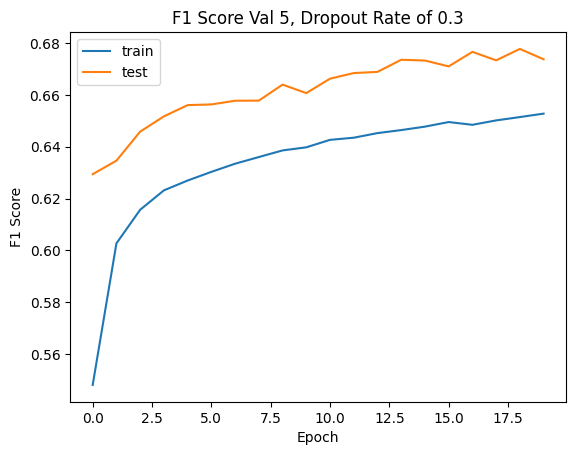

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9090916146511945, 'F1-FIX': 0.9448890137766579, 'F1-SACC': 0.8914600336712275, 'F1-SP': 0.7691971935310252, 'F1-NOISE': 0.7086917021439892}
time: 1h 2min 22s (started: 2023-06-30 17:31:35 +00:00)


In [ ]:
dropout_rate_space = [0.1, 0.2, 0.3]
for i in dropout_rate_space:
  kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
  fold_var = 1

  for train_index, val_index in kf.split(train_df, label):
    training_data = train_df[train_index]
    training_label = label[train_index]
    validation_data = train_df[val_index]
    validation_label = label[val_index]

    # CREATE NEW MODEL
    model = create_model(
      num_classes = 5,
      train_data_shape = training_data.shape,
      dropout_rate = i,
      nb_filters = 128,
      nb_stacks = 1,
      kernel_size = 8,
      dilation_count = 8,
      padding_mode = 'same',
  )

    batch_size = 128

    history_tuned = model.fit(
        training_data, training_label,
        epochs = 20,
        batch_size = batch_size,
        shuffle = True,
        validation_split = 0.1,
        verbose = 1,
        initial_epoch = 0
    )

    plt.plot(history_tuned.history['f1_score'])
    plt.plot(history_tuned.history['val_f1_score'])
    plt.title('F1 Score Val {}, Dropout Rate of {}'.format(fold_var, i))
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    fold_var += 1

    raw, preprocessed = evaluate_test_cv(
        model,
        validation_data,
        validation_label,
        batch_size
    )

    print(preprocessed)

#### NB Filters

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_30 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_30 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==============================] - 18s 28ms/step - loss: 0.4952 - accuracy: 0.8403 - f1_score: 0.5327 - f1_SP: 0.4567 - f1_FIX: 0.9067 - f1_SACC: 0.7955 - f1_NOISE: 0.5048 - val_loss: 0.3710 - val_accuracy: 0.8723 - val_f1_score: 0

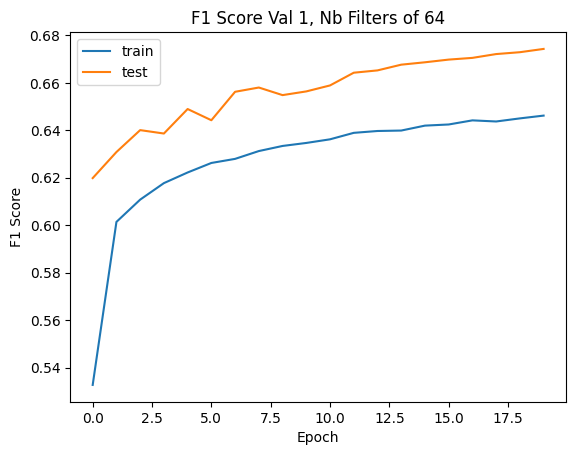

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9076498151011505, 'F1-FIX': 0.9441365358062875, 'F1-SACC': 0.8903791823174436, 'F1-SP': 0.7706582874569229, 'F1-NOISE': 0.7054673331393387}
Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_31 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_31 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

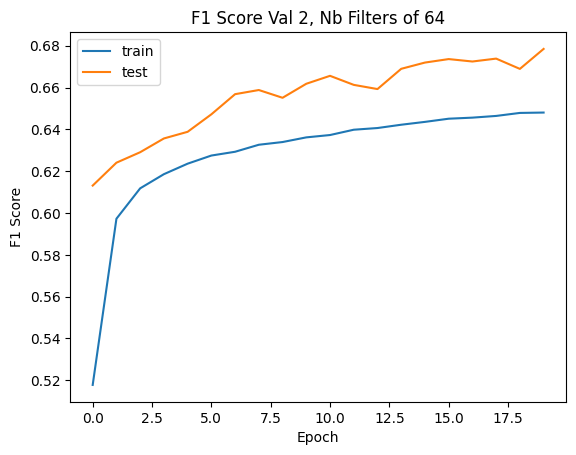

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9036660912430561, 'F1-FIX': 0.9415832406307902, 'F1-SACC': 0.8877285649613992, 'F1-SP': 0.7619383087110989, 'F1-NOISE': 0.6971437654629827}
Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_32 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_32 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

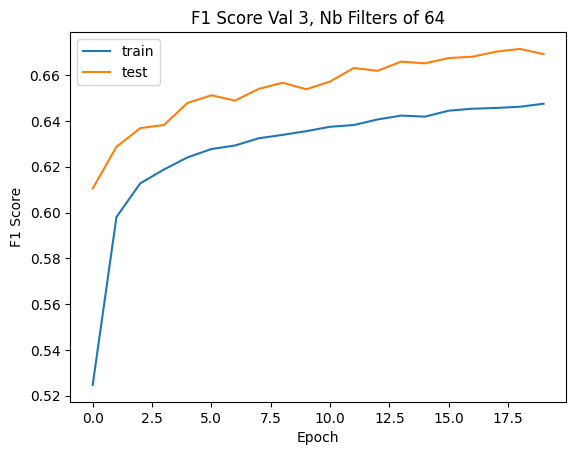

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9054276400889947, 'F1-FIX': 0.9427358492376536, 'F1-SACC': 0.8911469697975912, 'F1-SP': 0.7557712737074086, 'F1-NOISE': 0.7094444755453433}
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_33 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_33 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

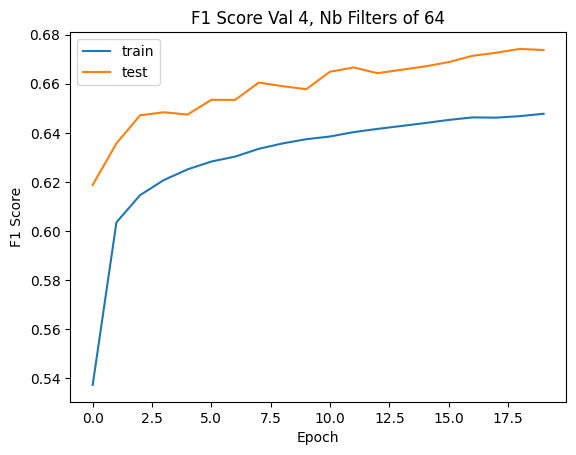

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9070838252656435, 'F1-FIX': 0.943672526058697, 'F1-SACC': 0.8917203043455427, 'F1-SP': 0.7594156440458777, 'F1-NOISE': 0.7208298017084303}
Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_34 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_34 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

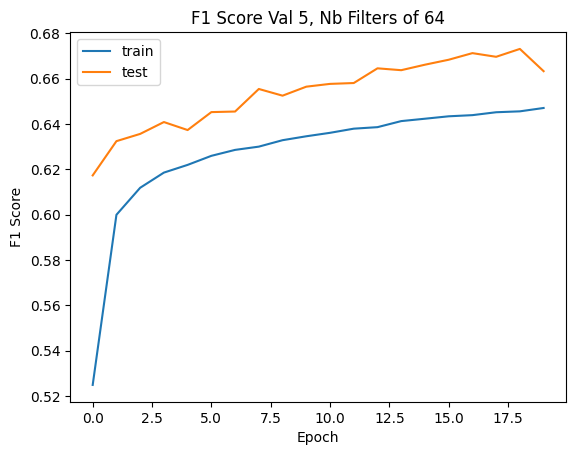

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9041362295799094, 'F1-FIX': 0.9424306785514481, 'F1-SACC': 0.8879206627673999, 'F1-SP': 0.7226181183370718, 'F1-NOISE': 0.7197543341886268}
Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_35 (TCN)                (None, 385, 96)           1131744   
                                                                 
 time_distributed_35 (TimeDi  (None, 385, 5)           485       
 stributed)                                                      
                                                                 
Total params: 1,132,229
Trainable params: 1,132,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

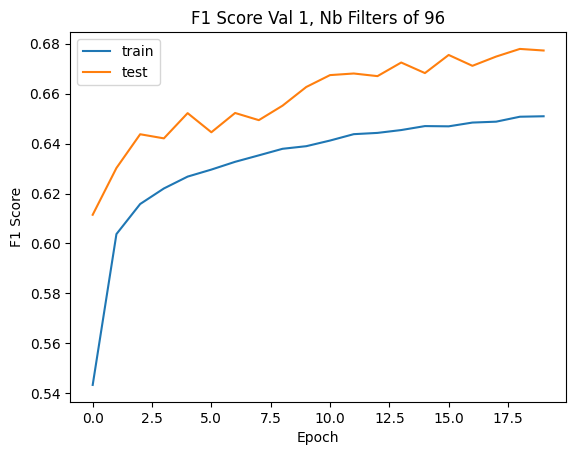

87/87 [==============================] - 1s 8ms/step
{'accuracy': 0.9114759572704344, 'F1-FIX': 0.9462878009559123, 'F1-SACC': 0.8959957670795168, 'F1-SP': 0.7798688468387205, 'F1-NOISE': 0.7074698924231863}
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_36 (TCN)                (None, 385, 96)           1131744   
                                                                 
 time_distributed_36 (TimeDi  (None, 385, 5)           485       
 stributed)                                                      
                                                                 
Total params: 1,132,229
Trainable params: 1,132,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

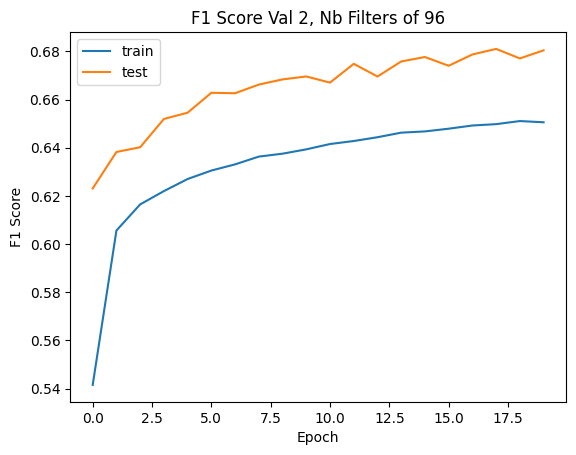

87/87 [==============================] - 2s 8ms/step
{'accuracy': 0.902442884894895, 'F1-FIX': 0.9399689890676213, 'F1-SACC': 0.8938103507611932, 'F1-SP': 0.7587703230943154, 'F1-NOISE': 0.7084461992637231}
Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_37 (TCN)                (None, 385, 96)           1131744   
                                                                 
 time_distributed_37 (TimeDi  (None, 385, 5)           485       
 stributed)                                                      
                                                                 
Total params: 1,132,229
Trainable params: 1,132,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [===================

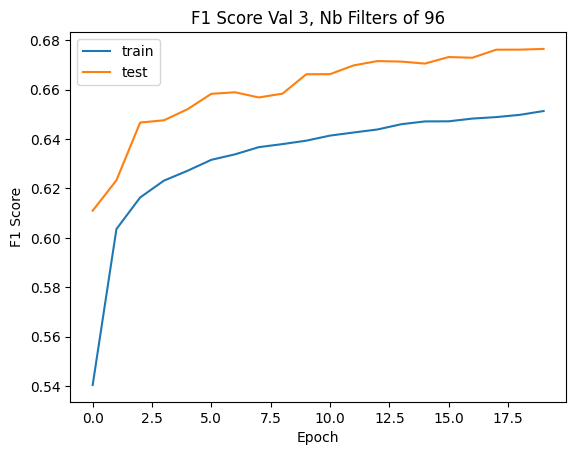

87/87 [==============================] - 1s 8ms/step
{'accuracy': 0.9086551080212797, 'F1-FIX': 0.9446103220891956, 'F1-SACC': 0.8927686657065854, 'F1-SP': 0.7677788147494085, 'F1-NOISE': 0.7084565275229283}
Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_38 (TCN)                (None, 385, 96)           1131744   
                                                                 
 time_distributed_38 (TimeDi  (None, 385, 5)           485       
 stributed)                                                      
                                                                 
Total params: 1,132,229
Trainable params: 1,132,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

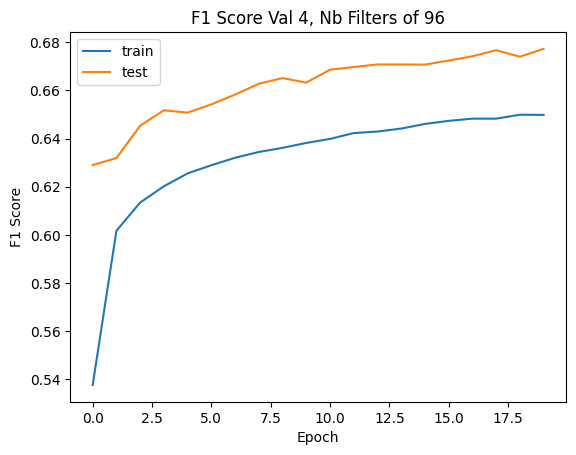

87/87 [==============================] - 1s 8ms/step
{'accuracy': 0.9093091624058665, 'F1-FIX': 0.9450799644493819, 'F1-SACC': 0.895234871918694, 'F1-SP': 0.7629851846350302, 'F1-NOISE': 0.7154818810351261}
Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_39 (TCN)                (None, 385, 96)           1131744   
                                                                 
 time_distributed_39 (TimeDi  (None, 385, 5)           485       
 stributed)                                                      
                                                                 
Total params: 1,132,229
Trainable params: 1,132,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [===================

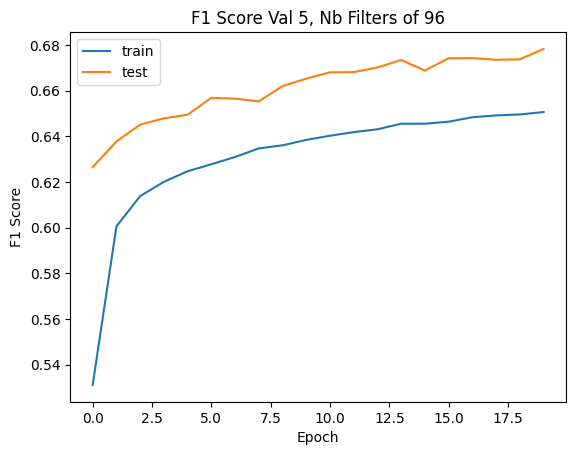

87/87 [==============================] - 1s 8ms/step
{'accuracy': 0.9092291989068519, 'F1-FIX': 0.9449338781345069, 'F1-SACC': 0.8931634963474692, 'F1-SP': 0.7733912711958936, 'F1-NOISE': 0.7194007954406413}
Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_40 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_40 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

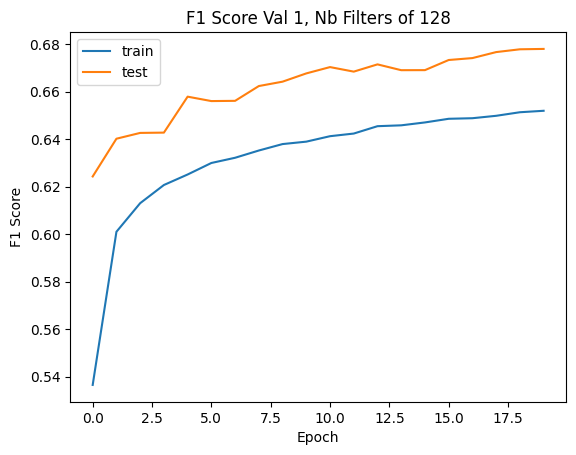

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9121772206969129, 'F1-FIX': 0.9469853705541972, 'F1-SACC': 0.8958820536484549, 'F1-SP': 0.7750991794709904, 'F1-NOISE': 0.7103636896159249}
Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_41 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_41 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

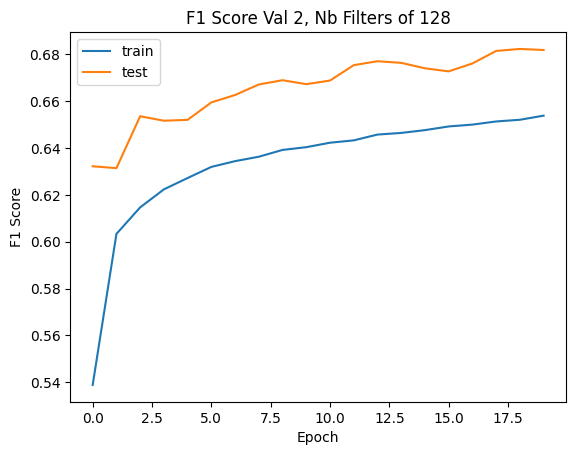

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9056934011298372, 'F1-FIX': 0.9426452281465852, 'F1-SACC': 0.8940891878693494, 'F1-SP': 0.7628751705717142, 'F1-NOISE': 0.7051340051543336}
Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_42 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_42 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

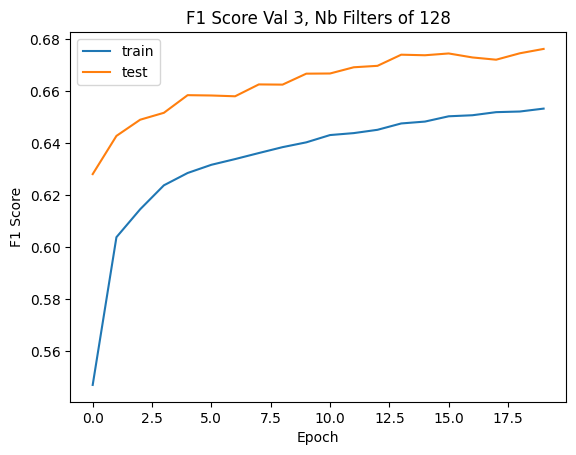

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9095899753994647, 'F1-FIX': 0.9452693361238569, 'F1-SACC': 0.8946295276597704, 'F1-SP': 0.7684512609409581, 'F1-NOISE': 0.7075377741135279}
Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_43 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_43 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

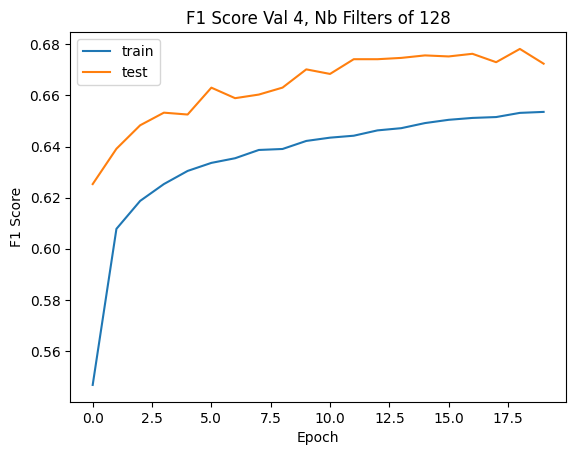

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9101377253677145, 'F1-FIX': 0.9458751826340985, 'F1-SACC': 0.8966484190664307, 'F1-SP': 0.7490532641048195, 'F1-NOISE': 0.710773660851783}
Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_44 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_44 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

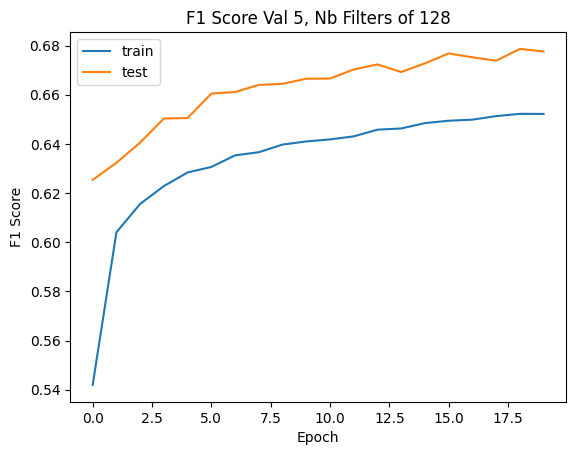

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.911640333588903, 'F1-FIX': 0.9464692885522039, 'F1-SACC': 0.8959067136875735, 'F1-SP': 0.7777537879966048, 'F1-NOISE': 0.7209651529903516}
time: 50min 8s (started: 2023-06-30 18:33:59 +00:00)


In [ ]:
nb_filters_space = [64, 96, 128]
for i in nb_filters_space:
  kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
  fold_var = 1

  for train_index, val_index in kf.split(train_df, label):
    training_data = train_df[train_index]
    training_label = label[train_index]
    validation_data = train_df[val_index]
    validation_label = label[val_index]

    # CREATE NEW MODEL
    model = create_model(
      num_classes = 5,
      train_data_shape = training_data.shape,
      dropout_rate = 0.3,
      nb_filters = i,
      nb_stacks = 1,
      kernel_size = 8,
      dilation_count = 8,
      padding_mode = 'same',
  )

    batch_size = 128

    history_tuned = model.fit(
        training_data, training_label,
        epochs = 20,
        batch_size = batch_size,
        shuffle = True,
        validation_split = 0.1,
        verbose = 1,
        initial_epoch = 0
    )

    plt.plot(history_tuned.history['f1_score'])
    plt.plot(history_tuned.history['val_f1_score'])
    plt.title('F1 Score Val {}, Nb Filters of {}'.format(fold_var, i))
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    fold_var += 1

    raw, preprocessed = evaluate_test_cv(
        model,
        validation_data,
        validation_label,
        batch_size
    )

    print(preprocessed)

#### Nb Stacks

Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_45 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_45 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==============================] - 21s 41ms/step - loss: 0.5062 - accuracy: 0.8390 - f1_score: 0.5445 - f1_SP: 0.4735 - f1_FIX: 0.9045 - f1_SACC: 0.8081 - f1_NOISE: 0.5365 - val_loss: 0.3848 - val_accuracy: 0.8750 - val_f1_scor

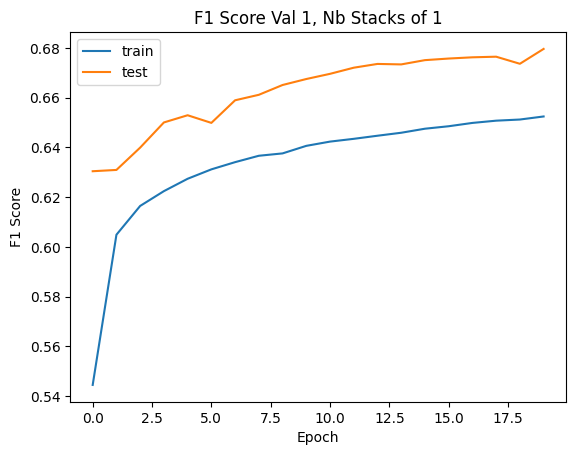

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9092788063000828, 'F1-FIX': 0.9448281155680812, 'F1-SACC': 0.8962040907342509, 'F1-SP': 0.7785565205534952, 'F1-NOISE': 0.7070444496362804}
Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_46 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_46 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

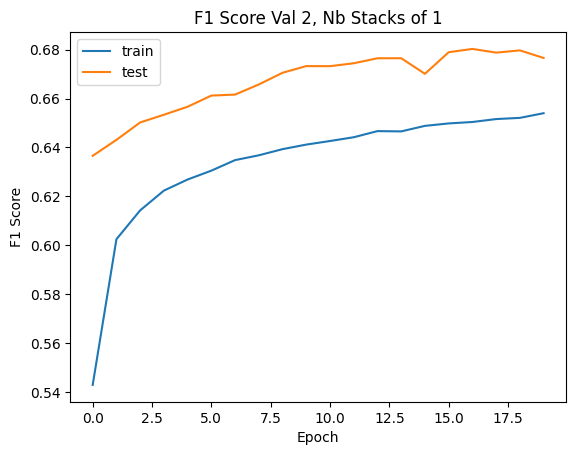

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9089439173647794, 'F1-FIX': 0.9449045513903114, 'F1-SACC': 0.8947273316077086, 'F1-SP': 0.7556468195641237, 'F1-NOISE': 0.7141404064928453}
Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_47 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_47 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

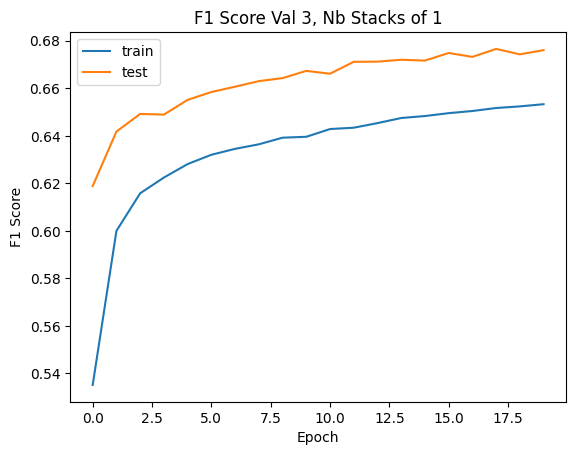

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9110199109112547, 'F1-FIX': 0.9461361278251286, 'F1-SACC': 0.8962674079088122, 'F1-SP': 0.7715497459470834, 'F1-NOISE': 0.7132987101650317}
Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_48 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_48 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

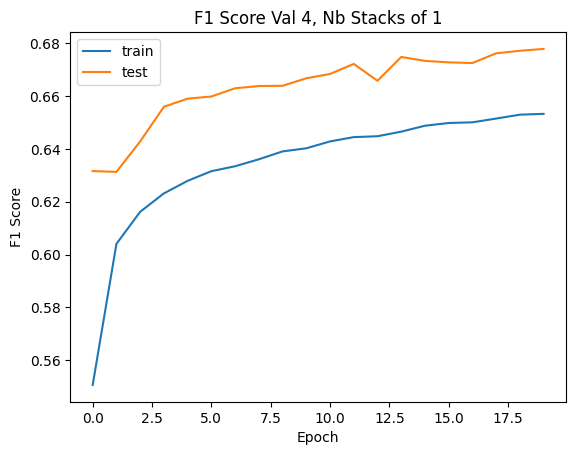

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9097745970074836, 'F1-FIX': 0.9453401517092714, 'F1-SACC': 0.8951717323693243, 'F1-SP': 0.7662534636878797, 'F1-NOISE': 0.7072282288868355}
Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_49 (TCN)                (None, 385, 128)          2000512   
                                                                 
 time_distributed_49 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 2,001,157
Trainable params: 2,001,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

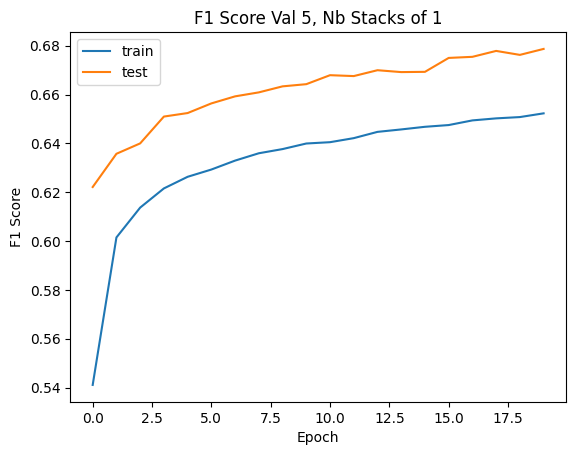

87/87 [==============================] - 1s 10ms/step
{'accuracy': 0.9078361877166659, 'F1-FIX': 0.9436913306470488, 'F1-SACC': 0.8942515871638556, 'F1-SP': 0.7748249948603897, 'F1-NOISE': 0.7194469860537093}
Model: "model_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_50 (TCN)                (None, 385, 128)          4099712   
                                                                 
 time_distributed_50 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 4,100,357
Trainable params: 4,100,357
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

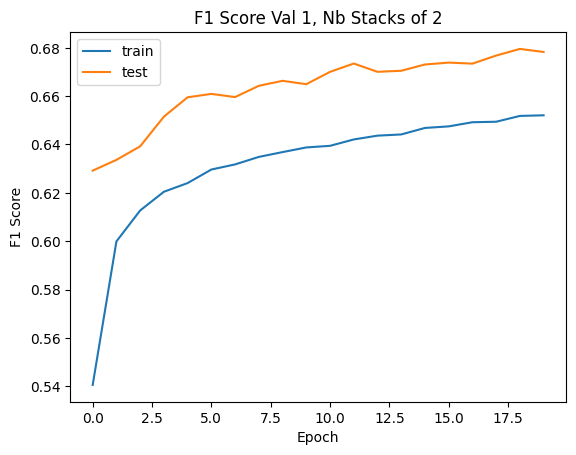

87/87 [==============================] - 2s 18ms/step
{'accuracy': 0.9114971221625816, 'F1-FIX': 0.9461766971299967, 'F1-SACC': 0.8954821980670271, 'F1-SP': 0.7834420854577855, 'F1-NOISE': 0.7120921779028602}
Model: "model_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_52 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_51 (TCN)                (None, 385, 128)          4099712   
                                                                 
 time_distributed_51 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 4,100,357
Trainable params: 4,100,357
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

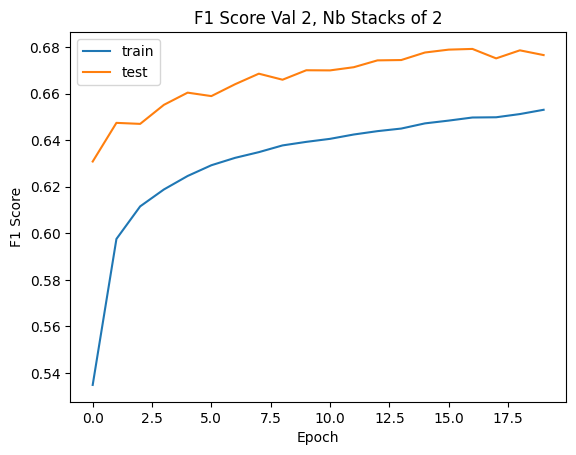

87/87 [==============================] - 2s 18ms/step
{'accuracy': 0.9068928536150557, 'F1-FIX': 0.9432943966436627, 'F1-SACC': 0.8942533078582495, 'F1-SP': 0.7594999674571351, 'F1-NOISE': 0.7039333943138016}
Model: "model_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_52 (TCN)                (None, 385, 128)          4099712   
                                                                 
 time_distributed_52 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 4,100,357
Trainable params: 4,100,357
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

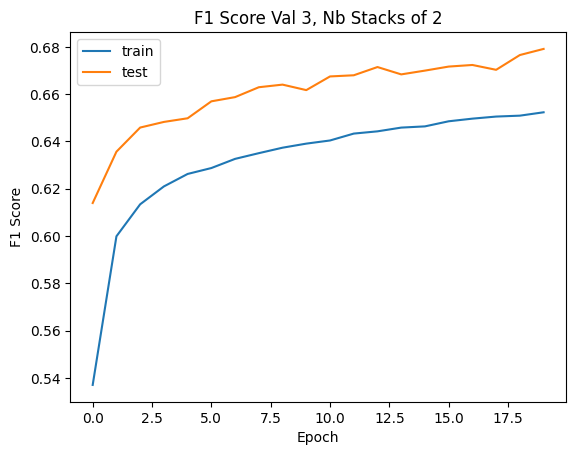

87/87 [==============================] - 2s 18ms/step
{'accuracy': 0.907251748613574, 'F1-FIX': 0.9438448299335349, 'F1-SACC': 0.8935860796855054, 'F1-SP': 0.7680218295965582, 'F1-NOISE': 0.7081073473517823}
Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_53 (TCN)                (None, 385, 128)          4099712   
                                                                 
 time_distributed_53 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 4,100,357
Trainable params: 4,100,357
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

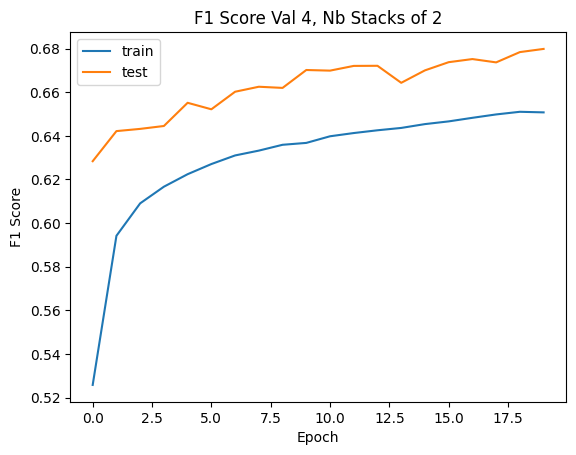

87/87 [==============================] - 2s 18ms/step
{'accuracy': 0.9104999129808982, 'F1-FIX': 0.9456262319859052, 'F1-SACC': 0.8971584145579111, 'F1-SP': 0.7683081009224265, 'F1-NOISE': 0.7169763386320648}
Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_54 (TCN)                (None, 385, 128)          4099712   
                                                                 
 time_distributed_54 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 4,100,357
Trainable params: 4,100,357
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

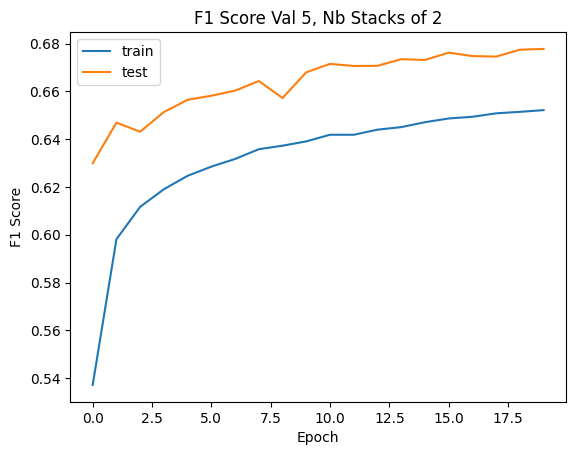

87/87 [==============================] - 2s 18ms/step
{'accuracy': 0.9088907651566108, 'F1-FIX': 0.9444568401140263, 'F1-SACC': 0.8938752622566932, 'F1-SP': 0.7757710159102924, 'F1-NOISE': 0.7171101780063919}
Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_55 (TCN)                (None, 385, 128)          6198912   
                                                                 
 time_distributed_55 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 6,199,557
Trainable params: 6,199,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

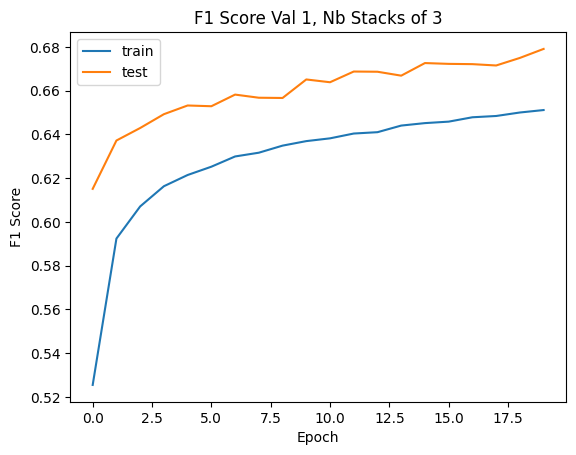

87/87 [==============================] - 3s 26ms/step
{'accuracy': 0.9092348303575103, 'F1-FIX': 0.944738277832046, 'F1-SACC': 0.8941585953124169, 'F1-SP': 0.7830699934323947, 'F1-NOISE': 0.7003811982429946}
Model: "model_56"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_56 (TCN)                (None, 385, 128)          6198912   
                                                                 
 time_distributed_56 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 6,199,557
Trainable params: 6,199,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

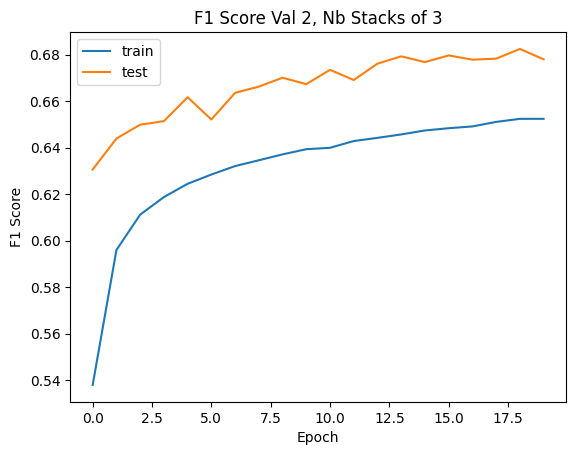

87/87 [==============================] - 3s 26ms/step
{'accuracy': 0.908675569269557, 'F1-FIX': 0.9446891581990555, 'F1-SACC': 0.8967605232074048, 'F1-SP': 0.751536658926427, 'F1-NOISE': 0.7016264822806954}
Model: "model_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_57 (TCN)                (None, 385, 128)          6198912   
                                                                 
 time_distributed_57 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 6,199,557
Trainable params: 6,199,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [===================

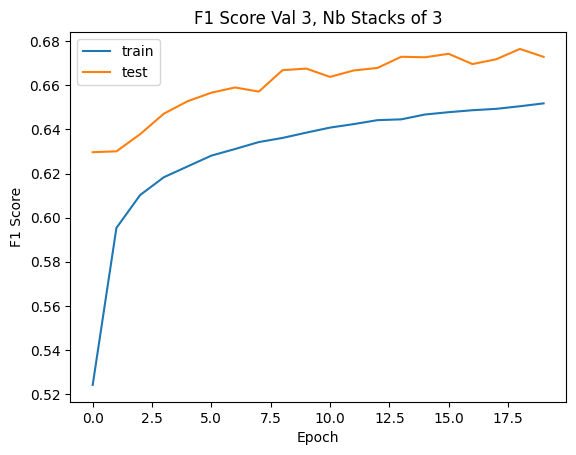

87/87 [==============================] - 3s 26ms/step
{'accuracy': 0.908751299406859, 'F1-FIX': 0.9450372096524828, 'F1-SACC': 0.8966840491306033, 'F1-SP': 0.7462420076328398, 'F1-NOISE': 0.7179743696855266}
Model: "model_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_59 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_58 (TCN)                (None, 385, 128)          6198912   
                                                                 
 time_distributed_58 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 6,199,557
Trainable params: 6,199,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

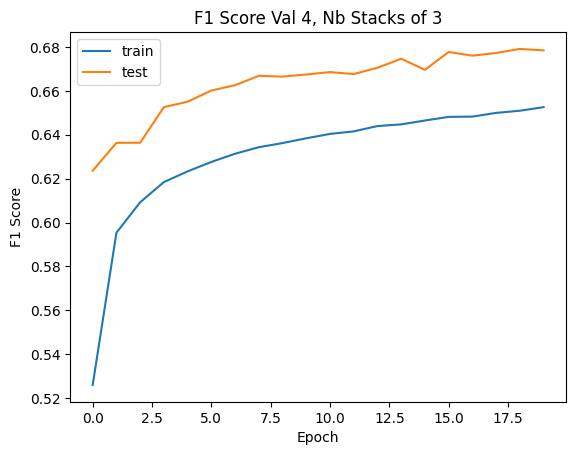

87/87 [==============================] - 3s 26ms/step
{'accuracy': 0.9088707742818573, 'F1-FIX': 0.9445391211210774, 'F1-SACC': 0.8948719817437998, 'F1-SP': 0.7650987024767557, 'F1-NOISE': 0.7125194539944354}
Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_59 (TCN)                (None, 385, 128)          6198912   
                                                                 
 time_distributed_59 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 6,199,557
Trainable params: 6,199,557
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

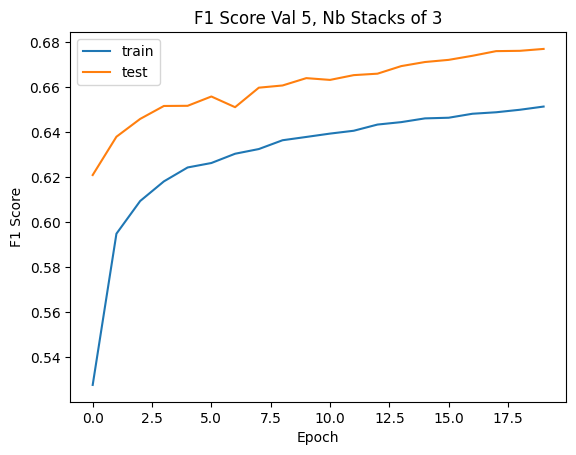

87/87 [==============================] - 3s 26ms/step
{'accuracy': 0.910409601264364, 'F1-FIX': 0.945669396905539, 'F1-SACC': 0.8940394467443051, 'F1-SP': 0.7740953730428073, 'F1-NOISE': 0.7217598417085095}
Model: "model_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_61 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_60 (TCN)                (None, 385, 128)          8298112   
                                                                 
 time_distributed_60 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 8,298,757
Trainable params: 8,298,757
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [===================

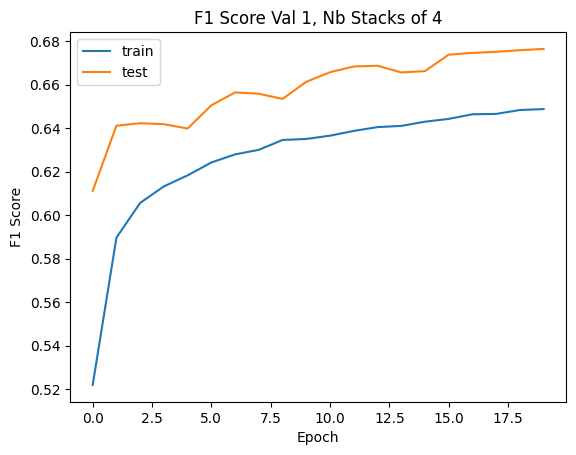

87/87 [==============================] - 4s 33ms/step
{'accuracy': 0.9098831815536207, 'F1-FIX': 0.9455038789698305, 'F1-SACC': 0.8904930654303841, 'F1-SP': 0.7778680906475598, 'F1-NOISE': 0.6995523932406504}
Model: "model_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_62 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_61 (TCN)                (None, 385, 128)          8298112   
                                                                 
 time_distributed_61 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 8,298,757
Trainable params: 8,298,757
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

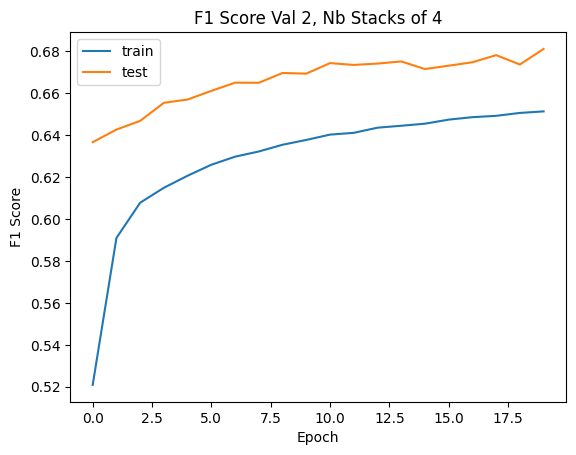

87/87 [==============================] - 4s 34ms/step
{'accuracy': 0.9082369459587859, 'F1-FIX': 0.9442113041701601, 'F1-SACC': 0.8943541901658021, 'F1-SP': 0.7702507845961634, 'F1-NOISE': 0.713811631718137}
Model: "model_62"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_63 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_62 (TCN)                (None, 385, 128)          8298112   
                                                                 
 time_distributed_62 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 8,298,757
Trainable params: 8,298,757
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

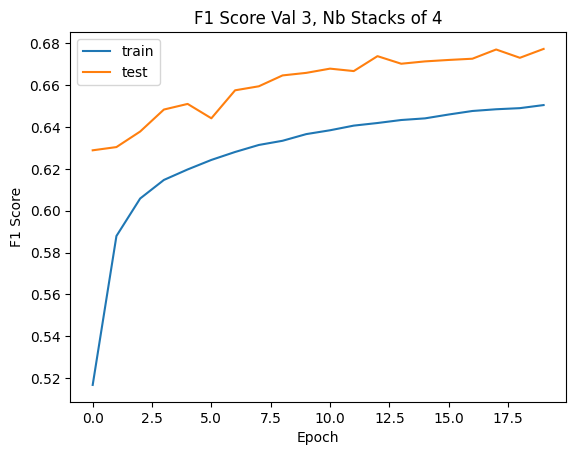

87/87 [==============================] - 5s 34ms/step
{'accuracy': 0.9080438576273419, 'F1-FIX': 0.9441949170781312, 'F1-SACC': 0.8933510010731442, 'F1-SP': 0.768373504162131, 'F1-NOISE': 0.7086590233117147}
Model: "model_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_64 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_63 (TCN)                (None, 385, 128)          8298112   
                                                                 
 time_distributed_63 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 8,298,757
Trainable params: 8,298,757
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==================

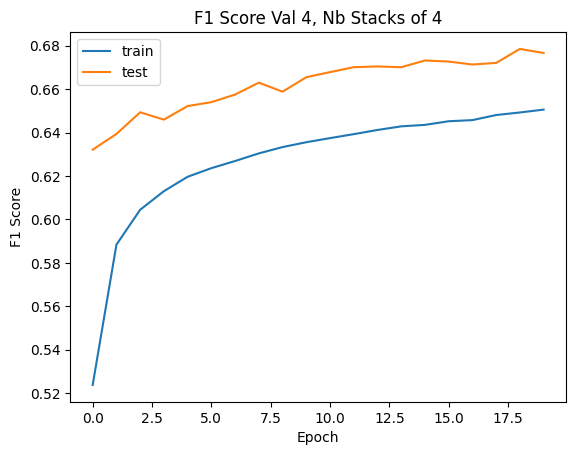

87/87 [==============================] - 4s 34ms/step
{'accuracy': 0.9092494249683674, 'F1-FIX': 0.9449278550516652, 'F1-SACC': 0.8939671333043837, 'F1-SP': 0.7591859396616856, 'F1-NOISE': 0.7217603628478304}
Model: "model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_65 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_64 (TCN)                (None, 385, 128)          8298112   
                                                                 
 time_distributed_64 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 8,298,757
Trainable params: 8,298,757
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=================

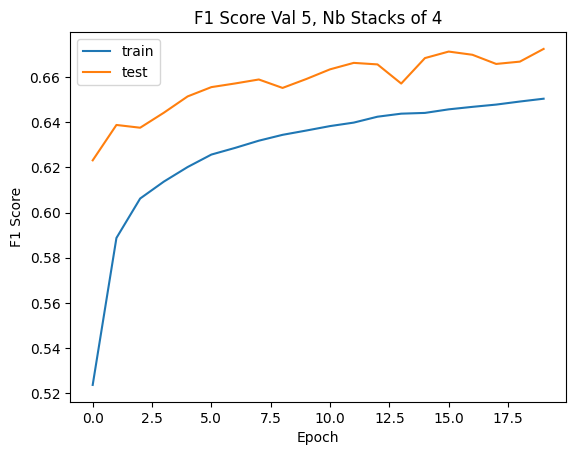

87/87 [==============================] - 5s 34ms/step
{'accuracy': 0.9070671270055551, 'F1-FIX': 0.9438896214905402, 'F1-SACC': 0.8898296258600767, 'F1-SP': 0.7696254150159253, 'F1-NOISE': 0.7045232565970111}
Model: "model_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_66 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_65 (TCN)                (None, 385, 128)          10397312  
                                                                 
 time_distributed_65 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 10,397,957
Trainable params: 10,397,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [===============

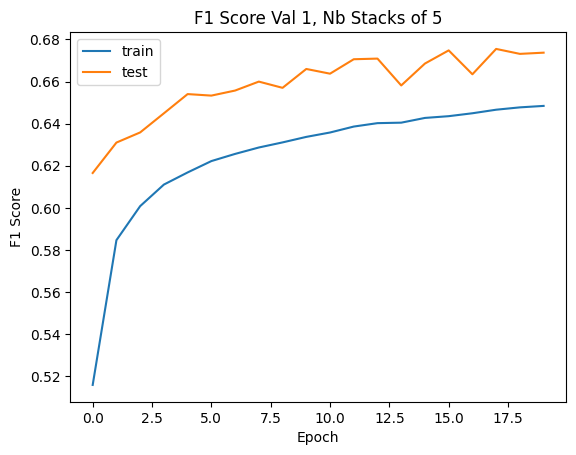

87/87 [==============================] - 6s 42ms/step
{'accuracy': 0.9097364383013998, 'F1-FIX': 0.945401352567446, 'F1-SACC': 0.8885209377391439, 'F1-SP': 0.7757013390236799, 'F1-NOISE': 0.7030983856929213}
Model: "model_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_67 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_66 (TCN)                (None, 385, 128)          10397312  
                                                                 
 time_distributed_66 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 10,397,957
Trainable params: 10,397,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [================

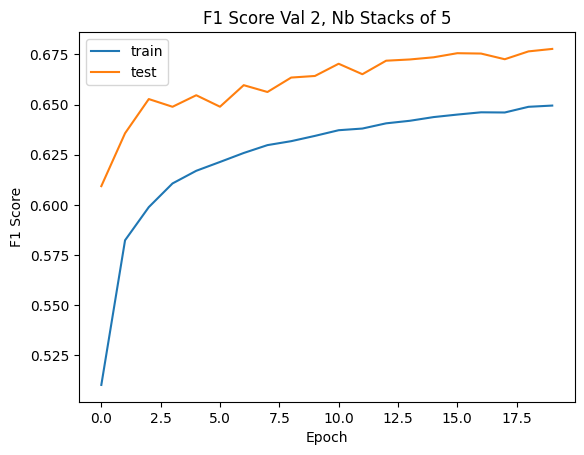

87/87 [==============================] - 6s 41ms/step
{'accuracy': 0.9076266363118953, 'F1-FIX': 0.9443144639468884, 'F1-SACC': 0.8905567796325728, 'F1-SP': 0.7579525959799334, 'F1-NOISE': 0.7050303716988655}
Model: "model_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_68 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_67 (TCN)                (None, 385, 128)          10397312  
                                                                 
 time_distributed_67 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 10,397,957
Trainable params: 10,397,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [===============

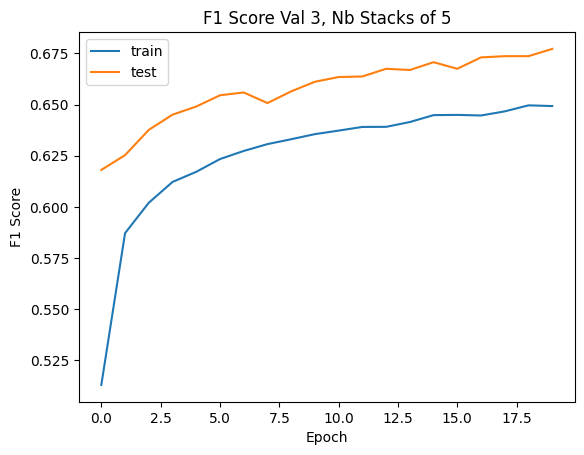

87/87 [==============================] - 6s 42ms/step
{'accuracy': 0.9056846992196503, 'F1-FIX': 0.9426256771458783, 'F1-SACC': 0.8948177707622029, 'F1-SP': 0.761573222689008, 'F1-NOISE': 0.7074921433547932}
Model: "model_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_69 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_68 (TCN)                (None, 385, 128)          10397312  
                                                                 
 time_distributed_68 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 10,397,957
Trainable params: 10,397,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [================

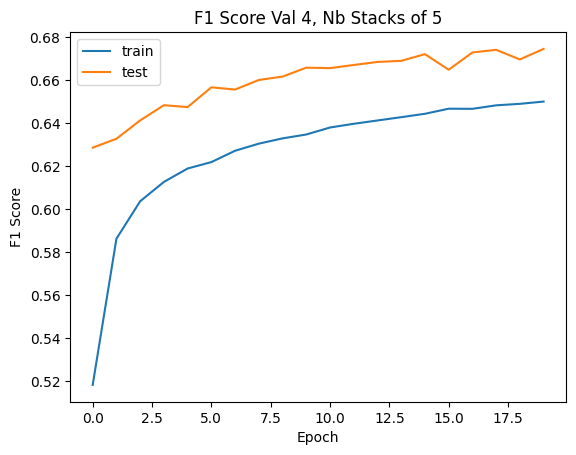

87/87 [==============================] - 6s 42ms/step
{'accuracy': 0.9090876164762438, 'F1-FIX': 0.9449131886373697, 'F1-SACC': 0.8926702152377054, 'F1-SP': 0.7611378573713329, 'F1-NOISE': 0.7128310345500564}
Model: "model_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_70 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_69 (TCN)                (None, 385, 128)          10397312  
                                                                 
 time_distributed_69 (TimeDi  (None, 385, 5)           645       
 stributed)                                                      
                                                                 
Total params: 10,397,957
Trainable params: 10,397,957
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [===============

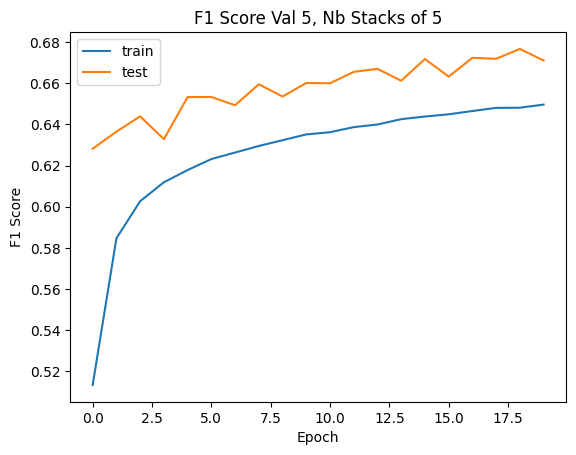

87/87 [==============================] - 6s 42ms/step
{'accuracy': 0.9077806836408793, 'F1-FIX': 0.9445162789569432, 'F1-SACC': 0.8912066484696389, 'F1-SP': 0.7536079831266925, 'F1-NOISE': 0.7033803847926771}
time: 4h 40min 49s (started: 2023-06-30 19:30:01 +00:00)


In [ ]:
nb_stacks_space = [1, 2, 3, 4, 5]
for i in nb_stacks_space:
  kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
  fold_var = 1

  for train_index, val_index in kf.split(train_df, label):
    training_data = train_df[train_index]
    training_label = label[train_index]
    validation_data = train_df[val_index]
    validation_label = label[val_index]

    # CREATE NEW MODEL
    model = create_model(
      num_classes = 5,
      train_data_shape = training_data.shape,
      dropout_rate = 0.3,
      nb_filters = 128,
      nb_stacks = i,
      kernel_size = 8,
      dilation_count = 8,
      padding_mode = 'same',
  )

    batch_size = 128

    history_tuned = model.fit(
        training_data, training_label,
        epochs = 20,
        batch_size = batch_size,
        shuffle = True,
        validation_split = 0.1,
        verbose = 1,
        initial_epoch = 0
    )

    plt.plot(history_tuned.history['f1_score'])
    plt.plot(history_tuned.history['val_f1_score'])
    plt.title('F1 Score Val {}, Nb Stacks of {}'.format(fold_var, i))
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    fold_var += 1

    raw, preprocessed = evaluate_test_cv(
        model,
        validation_data,
        validation_label,
        batch_size
    )

    print(preprocessed)

#### Kernel Size

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn (TCN)                   (None, 385, 64)           192576    
                                                                 
 time_distributed (TimeDistr  (None, 385, 5)           325       
 ibuted)                                                         
                                                                 
Total params: 192,901
Trainable params: 192,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==============================] - 26s 24ms/step - loss: 0.5155 - accuracy: 0.8343 - f1_score: 0.4932 - f1_SP: 0.3499 - f1_FIX: 0.9045 - f1_SACC: 0.7829 - f1_NOISE: 0.4287 - val_loss: 0.4047 - val_accuracy: 0.8623 - val_f1_score: 0.59

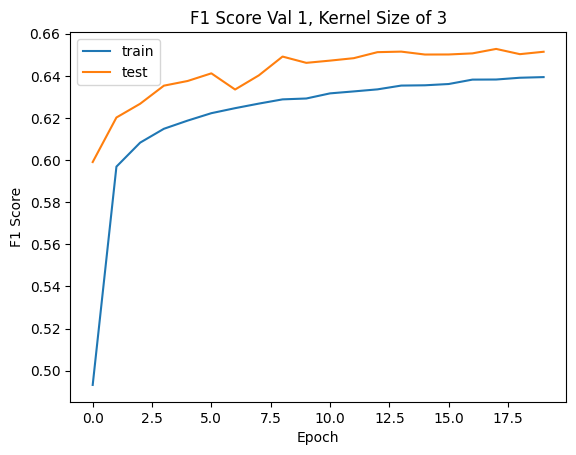

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9018663907391838, 'F1-FIX': 0.9407722991251728, 'F1-SACC': 0.8894424459774255, 'F1-SP': 0.7213038994636357, 'F1-NOISE': 0.7034586138545074}
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_1 (TCN)                 (None, 385, 64)           192576    
                                                                 
 time_distributed_1 (TimeDis  (None, 385, 5)           325       
 tributed)                                                       
                                                                 
Total params: 192,901
Trainable params: 192,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

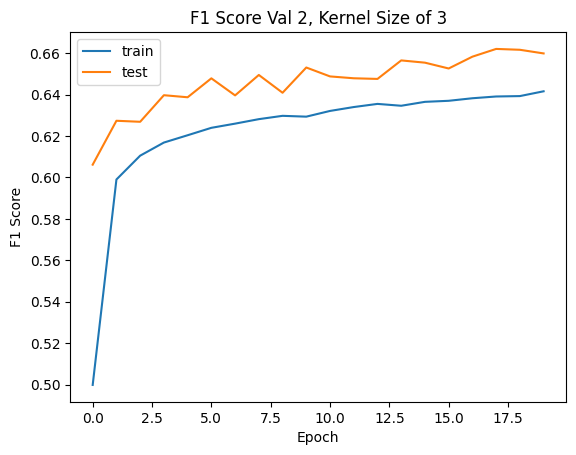

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.8999887110354332, 'F1-FIX': 0.9396432415858068, 'F1-SACC': 0.889724152721667, 'F1-SP': 0.7248057383677446, 'F1-NOISE': 0.7014457427387503}
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_2 (TCN)                 (None, 385, 64)           192576    
                                                                 
 time_distributed_2 (TimeDis  (None, 385, 5)           325       
 tributed)                                                       
                                                                 
Total params: 192,901
Trainable params: 192,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [========================

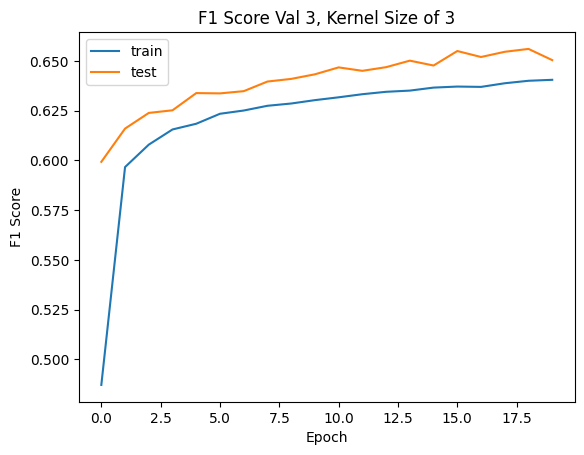

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.899102997690466, 'F1-FIX': 0.9393313957837937, 'F1-SACC': 0.8858076328043936, 'F1-SP': 0.7052837448575537, 'F1-NOISE': 0.6963542039936048}
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_3 (TCN)                 (None, 385, 64)           192576    
                                                                 
 time_distributed_3 (TimeDis  (None, 385, 5)           325       
 tributed)                                                       
                                                                 
Total params: 192,901
Trainable params: 192,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [========================

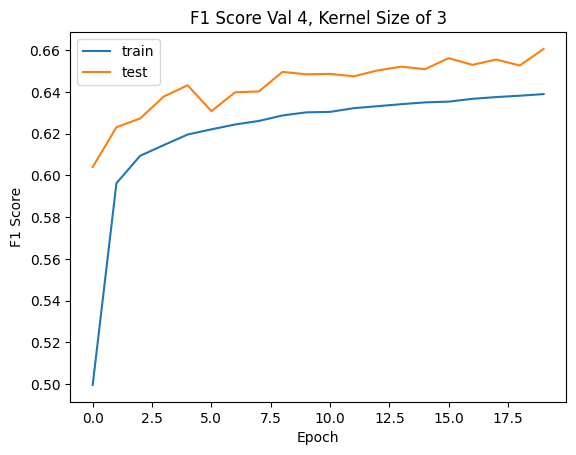

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9005312868949232, 'F1-FIX': 0.9399474812970784, 'F1-SACC': 0.8888989069432562, 'F1-SP': 0.7200879494880249, 'F1-NOISE': 0.7082743580870983}
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_4 (TCN)                 (None, 385, 64)           192576    
                                                                 
 time_distributed_4 (TimeDis  (None, 385, 5)           325       
 tributed)                                                       
                                                                 
Total params: 192,901
Trainable params: 192,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

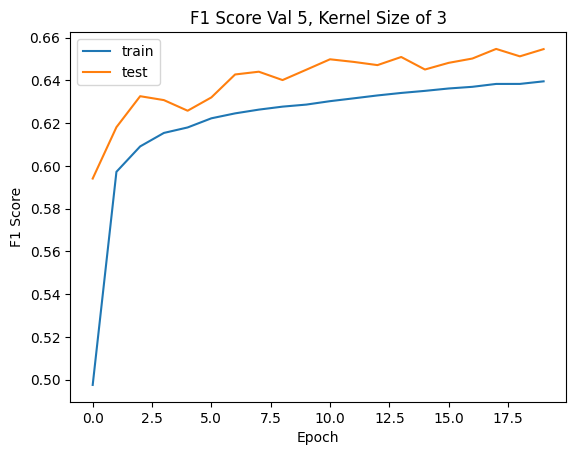

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.8997843337394225, 'F1-FIX': 0.9398064855277696, 'F1-SACC': 0.8857220557383785, 'F1-SP': 0.7202341553861374, 'F1-NOISE': 0.7056416760850462}
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_5 (TCN)                 (None, 385, 64)           255808    
                                                                 
 time_distributed_5 (TimeDis  (None, 385, 5)           325       
 tributed)                                                       
                                                                 
Total params: 256,133
Trainable params: 256,133
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

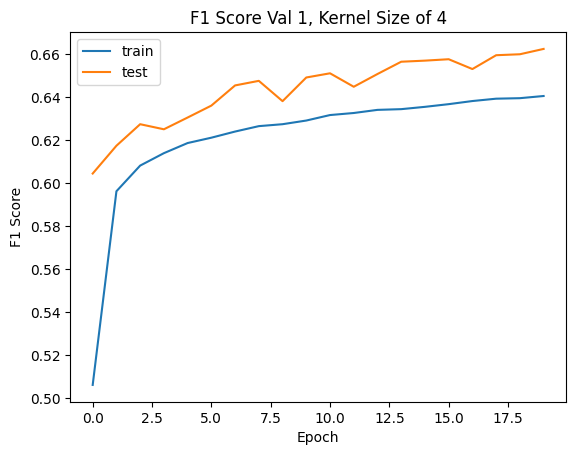

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9025135661079527, 'F1-FIX': 0.9409766008825603, 'F1-SACC': 0.8873201464912213, 'F1-SP': 0.7488850962735478, 'F1-NOISE': 0.6975275775759162}
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_6 (TCN)                 (None, 385, 64)           255808    
                                                                 
 time_distributed_6 (TimeDis  (None, 385, 5)           325       
 tributed)                                                       
                                                                 
Total params: 256,133
Trainable params: 256,133
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

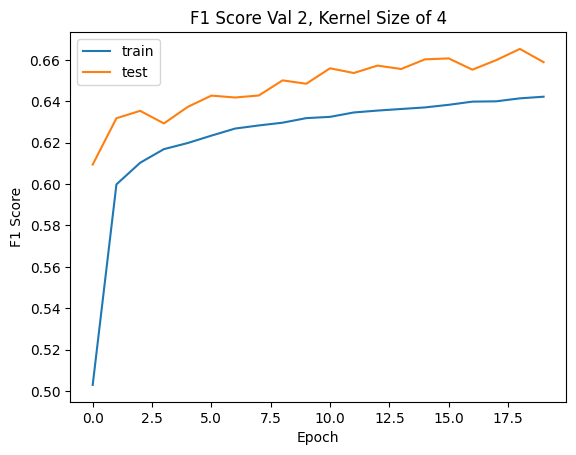

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9013229255351675, 'F1-FIX': 0.9405676943758576, 'F1-SACC': 0.8885380416801371, 'F1-SP': 0.7232741240057631, 'F1-NOISE': 0.6957502565550491}
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_7 (TCN)                 (None, 385, 64)           255808    
                                                                 
 time_distributed_7 (TimeDis  (None, 385, 5)           325       
 tributed)                                                       
                                                                 
Total params: 256,133
Trainable params: 256,133
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

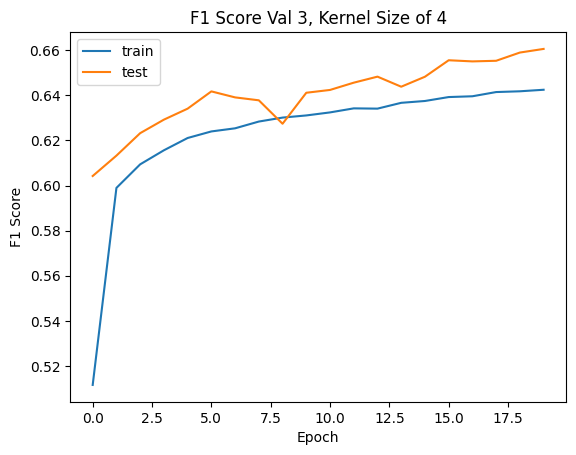

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.897574283738717, 'F1-FIX': 0.9378240175751112, 'F1-SACC': 0.8889317409825171, 'F1-SP': 0.7291233392629509, 'F1-NOISE': 0.7044986826089054}
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 385, 28)]         0         
                                                                 
 tcn_8 (TCN)                 (None, 385, 64)           255808    
                                                                 
 time_distributed_8 (TimeDis  (None, 385, 5)           325       
 tributed)                                                       
                                                                 
Total params: 256,133
Trainable params: 256,133
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [========================

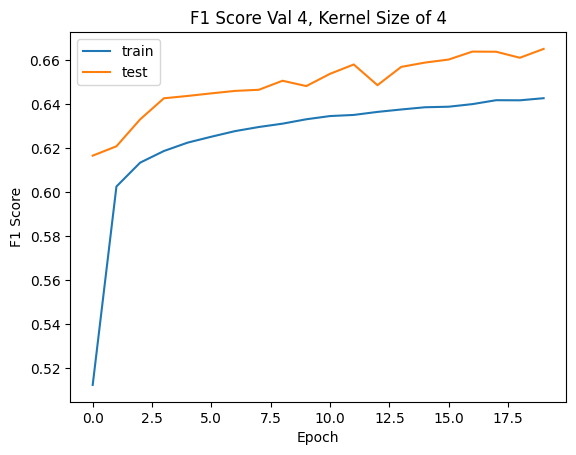

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.8989482448011966, 'F1-FIX': 0.9384180699811524, 'F1-SACC': 0.8874846474765008, 'F1-SP': 0.7363976851484778, 'F1-NOISE': 0.7134198482288082}
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_9 (TCN)                 (None, 385, 64)           255808    
                                                                 
 time_distributed_9 (TimeDis  (None, 385, 5)           325       
 tributed)                                                       
                                                                 
Total params: 256,133
Trainable params: 256,133
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

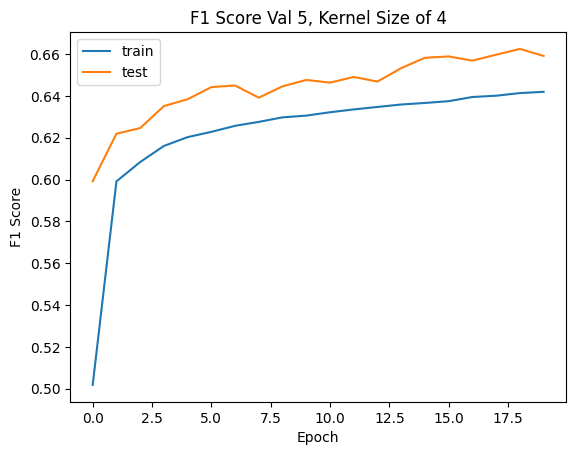

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9011350113124832, 'F1-FIX': 0.9404526568447411, 'F1-SACC': 0.8860811398568583, 'F1-SP': 0.7342667520838111, 'F1-NOISE': 0.708321249585032}
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_10 (TCN)                (None, 385, 64)           319040    
                                                                 
 time_distributed_10 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 319,365
Trainable params: 319,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

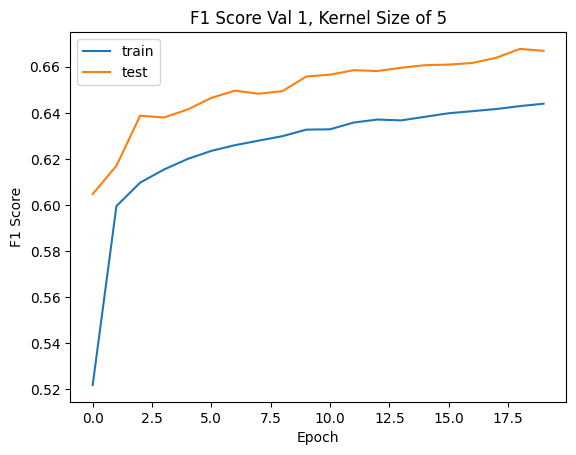

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9056565525918174, 'F1-FIX': 0.9428153761951776, 'F1-SACC': 0.890053444109752, 'F1-SP': 0.7612720604003924, 'F1-NOISE': 0.6985212003539006}
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_11 (TCN)                (None, 385, 64)           319040    
                                                                 
 time_distributed_11 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 319,365
Trainable params: 319,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

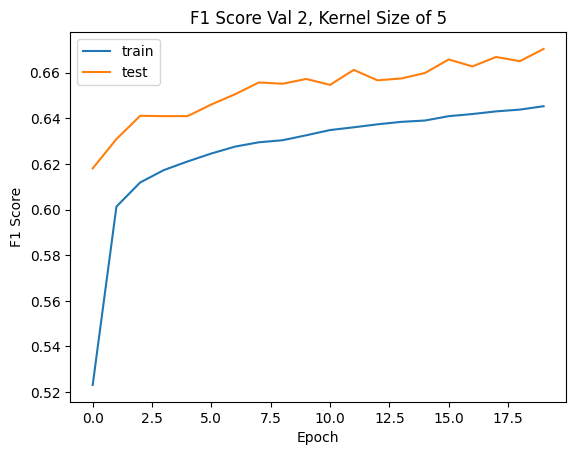

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9040386270737593, 'F1-FIX': 0.942209020324045, 'F1-SACC': 0.890617156282892, 'F1-SP': 0.7488717892800858, 'F1-NOISE': 0.7025976200534572}
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_12 (TCN)                (None, 385, 64)           319040    
                                                                 
 time_distributed_12 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 319,365
Trainable params: 319,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [========================

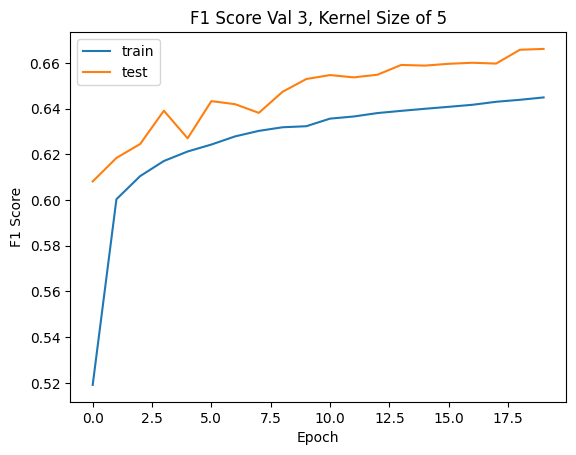

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9020040263973621, 'F1-FIX': 0.9406179458088444, 'F1-SACC': 0.8914538930352143, 'F1-SP': 0.7431583450691152, 'F1-NOISE': 0.7074145386874392}
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_13 (TCN)                (None, 385, 64)           319040    
                                                                 
 time_distributed_13 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 319,365
Trainable params: 319,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

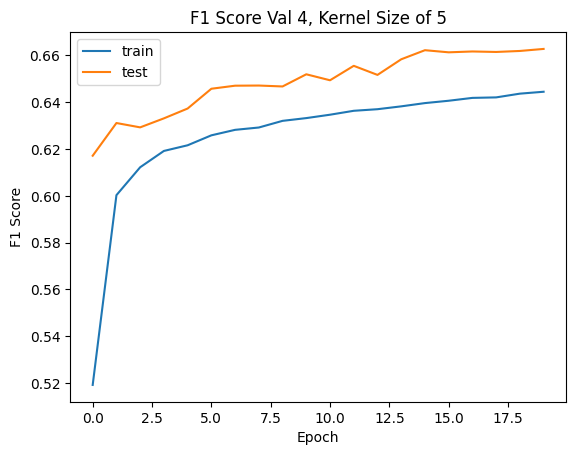

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.90468539066873, 'F1-FIX': 0.9426086912615953, 'F1-SACC': 0.8911371332011944, 'F1-SP': 0.732986361945472, 'F1-NOISE': 0.713821030286516}
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_14 (TCN)                (None, 385, 64)           319040    
                                                                 
 time_distributed_14 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 319,365
Trainable params: 319,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==========================

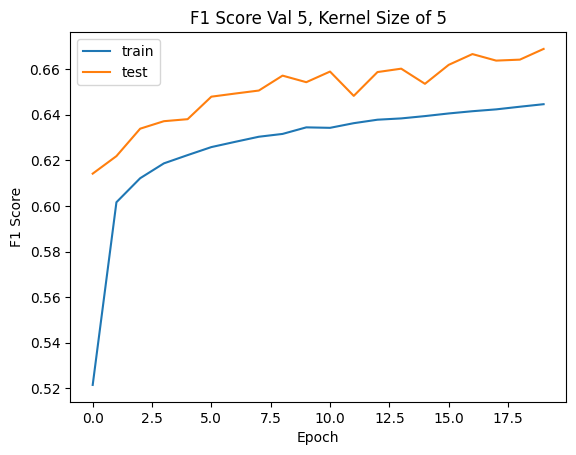

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9023826770838723, 'F1-FIX': 0.9406457033773182, 'F1-SACC': 0.8895474293188379, 'F1-SP': 0.7504813522387709, 'F1-NOISE': 0.7161946792113253}
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_15 (TCN)                (None, 385, 64)           382272    
                                                                 
 time_distributed_15 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 382,597
Trainable params: 382,597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

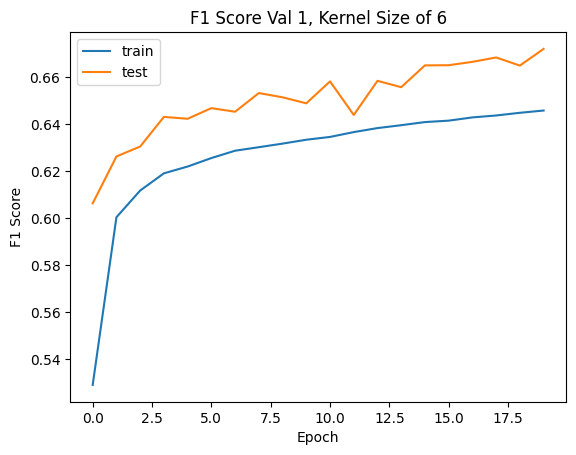

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9075113026403203, 'F1-FIX': 0.9440054724847624, 'F1-SACC': 0.892860865679212, 'F1-SP': 0.7697386642854649, 'F1-NOISE': 0.7018977935207525}
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_16 (TCN)                (None, 385, 64)           382272    
                                                                 
 time_distributed_16 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 382,597
Trainable params: 382,597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

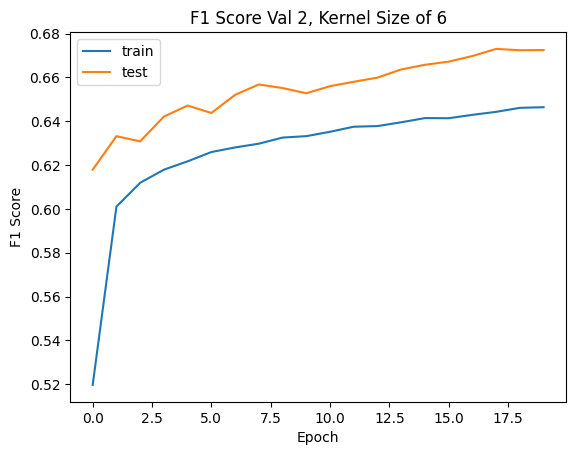

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9007707070184433, 'F1-FIX': 0.9399746670839972, 'F1-SACC': 0.8885886368746144, 'F1-SP': 0.7503852119826719, 'F1-NOISE': 0.6806701465453026}
Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_17 (TCN)                (None, 385, 64)           382272    
                                                                 
 time_distributed_17 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 382,597
Trainable params: 382,597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

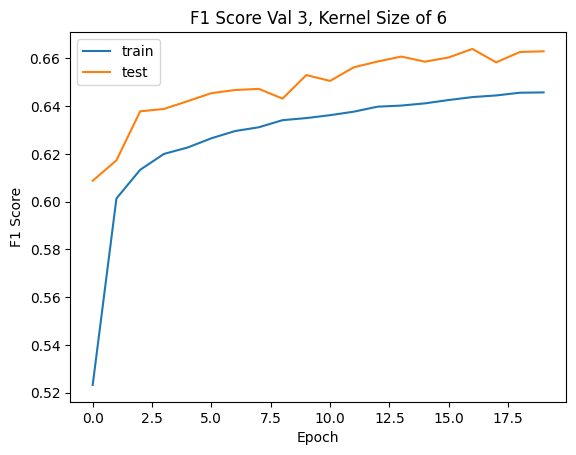

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9045529805218324, 'F1-FIX': 0.9424564712612625, 'F1-SACC': 0.8894493323035553, 'F1-SP': 0.740985597452823, 'F1-NOISE': 0.7036691961781203}
Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_18 (TCN)                (None, 385, 64)           382272    
                                                                 
 time_distributed_18 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 382,597
Trainable params: 382,597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

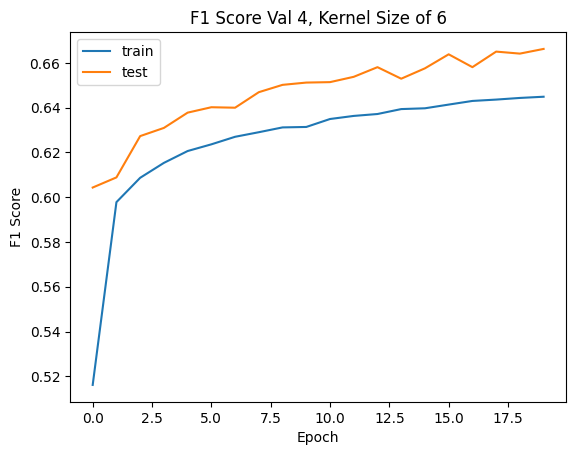

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9052519555779245, 'F1-FIX': 0.9426884119773079, 'F1-SACC': 0.8901355569159832, 'F1-SP': 0.748909161431578, 'F1-NOISE': 0.7108815608796721}
Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_19 (TCN)                (None, 385, 64)           382272    
                                                                 
 time_distributed_19 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 382,597
Trainable params: 382,597
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

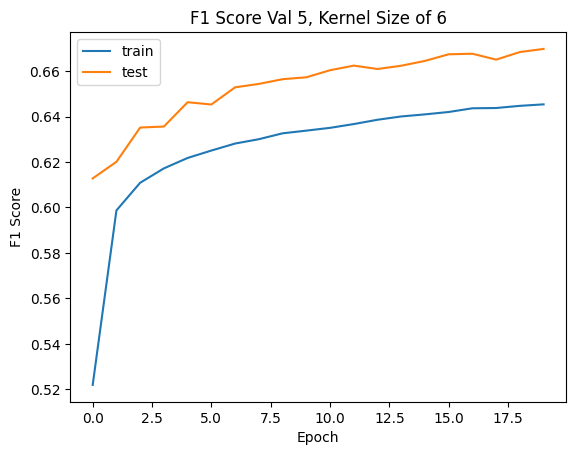

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9049433905464329, 'F1-FIX': 0.9424761135176825, 'F1-SACC': 0.8881525542774212, 'F1-SP': 0.7557095045885134, 'F1-NOISE': 0.7142552188028916}
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_20 (TCN)                (None, 385, 64)           445504    
                                                                 
 time_distributed_20 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 445,829
Trainable params: 445,829
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

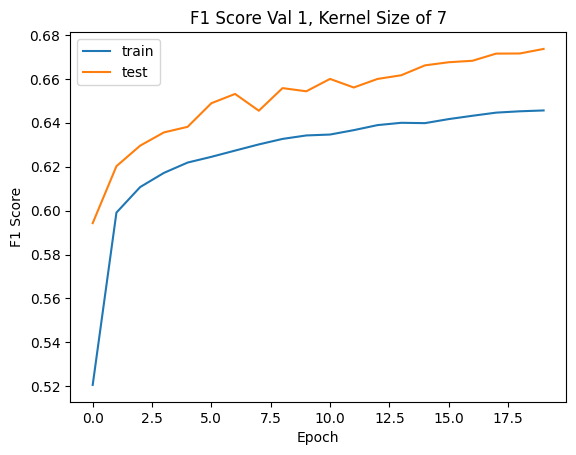

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9071554972867784, 'F1-FIX': 0.9437472989066872, 'F1-SACC': 0.8910122274324478, 'F1-SP': 0.7713879064751312, 'F1-NOISE': 0.7033680162519554}
Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_21 (TCN)                (None, 385, 64)           445504    
                                                                 
 time_distributed_21 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 445,829
Trainable params: 445,829
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

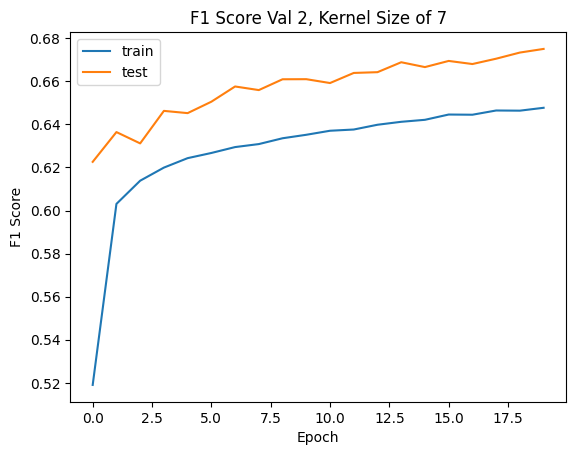

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9007537735715933, 'F1-FIX': 0.9390955870982681, 'F1-SACC': 0.8915045640260599, 'F1-SP': 0.751114752107466, 'F1-NOISE': 0.7073730858478988}
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_22 (TCN)                (None, 385, 64)           445504    
                                                                 
 time_distributed_22 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 445,829
Trainable params: 445,829
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

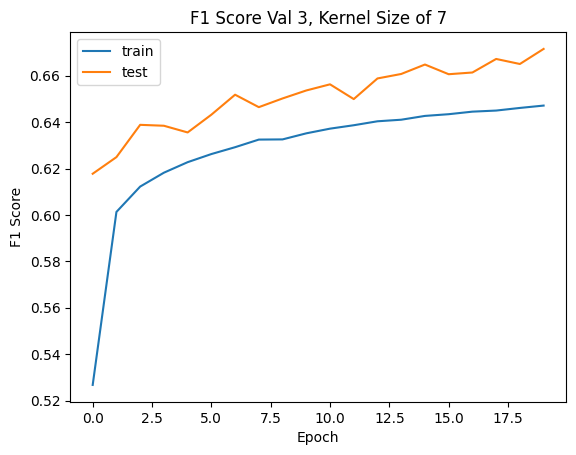

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.90003904100246, 'F1-FIX': 0.9391804848775382, 'F1-SACC': 0.8907411812402912, 'F1-SP': 0.7482593009524221, 'F1-NOISE': 0.7047471525493675}
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_23 (TCN)                (None, 385, 64)           445504    
                                                                 
 time_distributed_23 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 445,829
Trainable params: 445,829
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [========================

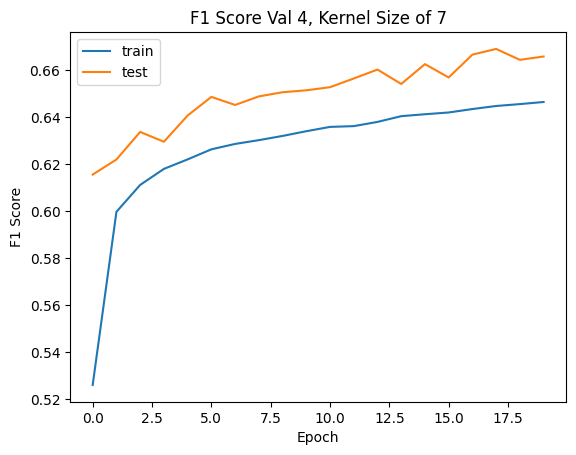

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9058719078820492, 'F1-FIX': 0.9431467974750944, 'F1-SACC': 0.8898669665268808, 'F1-SP': 0.7465380895441922, 'F1-NOISE': 0.7144567273083797}
Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_24 (TCN)                (None, 385, 64)           445504    
                                                                 
 time_distributed_24 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 445,829
Trainable params: 445,829
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

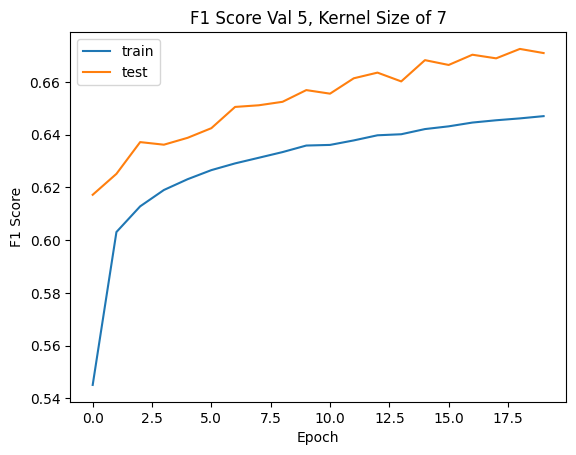

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.905785359153704, 'F1-FIX': 0.9428341341110147, 'F1-SACC': 0.8897186286222607, 'F1-SP': 0.7586110567519265, 'F1-NOISE': 0.7121089908563647}
Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_25 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_25 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

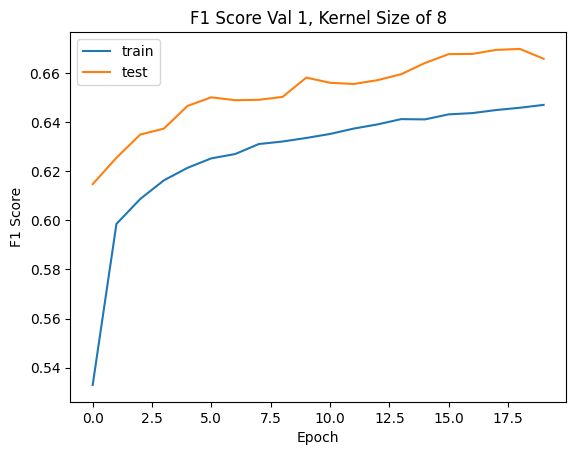

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9082986366281975, 'F1-FIX': 0.9446383625356414, 'F1-SACC': 0.8917506155207843, 'F1-SP': 0.7585812183277151, 'F1-NOISE': 0.7004883660407331}
Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_26 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_26 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

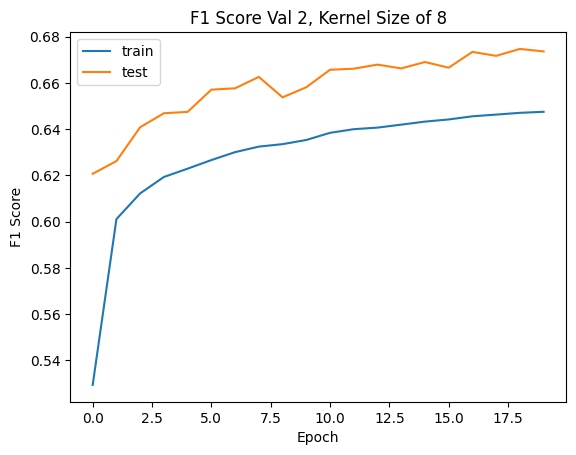

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9060692295752056, 'F1-FIX': 0.9430053755962422, 'F1-SACC': 0.891432617367816, 'F1-SP': 0.7597191462897163, 'F1-NOISE': 0.706783968747802}
Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_27 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_27 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [========================

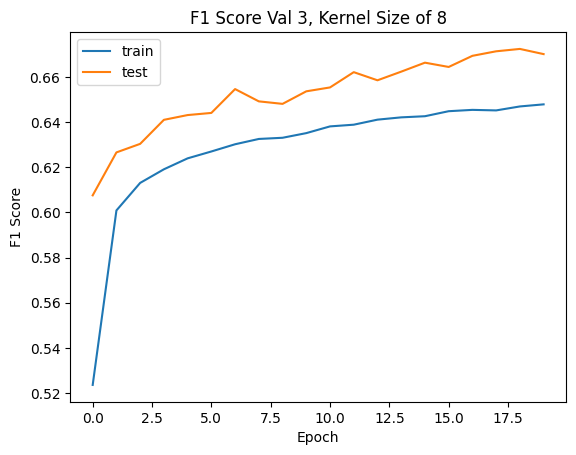

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9060144310597045, 'F1-FIX': 0.9430334477367421, 'F1-SACC': 0.8915130901239802, 'F1-SP': 0.7574804430591374, 'F1-NOISE': 0.7023896038378965}
Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_29 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_28 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_28 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

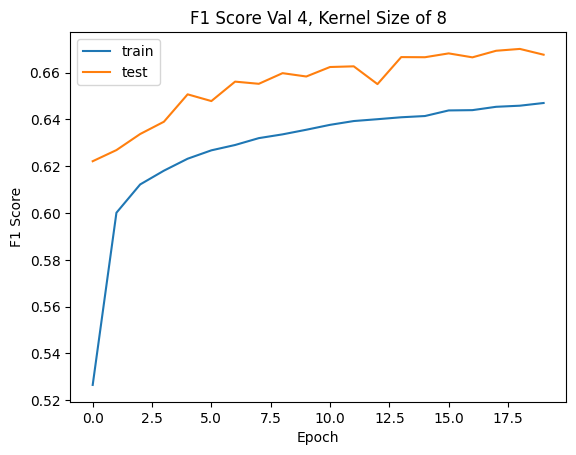

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9067797287826262, 'F1-FIX': 0.9438814969809013, 'F1-SACC': 0.8918838303155486, 'F1-SP': 0.738161364109552, 'F1-NOISE': 0.7125478334695012}
Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_29 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_29 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

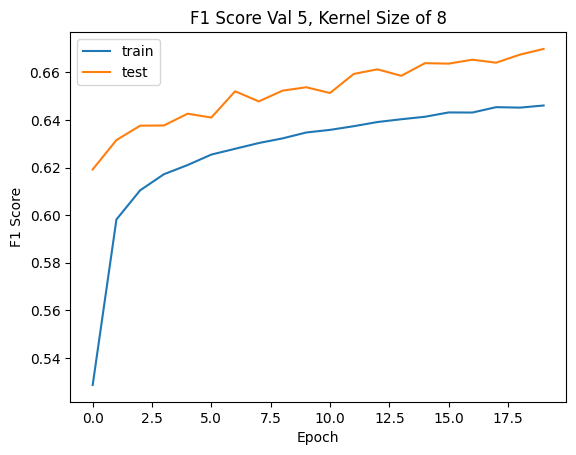

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9051061397856037, 'F1-FIX': 0.9424778332199016, 'F1-SACC': 0.8890491018531016, 'F1-SP': 0.7594784134583812, 'F1-NOISE': 0.7191313630586262}
time: 1h 8min 47s (started: 2023-07-01 11:54:33 +00:00)


In [ ]:
kernel_size_space = [3, 4, 5, 6, 7, 8]
for i in kernel_size_space:
  kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
  fold_var = 1

  for train_index, val_index in kf.split(train_df, label):
    training_data = train_df[train_index]
    training_label = label[train_index]
    validation_data = train_df[val_index]
    validation_label = label[val_index]

    # CREATE NEW MODEL
    model = create_model(
      num_classes = 5,
      train_data_shape = training_data.shape,
      dropout_rate = 0.3,
      nb_filters = 64,
      nb_stacks = 1,
      kernel_size = i,
      dilation_count = 8,
      padding_mode = 'same',
  )

    batch_size = 128

    history_tuned = model.fit(
        training_data, training_label,
        epochs = 20,
        batch_size = batch_size,
        shuffle = True,
        validation_split = 0.1,
        verbose = 1,
        initial_epoch = 0
    )

    plt.plot(history_tuned.history['f1_score'])
    plt.plot(history_tuned.history['val_f1_score'])
    plt.title('F1 Score Val {}, Kernel Size of {}'.format(fold_var, i))
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    fold_var += 1

    raw, preprocessed = evaluate_test_cv(
        model,
        validation_data,
        validation_label,
        batch_size
    )

    print(preprocessed)

#### Dilation Count

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_30 (TCN)                (None, 385, 64)           311744    
                                                                 
 time_distributed_30 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 312,069
Trainable params: 312,069
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [==============================] - 10s 16ms/step - loss: 0.5041 - accuracy: 0.8380 - f1_score: 0.5289 - f1_SP: 0.4474 - f1_FIX: 0.9050 - f1_SACC: 0.7900 - f1_NOISE: 0.5021 - val_loss: 0.4011 - val_accuracy: 0.8680 - val_f1_score: 0

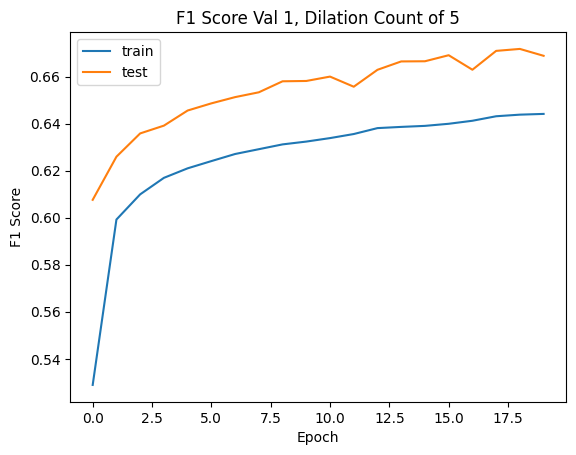

87/87 [==============================] - 1s 4ms/step
{'accuracy': 0.9052659427489668, 'F1-FIX': 0.9423311167132773, 'F1-SACC': 0.8915930612951787, 'F1-SP': 0.7559824727311693, 'F1-NOISE': 0.7055436505769315}
Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_31 (TCN)                (None, 385, 64)           311744    
                                                                 
 time_distributed_31 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 312,069
Trainable params: 312,069
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

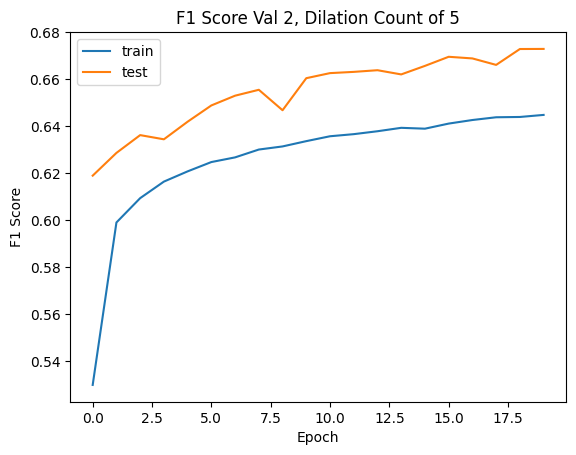

87/87 [==============================] - 1s 4ms/step
{'accuracy': 0.9036131742216494, 'F1-FIX': 0.9415696052514787, 'F1-SACC': 0.8923170242686228, 'F1-SP': 0.7486367643669024, 'F1-NOISE': 0.7045861507799945}
Model: "model_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_32 (TCN)                (None, 385, 64)           311744    
                                                                 
 time_distributed_32 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 312,069
Trainable params: 312,069
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

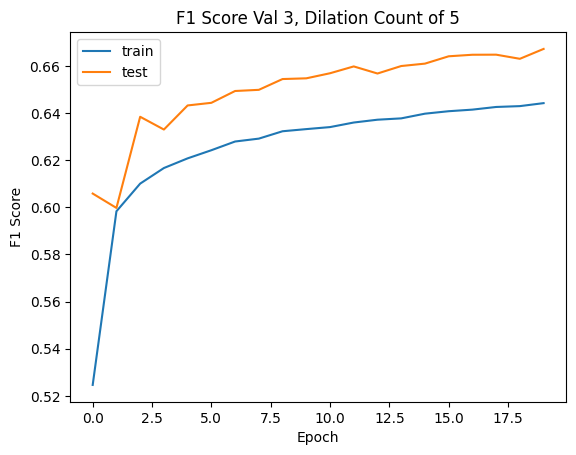

87/87 [==============================] - 1s 4ms/step
{'accuracy': 0.9018829052150312, 'F1-FIX': 0.9403740695863112, 'F1-SACC': 0.8892961865679987, 'F1-SP': 0.7390290882107846, 'F1-NOISE': 0.6989210630312925}
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_33 (TCN)                (None, 385, 64)           311744    
                                                                 
 time_distributed_33 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 312,069
Trainable params: 312,069
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

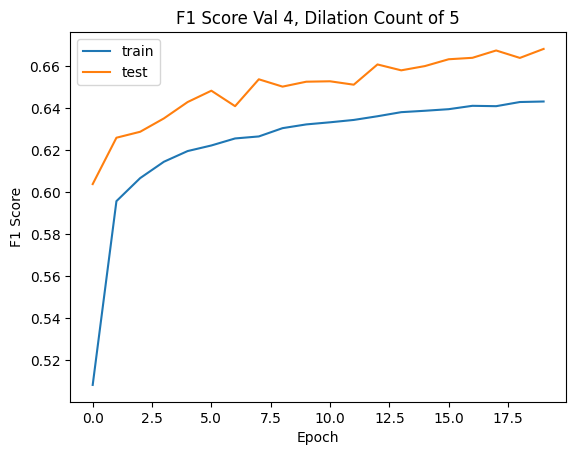

87/87 [==============================] - 1s 4ms/step
{'accuracy': 0.9050910878328481, 'F1-FIX': 0.9425651780771388, 'F1-SACC': 0.8894837114534561, 'F1-SP': 0.7445424932022834, 'F1-NOISE': 0.7120848511414292}
Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_34 (TCN)                (None, 385, 64)           311744    
                                                                 
 time_distributed_34 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 312,069
Trainable params: 312,069
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

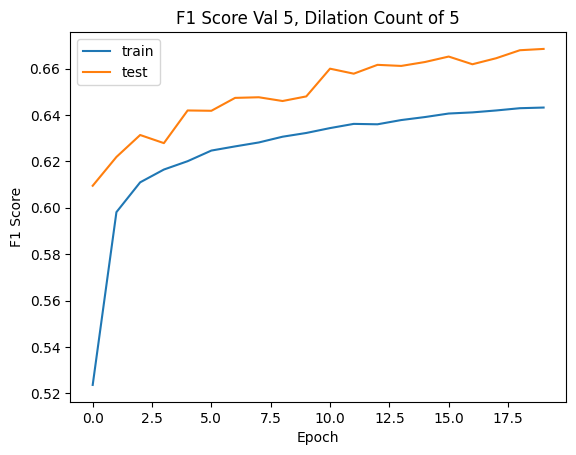

87/87 [==============================] - 1s 4ms/step
{'accuracy': 0.9031324524805148, 'F1-FIX': 0.9413682485124643, 'F1-SACC': 0.8888256569383418, 'F1-SP': 0.7501438487100384, 'F1-NOISE': 0.7144351657913572}
Model: "model_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_36 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_35 (TCN)                (None, 385, 64)           377408    
                                                                 
 time_distributed_35 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 377,733
Trainable params: 377,733
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

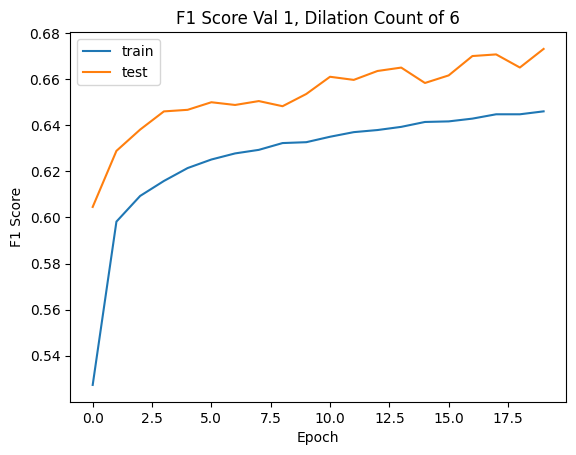

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9048584009923982, 'F1-FIX': 0.9419014251178708, 'F1-SACC': 0.8899398484244252, 'F1-SP': 0.7699496322641813, 'F1-NOISE': 0.7021846765374611}
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_36 (TCN)                (None, 385, 64)           377408    
                                                                 
 time_distributed_36 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 377,733
Trainable params: 377,733
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

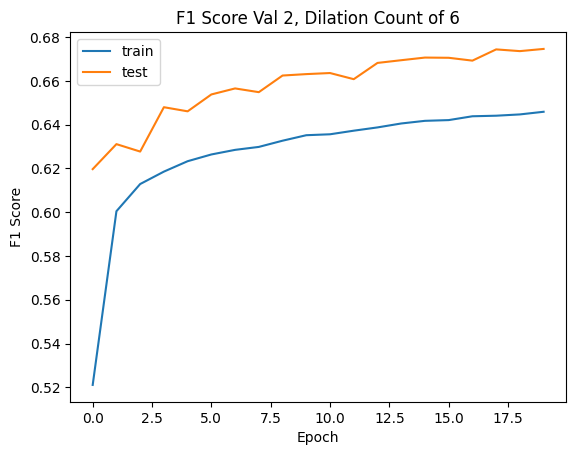

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.902505209386774, 'F1-FIX': 0.9405295243081015, 'F1-SACC': 0.8878611794214375, 'F1-SP': 0.755424440919714, 'F1-NOISE': 0.694634027235347}
Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_37 (TCN)                (None, 385, 64)           377408    
                                                                 
 time_distributed_37 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 377,733
Trainable params: 377,733
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=========================

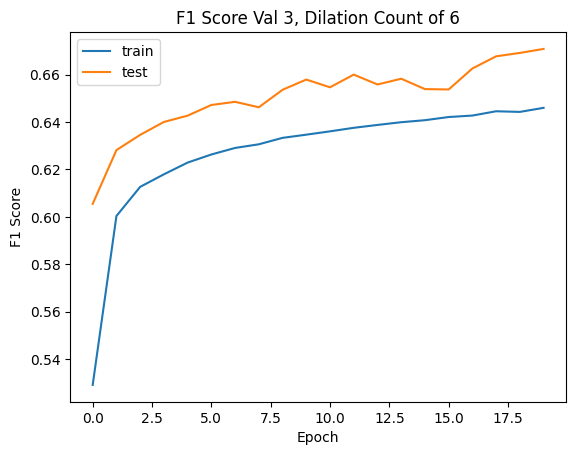

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9029856959411469, 'F1-FIX': 0.9410456259114496, 'F1-SACC': 0.8912793918424892, 'F1-SP': 0.7529437868282862, 'F1-NOISE': 0.7080122329260022}
Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_38 (TCN)                (None, 385, 64)           377408    
                                                                 
 time_distributed_38 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 377,733
Trainable params: 377,733
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

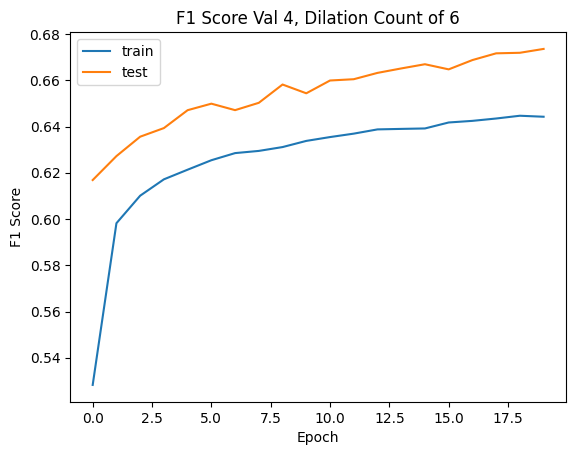

87/87 [==============================] - 1s 4ms/step
{'accuracy': 0.9058265168370203, 'F1-FIX': 0.9429551051997115, 'F1-SACC': 0.8920042799438042, 'F1-SP': 0.7547589876095242, 'F1-NOISE': 0.7119919670483409}
Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_40 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_39 (TCN)                (None, 385, 64)           377408    
                                                                 
 time_distributed_39 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 377,733
Trainable params: 377,733
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

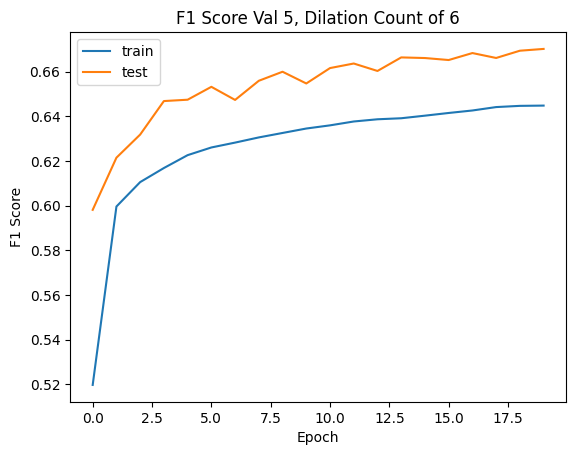

87/87 [==============================] - 1s 4ms/step
{'accuracy': 0.9057105697634491, 'F1-FIX': 0.943114599697193, 'F1-SACC': 0.8875113806278767, 'F1-SP': 0.7610627600826237, 'F1-NOISE': 0.7079062073404329}
Model: "model_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_40 (TCN)                (None, 385, 64)           443072    
                                                                 
 time_distributed_40 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 443,397
Trainable params: 443,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

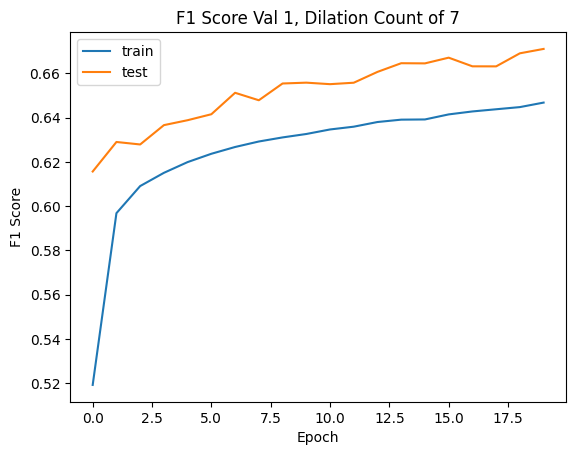

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9043847777392368, 'F1-FIX': 0.9415461379954911, 'F1-SACC': 0.8918538623350387, 'F1-SP': 0.769410083648309, 'F1-NOISE': 0.7075831742132648}
Model: "model_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_42 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_41 (TCN)                (None, 385, 64)           443072    
                                                                 
 time_distributed_41 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 443,397
Trainable params: 443,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

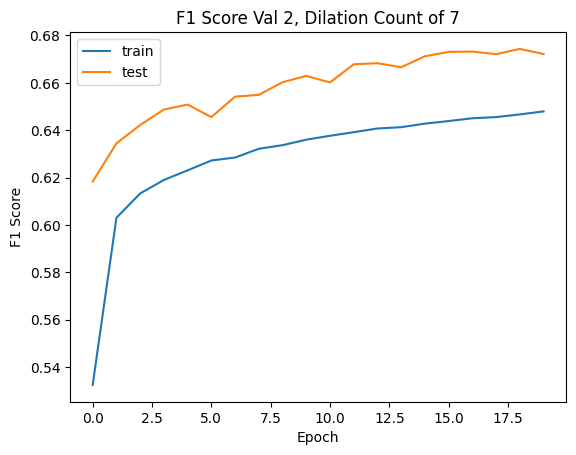

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9046338847678942, 'F1-FIX': 0.9421539762587544, 'F1-SACC': 0.8915175123850385, 'F1-SP': 0.7529179783300515, 'F1-NOISE': 0.7084728039427294}
Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_42 (TCN)                (None, 385, 64)           443072    
                                                                 
 time_distributed_42 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 443,397
Trainable params: 443,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

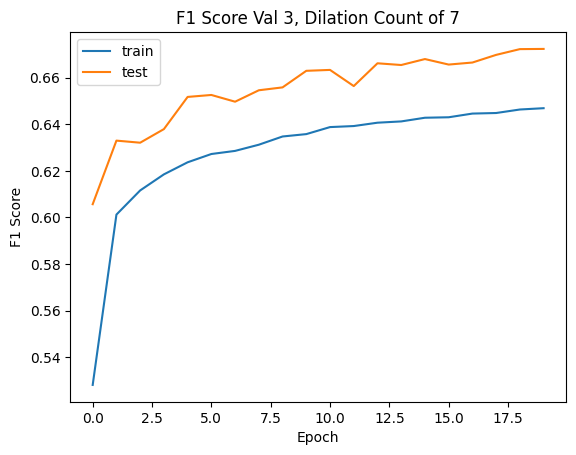

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.8952179475721671, 'F1-FIX': 0.9354356194416277, 'F1-SACC': 0.8906636376920679, 'F1-SP': 0.73900602402946, 'F1-NOISE': 0.7103569306903308}
Model: "model_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_44 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_43 (TCN)                (None, 385, 64)           443072    
                                                                 
 time_distributed_43 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 443,397
Trainable params: 443,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [========================

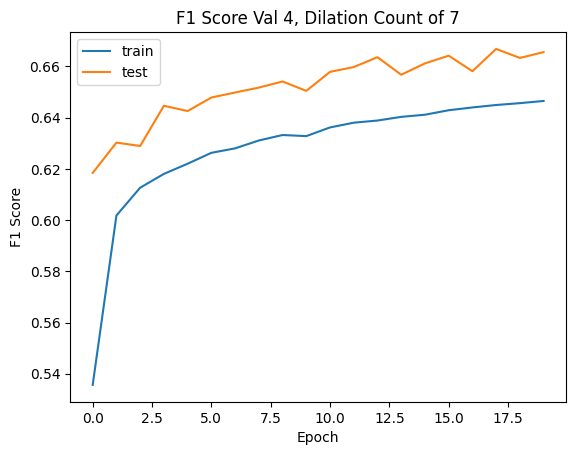

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.907262802391379, 'F1-FIX': 0.9442060573933169, 'F1-SACC': 0.8907373590594092, 'F1-SP': 0.7448939141608781, 'F1-NOISE': 0.7129405622856425}
Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_44 (TCN)                (None, 385, 64)           443072    
                                                                 
 time_distributed_44 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 443,397
Trainable params: 443,397
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

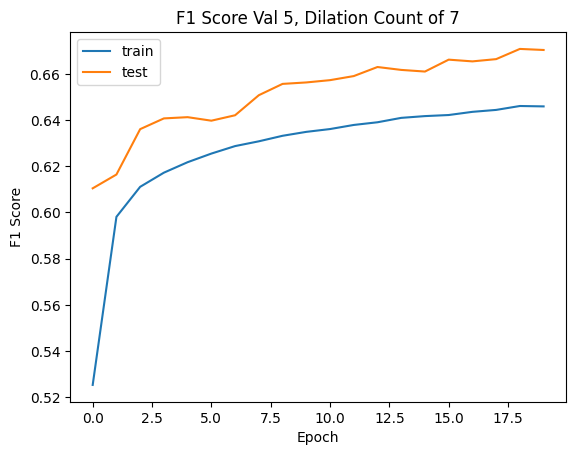

87/87 [==============================] - 1s 5ms/step
{'accuracy': 0.9061237929039451, 'F1-FIX': 0.9432695401558255, 'F1-SACC': 0.8891258015714766, 'F1-SP': 0.7612413251294355, 'F1-NOISE': 0.7169854857311616}
Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_45 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_45 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

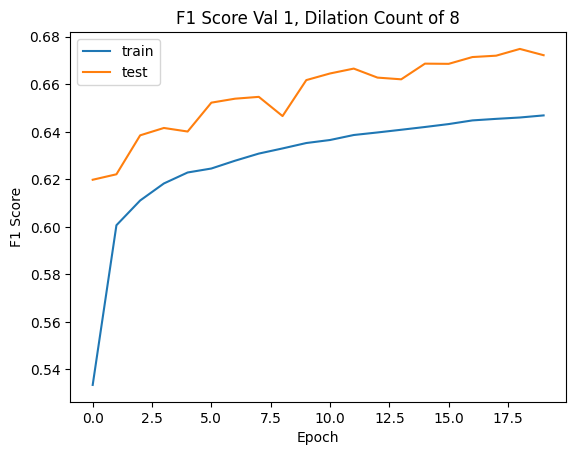

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9089874362848559, 'F1-FIX': 0.9448591342645705, 'F1-SACC': 0.8937190221319135, 'F1-SP': 0.764400470939273, 'F1-NOISE': 0.7058210188569766}
Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_46 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_46 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

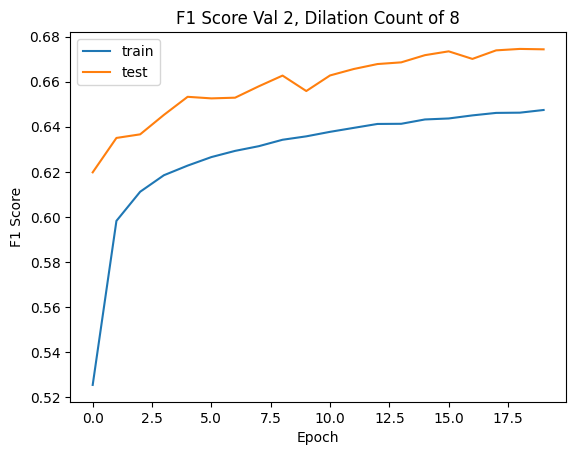

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9062768994858817, 'F1-FIX': 0.9433607086426803, 'F1-SACC': 0.8921179497987896, 'F1-SP': 0.7505470405733726, 'F1-NOISE': 0.7053094447984776}
Model: "model_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_47 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_47 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

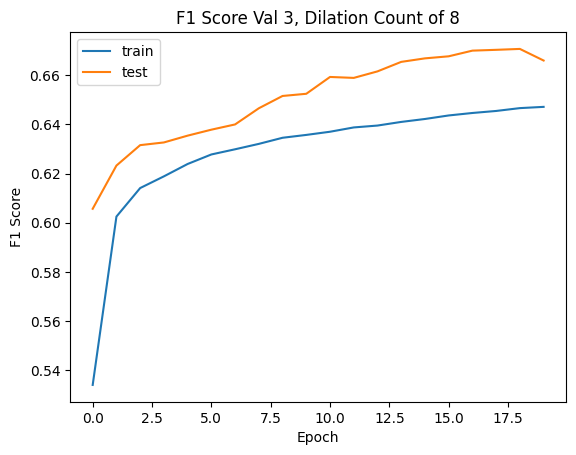

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9035136902214048, 'F1-FIX': 0.9415863070072517, 'F1-SACC': 0.8867264243987496, 'F1-SP': 0.7481685236235951, 'F1-NOISE': 0.6967327642606995}
Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_48 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_48 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [======================

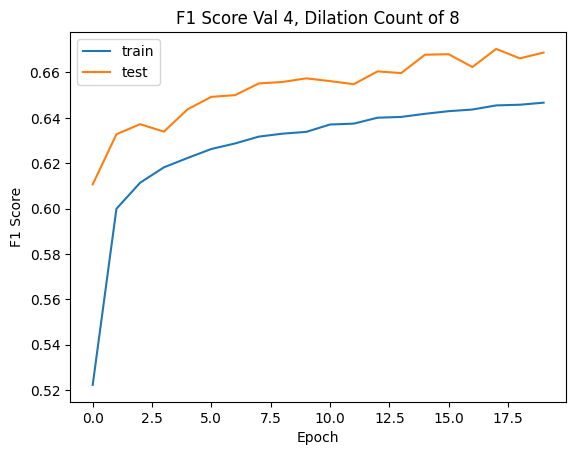

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9067771417282464, 'F1-FIX': 0.9438948525025133, 'F1-SACC': 0.8898471520198477, 'F1-SP': 0.7532573525091437, 'F1-NOISE': 0.717865871880685}
Model: "model_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_50 (InputLayer)       [(None, 385, 28)]         0         
                                                                 
 tcn_49 (TCN)                (None, 385, 64)           508736    
                                                                 
 time_distributed_49 (TimeDi  (None, 385, 5)           325       
 stributed)                                                      
                                                                 
Total params: 509,061
Trainable params: 509,061
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
311/311 [=======================

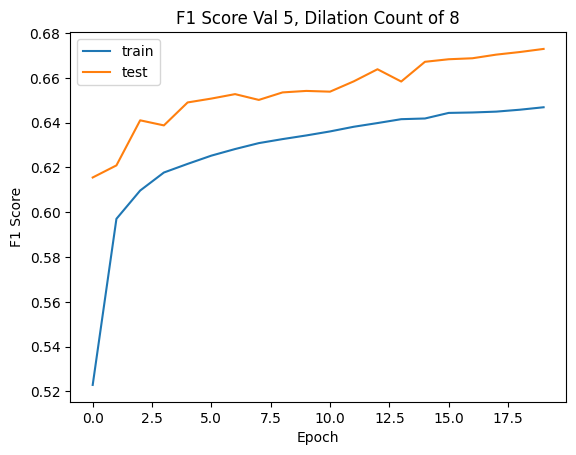

87/87 [==============================] - 1s 6ms/step
{'accuracy': 0.9018589161653269, 'F1-FIX': 0.9400686006408003, 'F1-SACC': 0.8912506924752002, 'F1-SP': 0.7579263150885481, 'F1-NOISE': 0.7122246762474331}
time: 38min 46s (started: 2023-07-01 13:04:08 +00:00)


In [ ]:
dilation_count_space = [5, 6, 7, 8]
for i in dilation_count_space:
  kf = KFold(n_splits = 5, random_state = 42, shuffle = True)
  fold_var = 1

  for train_index, val_index in kf.split(train_df, label):
    training_data = train_df[train_index]
    training_label = label[train_index]
    validation_data = train_df[val_index]
    validation_label = label[val_index]

    # CREATE NEW MODEL
    model = create_model(
      num_classes = 5,
      train_data_shape = training_data.shape,
      dropout_rate = 0.3,
      nb_filters = 64,
      nb_stacks = 1,
      kernel_size = 8,
      dilation_count = i,
      padding_mode = 'same',
  )

    batch_size = 128

    history_tuned = model.fit(
        training_data, training_label,
        epochs = 20,
        batch_size = batch_size,
        shuffle = True,
        validation_split = 0.1,
        verbose = 1,
        initial_epoch = 0
    )

    plt.plot(history_tuned.history['f1_score'])
    plt.plot(history_tuned.history['val_f1_score'])
    plt.title('F1 Score Val {}, Dilation Count of {}'.format(fold_var, i))
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc = 'upper left')
    plt.show()

    fold_var += 1

    raw, preprocessed = evaluate_test_cv(
        model,
        validation_data,
        validation_label,
        batch_size
    )

    print(preprocessed)

In [ ]:
from google.colab import runtime
runtime.unassign()